In [1]:
import pandas as pd # Part 1: Data Loading with Fixed Dataset Approach (CSV Format)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime
import os
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid') # Set plotting style
sns.set_palette("viridis")
data_dir = 'asx200_data'  # Create a directory for saved datasets
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    print(f"Created directory: {data_dir}")
raw_data_file = f"{data_dir}/asx200_raw_data.csv" # Define file paths for fixed dataset
processed_data_file = f"{data_dir}/asx200_processed_data.csv"
def get_asx200_data(start_date='2018-01-01', end_date='2023-01-01', force_download=False): # Function to load or download ASX200 data
    if os.path.exists(raw_data_file) and not force_download:     # Check if we already have saved data
        print(f"Loading ASX200 data from saved file: {raw_data_file}")
        try:
            data = pd.read_csv(raw_data_file)
            data['Date'] = pd.to_datetime(data['Date'])             # Convert date column to datetime and set as index
            data.set_index('Date', inplace=True)
            print(f"Loaded data with {len(data)} rows from {data.index.min().date()} to {data.index.max().date()}")
            return data
        except Exception as e:
            print(f"Error loading saved data: {e}")
    print(f"Downloading ASX200 data from Yahoo Finance (start={start_date}, end={end_date})...")     # Download fresh data if needed
    try:
        data = yf.download('^AXJO', start=start_date, end=end_date)
        print(f"Downloaded {len(data)} rows of ASX200 data")
        data.reset_index().to_csv(raw_data_file, index=False)         # Save raw data as CSV for future use
        print(f"Saved raw data to {raw_data_file}")
        return data
    except Exception as e:
        print(f"Error downloading data: {e}")
        date_range = pd.date_range(start=start_date, end=end_date, freq='B')         # If download fails, create minimal synthetic data for testing
        synthetic_data = pd.DataFrame(
            index=date_range,
            data={
                'Open': np.random.normal(7000, 300, size=len(date_range)),
                'High': np.random.normal(7100, 300, size=len(date_range)),
                'Low': np.random.normal(6900, 300, size=len(date_range)),
                'Close': np.random.normal(7000, 300, size=len(date_range)),
                'Adj Close': np.random.normal(7000, 300, size=len(date_range)),
                'Volume': np.random.normal(1000000, 200000, size=len(date_range))
            }
        )
        synthetic_data.reset_index().rename(columns={'index': 'Date'}).to_csv(raw_data_file, index=False)         # Save synthetic data as CSV
        print(f"Saved synthetic data to {raw_data_file}")
        return synthetic_data
def prepare_data(data): # Function to process and prepare data for modeling
    if os.path.exists(processed_data_file):     # Check if processed data already exists
        print(f"Loading processed data from: {processed_data_file}")
        try:
            stocks_df = pd.read_csv(processed_data_file)
            stocks_df['date'] = pd.to_datetime(stocks_df['date'])             # Convert date column to datetime
            df = stocks_df.copy()             # Recreate the other formats needed
            df.set_index('date', inplace=True)
            close_series = df['Close'].copy()
            result = {
                'df': df,
                'stocks_df': stocks_df,
                'close_series': close_series
            }
            return result
        except Exception as e:
            print(f"Error loading processed data: {e}")
    df = data.copy()     # Create a copy to avoid modifying the original
    if df.isnull().sum().sum() > 0:     # Handle missing values
        print(f"Filling {df.isnull().sum().sum()} missing values...")
        df = df.fillna(method='ffill')
        if df.isnull().sum().sum() > 0:         # Check if any still remain
            df = df.fillna(method='bfill')
    df['Returns'] = df['Close'].pct_change() * 100     # Calculate returns
    stocks_df = df.reset_index()     # Create dataframe with date as column (for easier merging)
    stocks_df.rename(columns={'index': 'Date', 'Date': 'date'}, inplace=True)
    if 'Date' in stocks_df.columns and 'date' not in stocks_df.columns:     # Ensure column is named consistently as 'date'
        stocks_df.rename(columns={'Date': 'date'}, inplace=True)
    stocks_df['date'] = pd.to_datetime(stocks_df['date'])
    close_series = df['Close'].copy()     # Extract close price series for time series modeling
    stocks_df = stocks_df.dropna()     # Drop rows with NaN values (typically just the first row with return calculation)
    stocks_df.to_csv(processed_data_file, index=False)     # Save processed data as CSV
    print(f"Saved processed data to {processed_data_file}")
    result = {      # Create a dictionary with all processed data formats
        'df': df,                   # Original dataframe with date as index
        'stocks_df': stocks_df,     # Dataframe with date as column
        'close_series': close_series # Close price series
    }
    return result
data = get_asx200_data() # Load or download the data
processed_data = prepare_data(data) # Process the data
df = processed_data['df']                  # DataFrame with date as index
stocks_df = processed_data['stocks_df']    # DataFrame with date as column
close_series = processed_data['close_series'] # Close price series
print(f"Date range: {stocks_df['date'].min().date()} to {stocks_df['date'].max().date()}")
print(f"Number of trading days: {len(stocks_df)}")
print(stocks_df.head())
print(stocks_df[['Close', 'Returns']].describe())

Loading ASX200 data from saved file: asx200_data/asx200_raw_data.csv
Loaded data with 1266 rows from 2018-01-02 to 2022-12-30
Loading processed data from: asx200_data/asx200_processed_data.csv
Date range: 2018-01-03 to 2022-12-30
Number of trading days: 1265
        date             Close             High               Low  \
0        NaT             ^AXJO            ^AXJO             ^AXJO   
1 2018-01-03  6070.39990234375  6082.2998046875   6060.7998046875   
2 2018-01-04  6077.10009765625  6102.2001953125   6068.7998046875   
3 2018-01-05   6122.2998046875  6124.7998046875  6077.10009765625   
4 2018-01-08  6130.39990234375           6143.0   6122.2998046875   

               Open Volume   Returns  
0             ^AXJO  ^AXJO       NaN  
1   6061.2998046875      0  0.150134  
2  6070.39990234375      0  0.110375  
3  6077.10009765625      0  0.743771  
4   6122.2998046875      0  0.132305  
           Returns
count  1264.000000
mean      0.017900
std       1.097742
min      -9.6997

Dataframe cleaned successfully. Shape: (1264, 7)
Saved cleaned data to asx200_data/asx200_cleaned_data.csv
        date        Close         High          Low         Open  Volume  \
1 2018-01-03  6070.399902  6082.299805  6060.799805  6061.299805     0.0   
2 2018-01-04  6077.100098  6102.200195  6068.799805  6070.399902     0.0   
3 2018-01-05  6122.299805  6124.799805  6077.100098  6077.100098     0.0   
4 2018-01-08  6130.399902  6143.000000  6122.299805  6122.299805     0.0   
5 2018-01-09  6135.799805  6149.600098  6130.399902  6130.399902     0.0   

    Returns  
1  0.150134  
2  0.110375  
3  0.743771  
4  0.132305  
5  0.088084  

Columns: ['date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Returns']


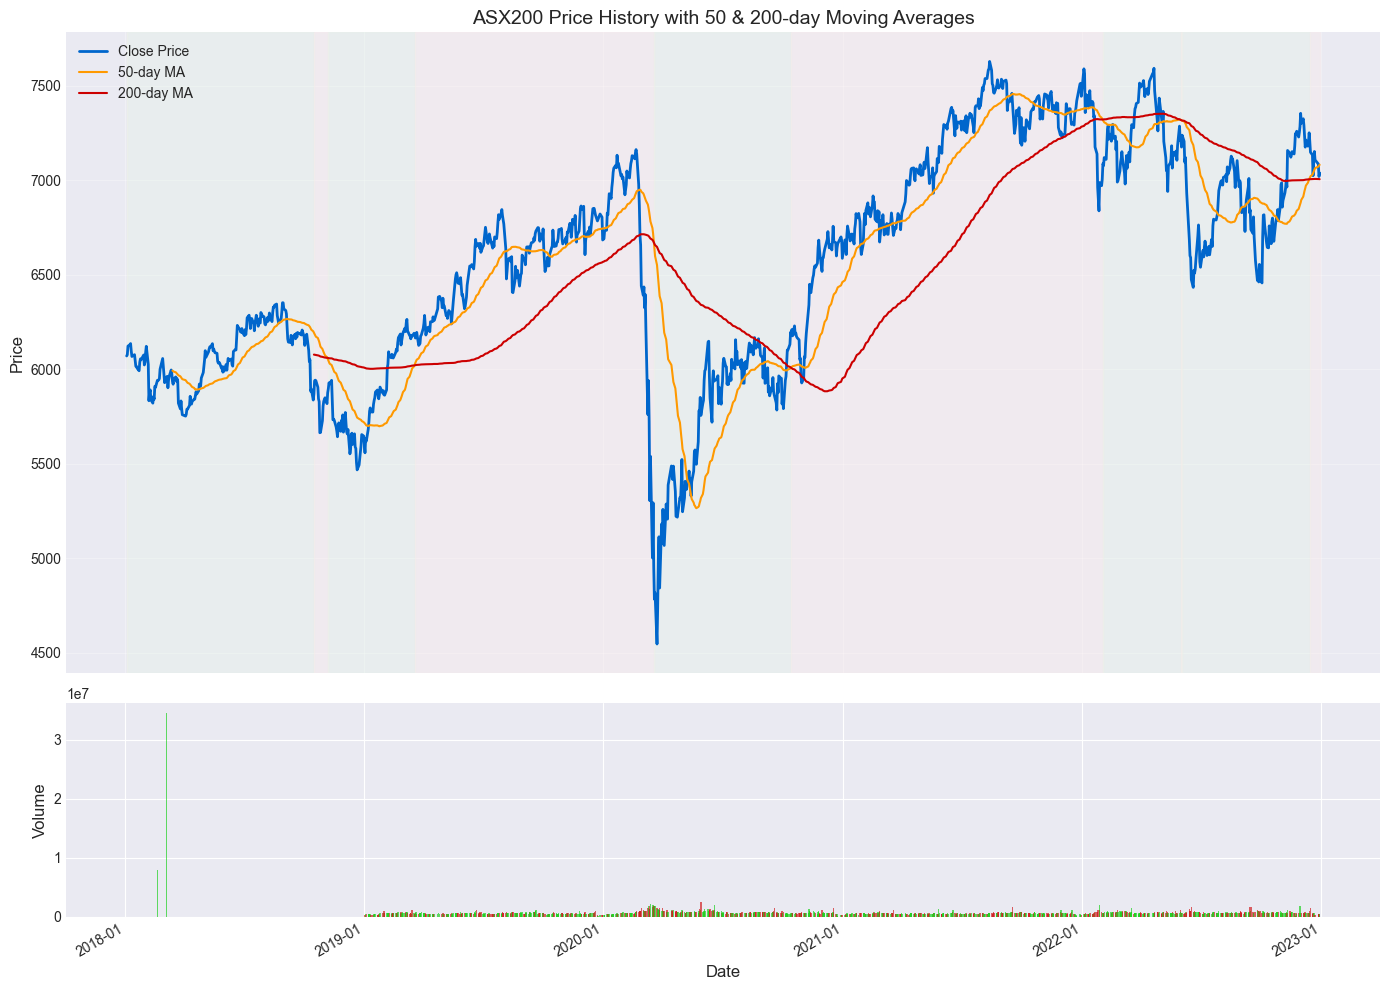

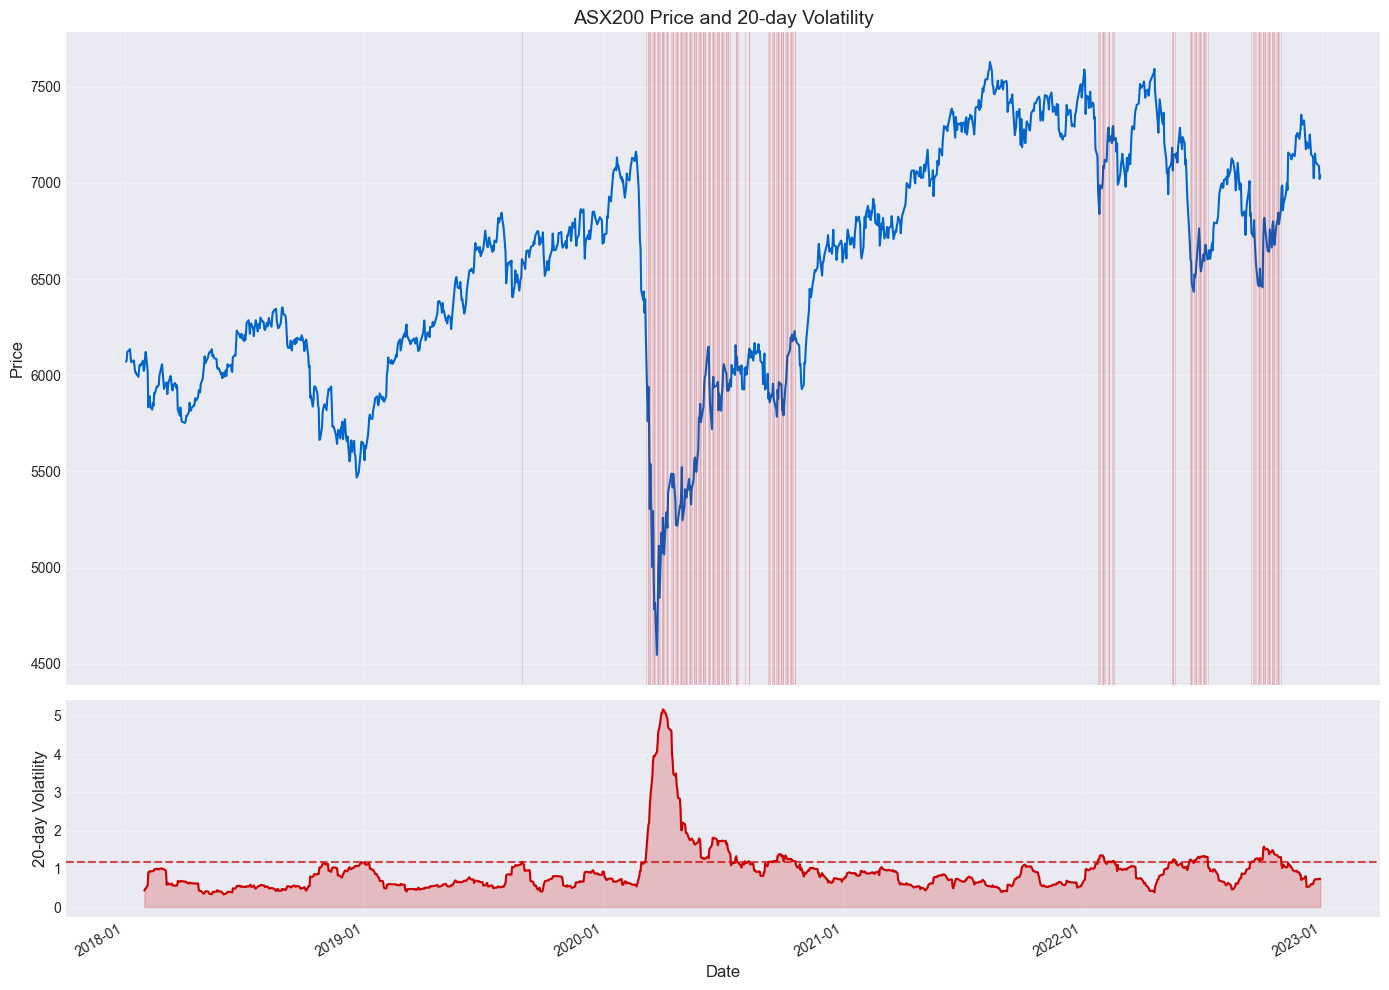

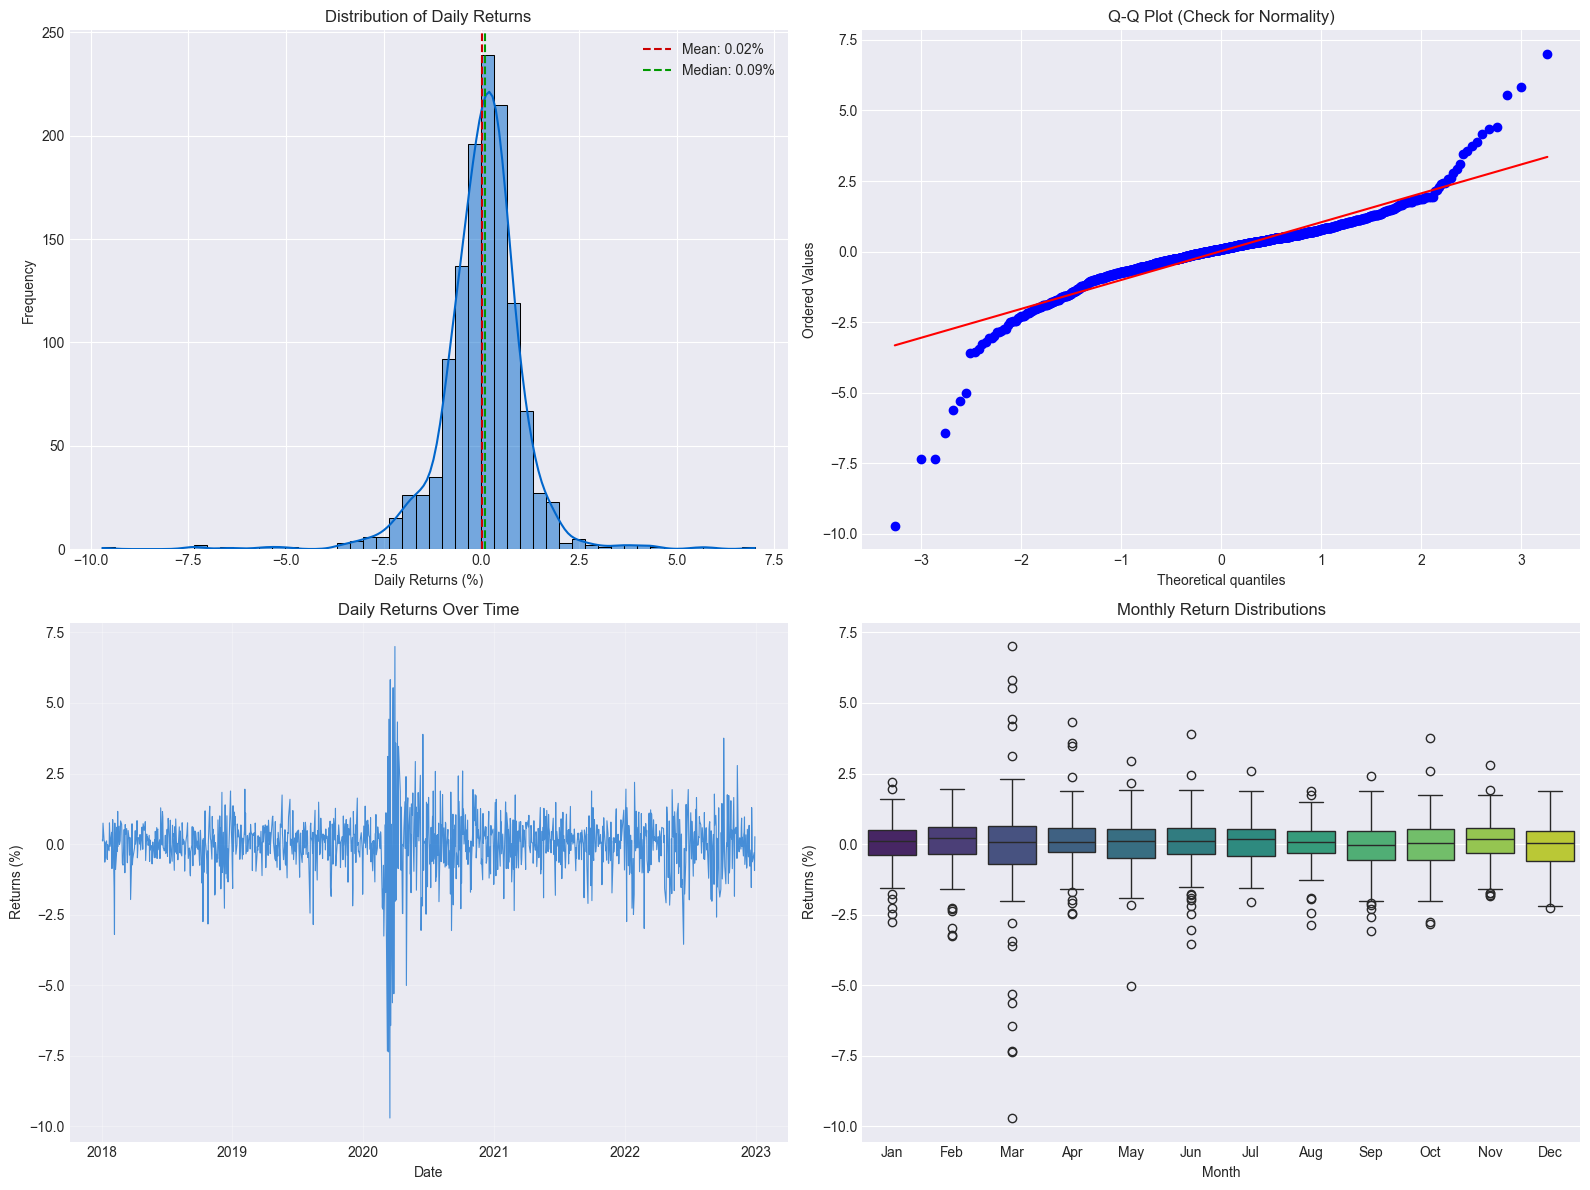

In [2]:
from matplotlib.dates import DateFormatter  # Part 2: Data Cleaning and Visualization
viz_dir = 'asx200_visualizations' # Create directory for visualizations
if not os.path.exists(viz_dir):
    os.makedirs(viz_dir)
    print(f"Created directory: {viz_dir}")
def clean_dataframe(df): # Function to clean the MultiIndex columns if present
    cleaned_df = df.copy()     # Make a copy to avoid modifying the original
    if isinstance(cleaned_df.columns, pd.MultiIndex):     # Check if there are MultiIndex columns
        new_cols = []         # Create new column names by combining levels
        for col in cleaned_df.columns:
            if isinstance(col, tuple):
                parts = [str(part) for part in col if part and str(part) != '^AXJO']                 # Join non-empty parts of the tuple
                if parts:
                    new_cols.append('_'.join(parts))
                else:
                    for part in reversed(col):                     # If no parts after filtering, use the last non-empty part
                        if part and str(part) != '^AXJO':
                            new_cols.append(str(part))
                            break
                    else:
                        new_cols.append('column_' + str(len(new_cols)))
            else:
                new_cols.append(str(col))
        seen = {}         # Handle duplicates in column names
        for i, col in enumerate(new_cols):
            if col in seen:
                new_cols[i] = f"{col}_{seen[col]}"
                seen[col] += 1
            else:
                seen[col] = 1
        cleaned_df.columns = new_cols         # Set the new column names
    if 'date' not in cleaned_df.columns and 'Date' in cleaned_df.columns:     # Ensure the date column is correct
        cleaned_df.rename(columns={'Date': 'date'}, inplace=True)
    if 'date' in cleaned_df.columns:     # Ensure date is datetime type
        cleaned_df['date'] = pd.to_datetime(cleaned_df['date'])
    numeric_cols = ['Close', 'Open', 'High', 'Low', 'Volume', 'Returns']     # Ensure numeric columns are properly typed
    for col in numeric_cols:
        if col in cleaned_df.columns:
            cleaned_df[col] = pd.to_numeric(cleaned_df[col], errors='coerce')
    if 'Close' in cleaned_df.columns:     # Drop any rows with NaN in critical columns
        cleaned_df = cleaned_df.dropna(subset=['Close'])
    print(f"Dataframe cleaned successfully. Shape: {cleaned_df.shape}")
    return cleaned_df
def plot_price_history(df, save=True): # Function to create enhanced price chart
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)     # Create figure and axes
    ax1.plot(df['date'], df['Close'], linewidth=2, color='#0066cc', label='Close Price')     # Plot the price data
    df['SMA_50'] = df['Close'].rolling(window=50).mean()    # Calculate and plot moving averages
    df['SMA_200'] = df['Close'].rolling(window=200).mean()
    ax1.plot(df['date'], df['SMA_50'], color='#ff9900', linewidth=1.5, label='50-day MA')
    ax1.plot(df['date'], df['SMA_200'], color='#cc0000', linewidth=1.5, label='200-day MA')
    df['bull_market'] = df['SMA_50'] > df['SMA_200']     # Highlight bull/bear market periods (when 50-day MA crosses 200-day MA)
    crossovers = df[df['bull_market'] != df['bull_market'].shift(1)].copy()     # Find crossover points
    if not crossovers.empty:     # Add background shading for bull/bear markets
        prev_x = df['date'].iloc[0]
        prev_bull = df['SMA_50'].iloc[0] > df['SMA_200'].iloc[0]
        for _, row in crossovers.iterrows():
            color = '#e6f7e6' if prev_bull else '#ffebeb'  # Light green for bull, light red for bear
            ax1.axvspan(prev_x, row['date'], alpha=0.3, color=color)
            prev_x = row['date']             # Update for next region
            prev_bull = not prev_bull
        color = '#e6f7e6' if prev_bull else '#ffebeb'         # Shade the final region to the end of the chart
        ax1.axvspan(prev_x, df['date'].iloc[-1], alpha=0.3, color=color)
    volume_colors = np.where(df['Close'] > df['Close'].shift(1), '#00cc00', '#cc0000')     # Add volume subplot
    ax2.bar(df['date'], df['Volume'], color=volume_colors, width=2, alpha=0.6)
    ax2.set_ylabel('Volume', fontsize=12)
    ax1.set_title('ASX200 Price History with 50 & 200-day Moving Averages', fontsize=14)     # Format the axes
    ax1.set_ylabel('Price', fontsize=12)
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    ax2.set_xlabel('Date', fontsize=12)     # Add axis labels
    date_format = DateFormatter('%Y-%m')     # Format the dates
    ax2.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()
def plot_volatility_analysis(df, window=20, save=True): # Function to visualize volatility
    df['Volatility'] = df['Returns'].rolling(window=window).std()     # Calculate rolling volatility
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)     # Create figure
    ax1.plot(df['date'], df['Close'], color='#0066cc', linewidth=1.5)     # Plot price data
    ax1.set_title(f'ASX200 Price and {window}-day Volatility', fontsize=14)
    ax1.set_ylabel('Price', fontsize=12)
    ax1.grid(True, alpha=0.3)
    median_vol = df['Volatility'].median()     # Identify high volatility periods (above 1.5x median)
    high_vol_threshold = median_vol * 1.5
    high_vol_periods = df[df['Volatility'] > high_vol_threshold]
    if not high_vol_periods.empty:     # Highlight high volatility periods in price chart
        for _, row in high_vol_periods.iterrows():
            ax1.axvline(x=row['date'], color='#cc0000', alpha=0.2, linewidth=0.5)
    ax2.plot(df['date'], df['Volatility'], color='#cc0000', linewidth=1.5)     # Plot volatility
    ax2.axhline(y=high_vol_threshold, color='#cc0000', linestyle='--', alpha=0.7)
    ax2.fill_between(df['date'], df['Volatility'], color='#cc0000', alpha=0.2)
    ax2.set_ylabel(f'{window}-day Volatility', fontsize=12)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.grid(True, alpha=0.3)
    date_format = DateFormatter('%Y-%m')     # Format the dates
    ax2.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()
def plot_returns_distribution(df, save=True): # Function to visualize returns distribution
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))     # Create figure
    sns.histplot(df['Returns'], bins=50, kde=True, ax=ax1, color='#0066cc')     # 1. Histogram of returns
    ax1.set_title('Distribution of Daily Returns', fontsize=12)
    ax1.set_xlabel('Daily Returns (%)', fontsize=10)
    ax1.set_ylabel('Frequency', fontsize=10)
    mean_return = df['Returns'].mean()     # Add vertical lines for mean and median
    median_return = df['Returns'].median()
    ax1.axvline(x=mean_return, color='#cc0000', linestyle='--', label=f'Mean: {mean_return:.2f}%')
    ax1.axvline(x=median_return, color='#009900', linestyle='--', label=f'Median: {median_return:.2f}%')
    ax1.legend()
    from scipy import stats     # 2. Q-Q plot for normality check
    stats.probplot(df['Returns'], plot=ax2)
    ax2.set_title('Q-Q Plot (Check for Normality)', fontsize=12)
    ax3.plot(df['date'], df['Returns'], color='#0066cc', alpha=0.7, linewidth=0.8)     # 3. Time series of returns
    ax3.set_title('Daily Returns Over Time', fontsize=12)
    ax3.set_xlabel('Date', fontsize=10)
    ax3.set_ylabel('Returns (%)', fontsize=10)
    ax3.grid(True, alpha=0.3)
    df['month'] = df['date'].dt.month     # 4. Monthly seasonality boxplot
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    sns.boxplot(x='month', y='Returns', data=df, ax=ax4, palette='viridis')
    ax4.set_title('Monthly Return Distributions', fontsize=12)
    ax4.set_xlabel('Month', fontsize=10)
    ax4.set_ylabel('Returns (%)', fontsize=10)
    ax4.set_xticklabels(month_names)
    plt.tight_layout()
    plt.show()
stocks_df = clean_dataframe(stocks_df) # Clean the dataframe to handle MultiIndex columns
cleaned_file = 'asx200_data/asx200_cleaned_data.csv' # Save the cleaned dataframe
stocks_df.to_csv(cleaned_file, index=False)
print(f"Saved cleaned data to {cleaned_file}")
print(stocks_df.head()) # Display the cleaned dataframe
print(f"\nColumns: {stocks_df.columns.tolist()}")
df = stocks_df.set_index('date') # Update other data structures to be consistent
close_series = df['Close'].copy()
plot_price_history(stocks_df) # Create and save visualizations
plot_volatility_analysis(stocks_df)
plot_returns_distribution(stocks_df)

Loading cleaned data from asx200_data/asx200_cleaned_data.csv
Processing 1264 rows of data...
Shape before removing NaN values: (1264, 77)
Shape after removing NaN values: (982, 77)
Retained 77.7% of original data
Saved enriched data with all features to asx200_data/asx200_enriched_data.csv
Analyzing feature correlations with Target_Next_Close...


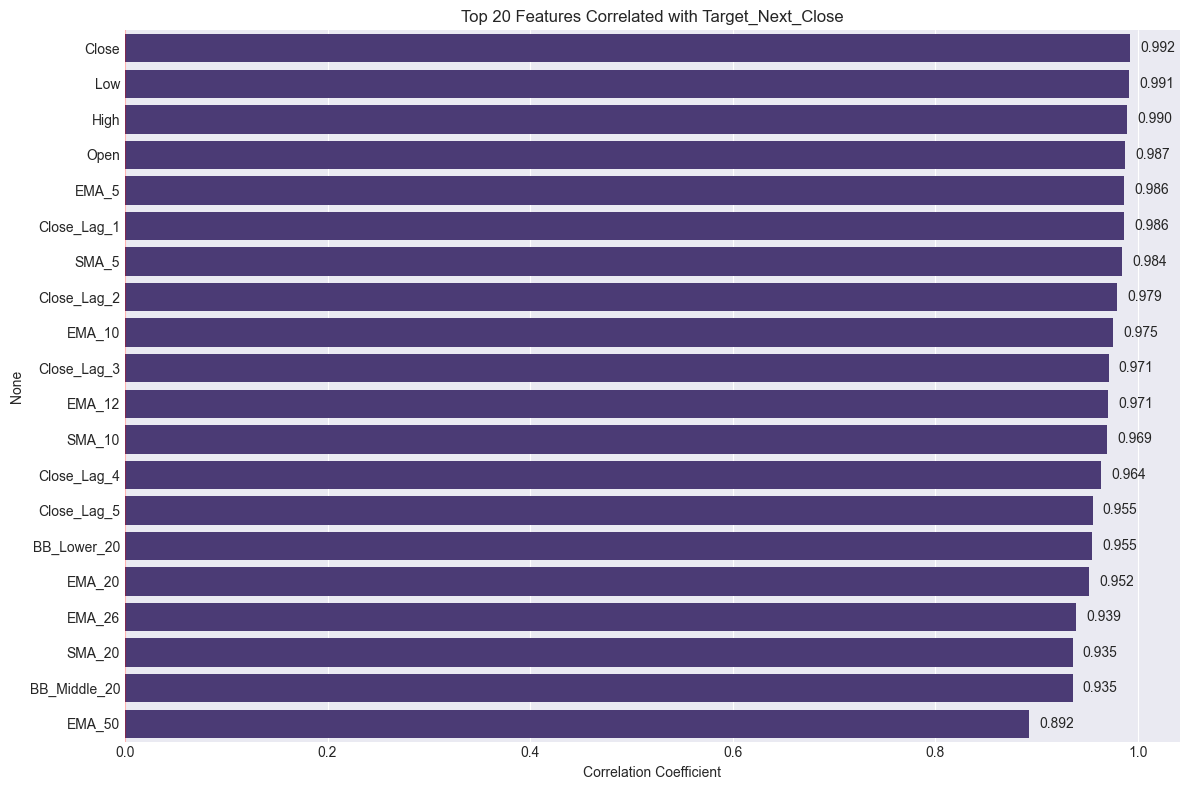

Number of rows: 982
Number of features: 73
          date        Close     RSI_14       MACD    Stoch_K     ATR_14  \
272 2019-01-31  5864.700195  61.072195  54.811027  68.098606  38.064314   
273 2019-02-01  5862.799805  64.969395  51.904935  66.898109  37.364328   
274 2019-02-04  5891.200195  68.303323  51.302131  83.074788  37.771484   
275 2019-02-05  6005.899902  74.196800  59.395044  85.781270  45.400042   
276 2019-02-06  6026.100098  74.170670  66.670190  92.245909  46.957171   

     BB_%B_20  Volatility_20        ADX  Trend_Strength  
272  0.668335       0.552316  47.652664        0.013075  
273  0.645849       0.492222  46.276507        0.012261  
274  0.743190       0.484219  47.006976        0.014420  
275  1.139992       0.586604  49.835006        0.024624  
276  1.115162       0.578824  52.079215        0.026930  


In [3]:
if os.path.exists(cleaned_file): # Part 3: Advanced Feature Engineering
    print(f"Loading cleaned data from {cleaned_file}")
    stocks_df = pd.read_csv(cleaned_file)
    stocks_df['date'] = pd.to_datetime(stocks_df['date'])
else:
    raise FileNotFoundError(f"Could not find {cleaned_file}")     # Exit or create placeholder data
def calculate_technical_indicators(df): # Function to calculate comprehensive technical indicators
    df = df.copy()     # Make a copy to avoid modifying the original
    df = df.sort_values('date')     # Ensure sorted by date
    for window in [5, 10, 20, 50, 100, 200]:      # 1. Price-based indicators        //     # Moving Averages
        df[f'SMA_{window}'] = df['Close'].rolling(window=window).mean()
        df[f'EMA_{window}'] = df['Close'].ewm(span=window, adjust=False).mean()
    df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()     # Moving Average Convergence Divergence (MACD)
    df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']
    for window in [5, 10, 20]:     # Price Rate of Change
        df[f'ROC_{window}'] = df['Close'].pct_change(periods=window) * 100
    delta = df['Close'].diff()      # 2. Momentum indicators  //      # Relative Strength Index (RSI)
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss.replace(0, np.nan)  # Avoid division by zero
    df['RSI_14'] = 100 - (100 / (1 + rs))
    df['RSI_14'] = df['RSI_14'].replace([np.inf, -np.inf], np.nan).fillna(50)  # Handle edge cases
    low_14 = df['Low'].rolling(window=14).min()     # Stochastic Oscillator
    high_14 = df['High'].rolling(window=14).max()
    df['Stoch_K'] = 100 * ((df['Close'] - low_14) / (high_14 - low_14))
    df['Stoch_D'] = df['Stoch_K'].rolling(window=3).mean()
    df['Williams_R'] = -100 * ((high_14 - df['Close']) / (high_14 - low_14))     # Williams %R
    df['TR'] = np.maximum(      # 3. Volatility indicators //      # Average True Range (ATR)
        df['High'] - df['Low'],
        np.maximum(
            abs(df['High'] - df['Close'].shift(1)),
            abs(df['Low'] - df['Close'].shift(1))
        )
    )
    df['ATR_14'] = df['TR'].rolling(window=14).mean()
    for window in [20]:      # Bollinger Bands
        middle_band = df['Close'].rolling(window=window).mean()
        std_dev = df['Close'].rolling(window=window).std()
        df[f'BB_Upper_{window}'] = middle_band + (std_dev * 2)
        df[f'BB_Middle_{window}'] = middle_band
        df[f'BB_Lower_{window}'] = middle_band - (std_dev * 2)
        df[f'BB_Width_{window}'] = (df[f'BB_Upper_{window}'] - df[f'BB_Lower_{window}']) / df[f'BB_Middle_{window}']         # %B indicator (position within Bollinger Bands)
        df[f'BB_%B_{window}'] = (df['Close'] - df[f'BB_Lower_{window}']) / (df[f'BB_Upper_{window}'] - df[f'BB_Lower_{window}'])
    for window in [5, 10, 20, 50]:      # Historical Volatility
        df[f'Volatility_{window}'] = df['Returns'].rolling(window=window).std()
    df['DMplus'] = np.where(      # 4. Trend indicators  //      # Average Directional Index (ADX)
        (df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']),
        np.maximum(df['High'] - df['High'].shift(1), 0),
        0
    )
    df['DMminus'] = np.where(
        (df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)),
        np.maximum(df['Low'].shift(1) - df['Low'], 0),
        0
    )
    df['smoothed_TR'] = df['TR'].rolling(window=14).sum()      # Smoothed values
    df['smoothed_DMplus'] = df['DMplus'].rolling(window=14).sum()
    df['smoothed_DMminus'] = df['DMminus'].rolling(window=14).sum()
    df['DIplus'] = 100 * df['smoothed_DMplus'] / df['smoothed_TR'].replace(0, np.nan)     # Calculate +DI and -DI
    df['DIminus'] = 100 * df['smoothed_DMminus'] / df['smoothed_TR'].replace(0, np.nan)
    df['DX'] = 100 * abs(df['DIplus'] - df['DIminus']) / (df['DIplus'] + df['DIminus']).replace(0, np.nan)     # Calculate DX and ADX
    df['ADX'] = df['DX'].ewm(span=14, adjust=False).mean()
    df['SMA_Cross_5_20'] = np.where(df['SMA_5'] > df['SMA_20'], 1, -1)     # Moving Average Crossovers
    df['SMA_Cross_10_50'] = np.where(df['SMA_10'] > df['SMA_50'], 1, -1)
    df['SMA_Cross_50_200'] = np.where(df['SMA_50'] > df['SMA_200'], 1, -1)
    if 'Volume' in df.columns and df['Volume'].sum() > 0:     # 5. Volume-based indicators (if volume data is available and valid)
        df['OBV'] = np.where(          # On-Balance Volume (OBV)
            df['Close'] > df['Close'].shift(1),
            df['Volume'],
            np.where(
                df['Close'] < df['Close'].shift(1),
                -df['Volume'],
                0
            )
        ).cumsum()
        for window in [5, 10, 20]:         # Volume Rate of Change
            df[f'Volume_ROC_{window}'] = df['Volume'].pct_change(periods=window) * 100
        typical_price = (df['High'] + df['Low'] + df['Close']) / 3         # Money Flow Index (MFI)
        raw_money_flow = typical_price * df['Volume']
        positive_flow = np.where(typical_price > typical_price.shift(1), raw_money_flow, 0)
        negative_flow = np.where(typical_price < typical_price.shift(1), raw_money_flow, 0)
        for window in [14]:
            pos_sum = pd.Series(positive_flow).rolling(window=window).sum()
            neg_sum = pd.Series(negative_flow).rolling(window=window).sum()
            money_ratio = np.where(neg_sum != 0, pos_sum / neg_sum, 100)
            df[f'MFI_{window}'] = 100 - (100 / (1 + money_ratio))
    df['RSI_Close_Ratio'] = df['RSI_14'] / df['Close'] * 100      # 6. Hybrid/custom indicators  //      # RSI and price combined
    df['MACD_BB_Signal'] = np.where(      # MACD and BB crossover
        (df['MACD'] > df['MACD_Signal']) & (df['Close'] > df['BB_Middle_20']),
        1,  # Strong buy
        np.where(
            (df['MACD'] < df['MACD_Signal']) & (df['Close'] < df['BB_Middle_20']),
            -1,  # Strong sell
            0   # Neutral
        )
    )
    for window in [50, 200]:     # Price relative to moving averages
        df[f'Price_to_MA_{window}'] = df['Close'] / df[f'SMA_{window}'] - 1
    df['Trend_Strength'] = abs(df['Price_to_MA_50']) * df['ADX'] / 100     # Measure trend strength
    for lag in range(1, 6):  # 1 to 5 day lags         # 7. Lagged features (important for ML models) //      # Create lag features for price and returns
        df[f'Close_Lag_{lag}'] = df['Close'].shift(lag)
        df[f'Returns_Lag_{lag}'] = df['Returns'].shift(lag)
    for indicator in ['RSI_14', 'MACD', 'ATR_14']:     # Create lag features for some technical indicators
        for lag in range(1, 3):  # 1 to 2 day lags
            df[f'{indicator}_Lag_{lag}'] = df[indicator].shift(lag)
    df['Target_Next_Close'] = df['Close'].shift(-1)      # 8. Target creation for ML models  //      # Target variable: Next day's close price
    df['Target_Next_Return'] = df['Returns'].shift(-1)     # Target variable: Next day's return
    df['Target_Direction'] = np.where(df['Target_Next_Return'] > 0, 1, 0)     # Target variable: Price direction (binary classification)
    columns_to_drop = [      # 9. Clean up intermediate calculation columns
        'TR', 'smoothed_TR', 'DMplus', 'DMminus', 
        'smoothed_DMplus', 'smoothed_DMminus'
    ]
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
    return df
def analyze_feature_correlations(df, target_col='Target_Next_Close', top_n=15, save_path=None): # Create feature correlation analysis
    print(f"Analyzing feature correlations with {target_col}...")
    correlations = df.drop(columns=['date']).corr()[target_col].drop(target_col)     # Calculate correlations with target
    abs_correlations = correlations.abs().sort_values(ascending=False)     # Sort by absolute correlation
    top_features = abs_correlations.head(top_n).index
    plt.figure(figsize=(12, 8))     # Create visualization
    ax = sns.barplot(x=correlations[top_features].values, y=top_features)     # Plot correlation values
    for i, v in enumerate(correlations[top_features].values):     # Add correlation values to the bars
        ax.text(v + 0.01 if v >= 0 else v - 0.06, i, f"{v:.3f}", va='center')
    plt.title(f'Top {top_n} Features Correlated with {target_col}')
    plt.xlabel('Correlation Coefficient')
    plt.axvline(x=0, color='r', linestyle='-', alpha=0.3)
    plt.tight_layout()
    plt.show()
print(f"Processing {len(stocks_df)} rows of data...") # Calculate all technical indicators
enriched_df = calculate_technical_indicators(stocks_df)
print(f"Shape before removing NaN values: {enriched_df.shape}") # Remove rows with NaN values after feature engineering
enriched_df = enriched_df.replace([np.inf, -np.inf], np.nan)
enriched_df = enriched_df.dropna()
print(f"Shape after removing NaN values: {enriched_df.shape}")
print(f"Retained {enriched_df.shape[0]/stocks_df.shape[0]:.1%} of original data")
enriched_file = 'asx200_data/asx200_enriched_data.csv' # Save the enriched dataframe
enriched_df.to_csv(enriched_file, index=False)
print(f"Saved enriched data with all features to {enriched_file}")
viz_dir = 'asx200_visualizations'  # Analyze feature correlations with target
analyze_feature_correlations(
    enriched_df, 
    target_col='Target_Next_Close',
    top_n=20,
    save_path=f'{viz_dir}/feature_correlation_analysis.png'
)
print(f"Number of rows: {len(enriched_df)}") # Display information about the enriched dataset
print(f"Number of features: {len(enriched_df.columns) - 4}")  # Excluding date and target columns
indicators_sample = [
    'RSI_14', 'MACD', 'Stoch_K', 'ATR_14', 'BB_%B_20', 
    'Volatility_20', 'ADX', 'Trend_Strength'
]
print(enriched_df[['date', 'Close'] + indicators_sample].head())

Loading enriched data from asx200_data/asx200_enriched_data.csv
Training data: 785 samples (2019-01-31 00:00:00 to 2022-03-18 00:00:00)
Testing data: 197 samples (2022-03-21 00:00:00 to 2022-12-29 00:00:00)

Univariate Linear Regression Evaluation Metrics:
RMSE: 99.8299
MAE: 74.5529
MAPE: 1.0746%
R²: 0.8789


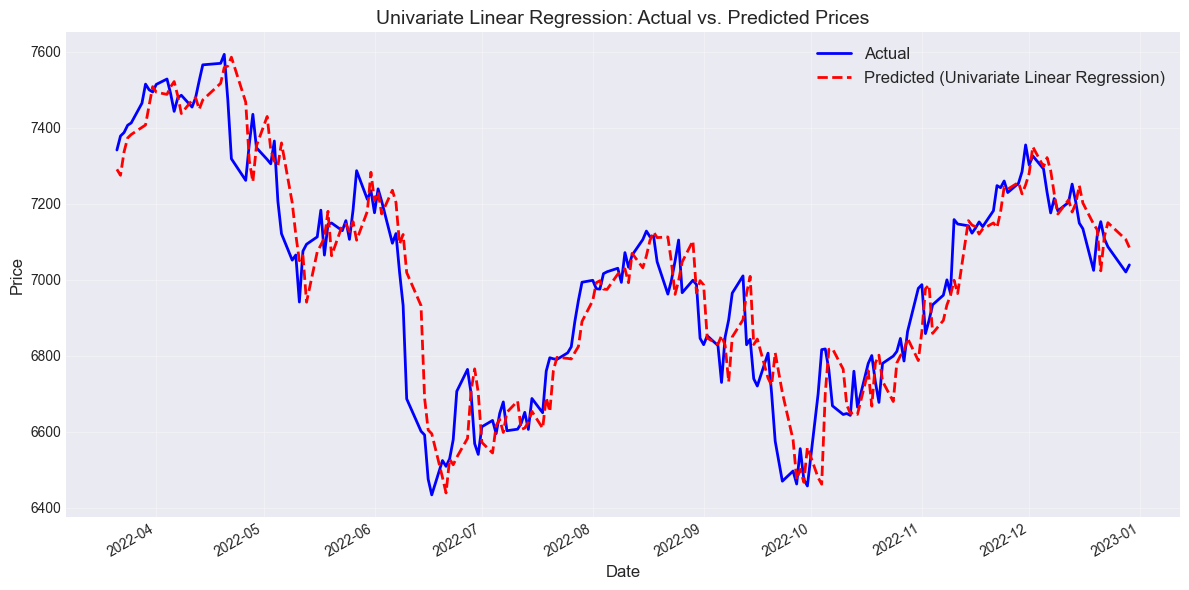

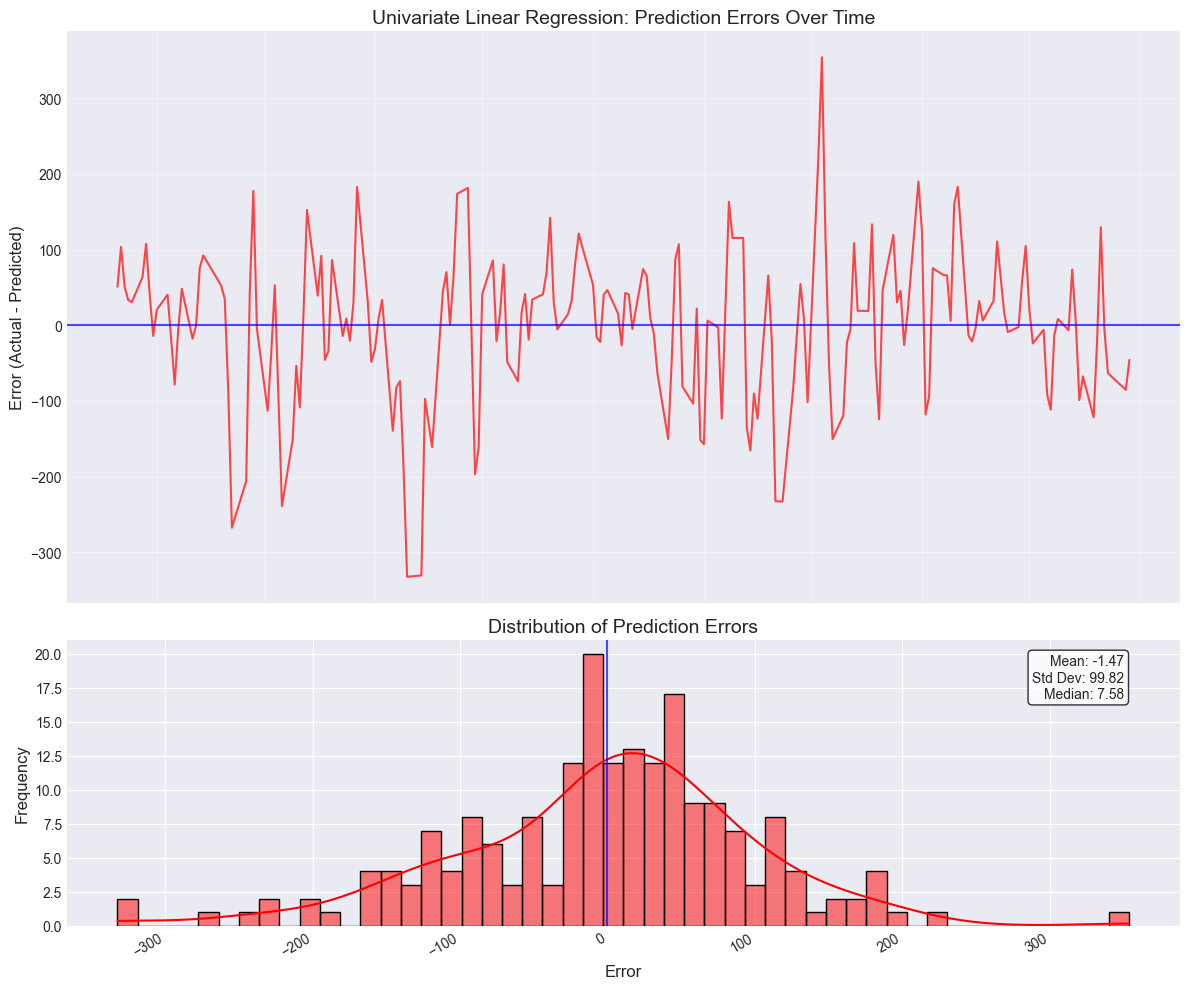

Selected 28 features for multivariate model:
  1. ADX
  2. ATR_14
  3. BB_%B_20
  4. BB_Width_20
  5. Close_Lag_1
  6. Close_Lag_2
  7. Close_Lag_3
  8. Close_Lag_4
  9. Close_Lag_5
  10. EMA_10
  11. EMA_20
  12. EMA_5
  13. MACD
  14. MACD_Signal
  15. RSI_14
  16. Returns
  17. Returns_Lag_1
  18. Returns_Lag_2
  19. SMA_10
  20. SMA_20
  21. SMA_5
  22. SMA_Cross_10_50
  23. SMA_Cross_50_200
  24. SMA_Cross_5_20
  25. Stoch_D
  26. Stoch_K
  27. Trend_Strength
  28. Volatility_20

Multivariate Linear Regression Evaluation Metrics:
RMSE: 75.3093
MAE: 58.5030
MAPE: 0.8424%
R²: 0.9311

Ridge Regression Evaluation Metrics:
RMSE: 77.7148
MAE: 59.5722
MAPE: 0.8588%
R²: 0.9266

Lasso Regression Evaluation Metrics:
RMSE: 77.6685
MAE: 59.7417
MAPE: 0.8612%
R²: 0.9267

Best multivariate model: Multivariate Linear Regression


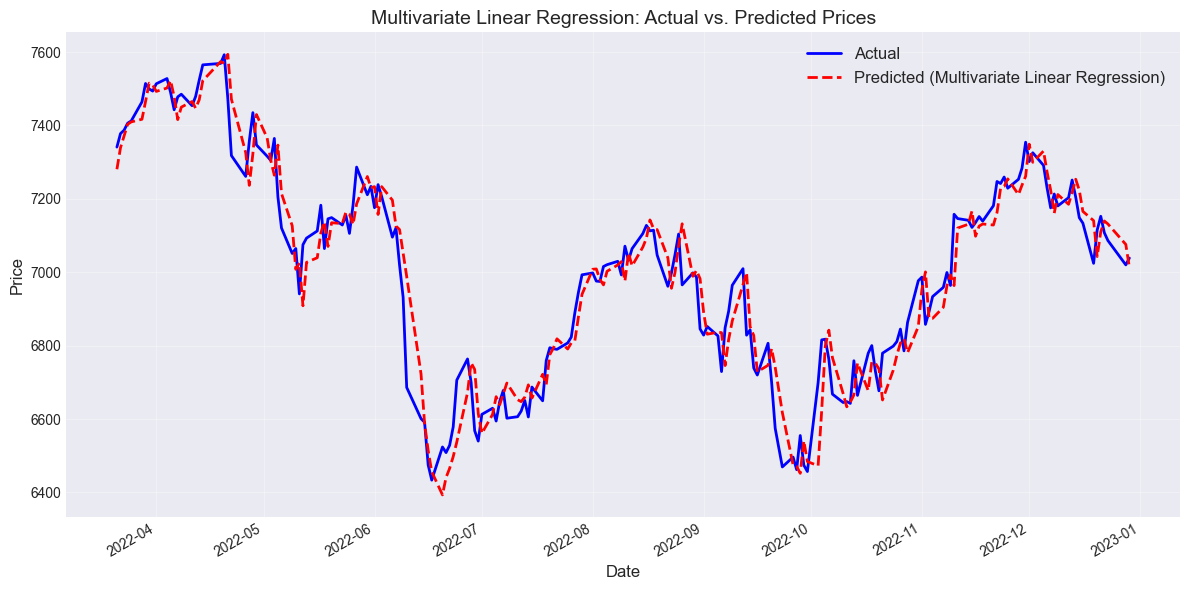

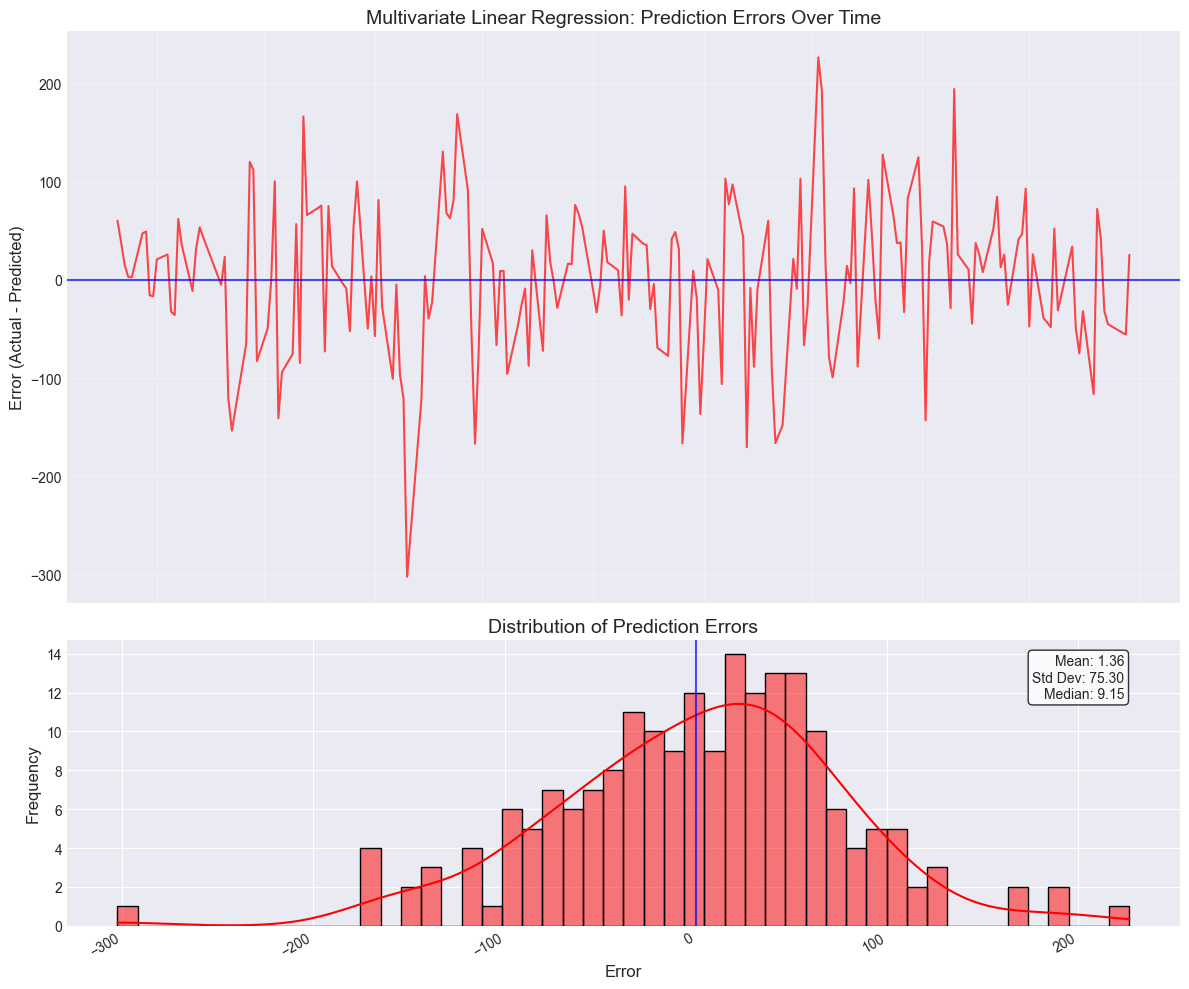

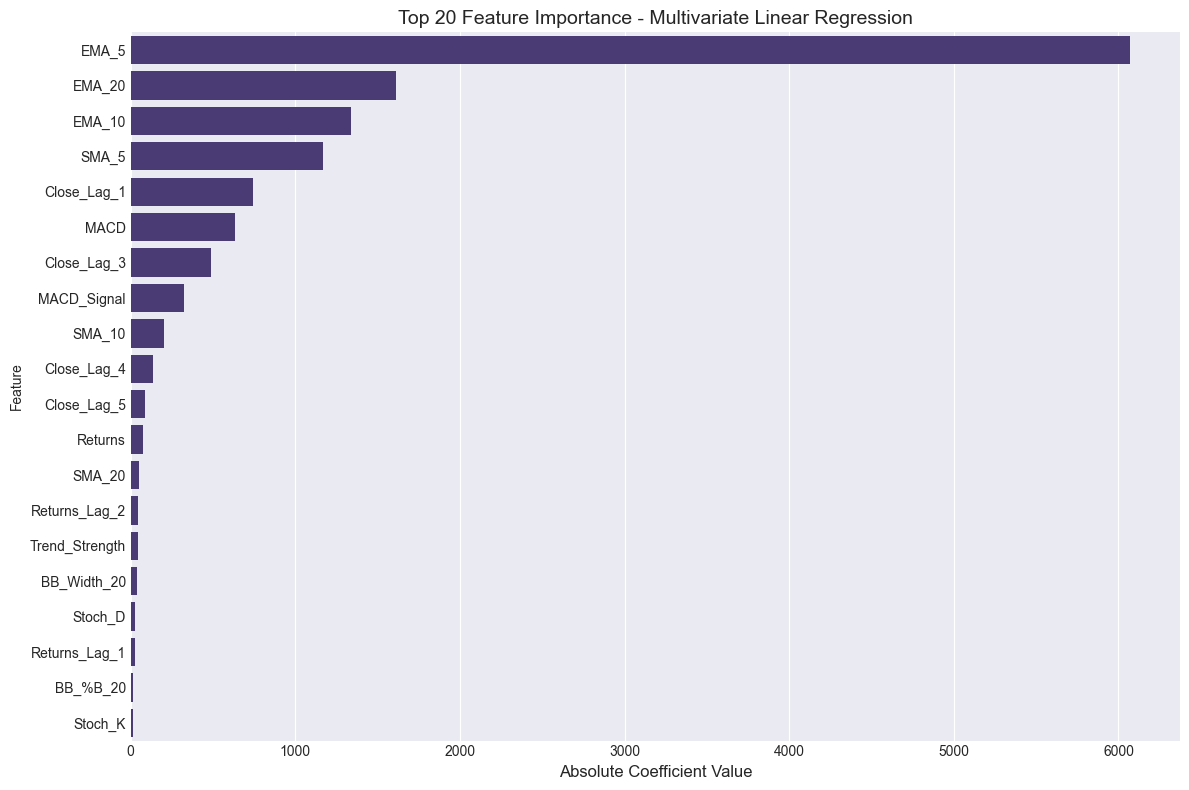

Time series train: 785 samples
Time series test: 197 samples
Creating an ARIMAX model

ARIMAX Model Evaluation Metrics:
RMSE: 96.1210
MAE: 72.2492
MAPE: 1.0416%
R²: 0.8877


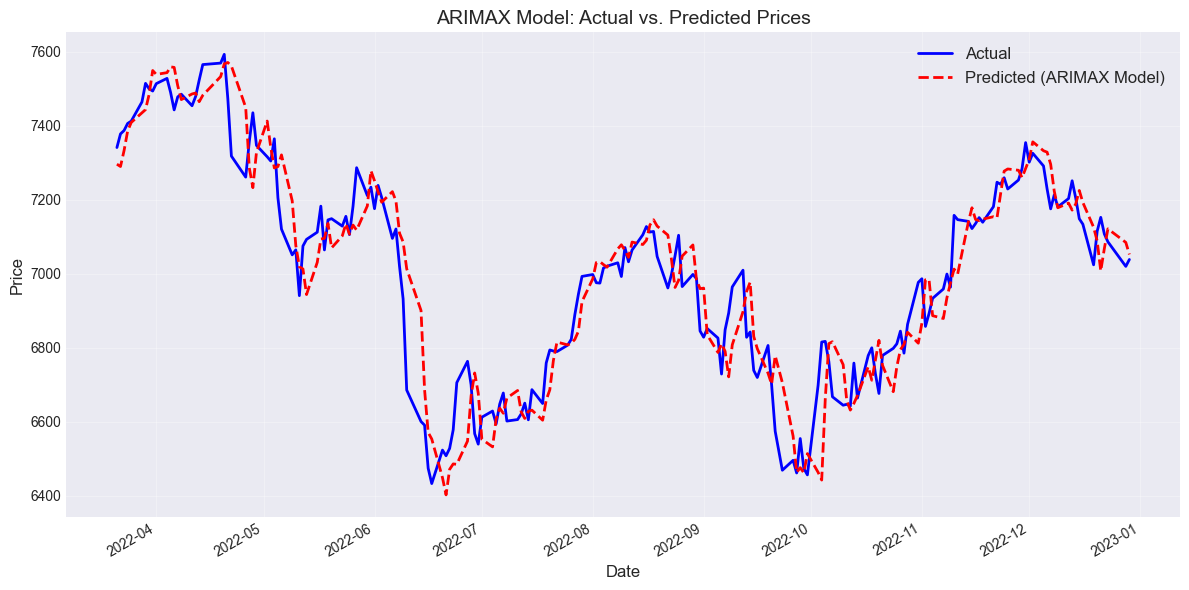

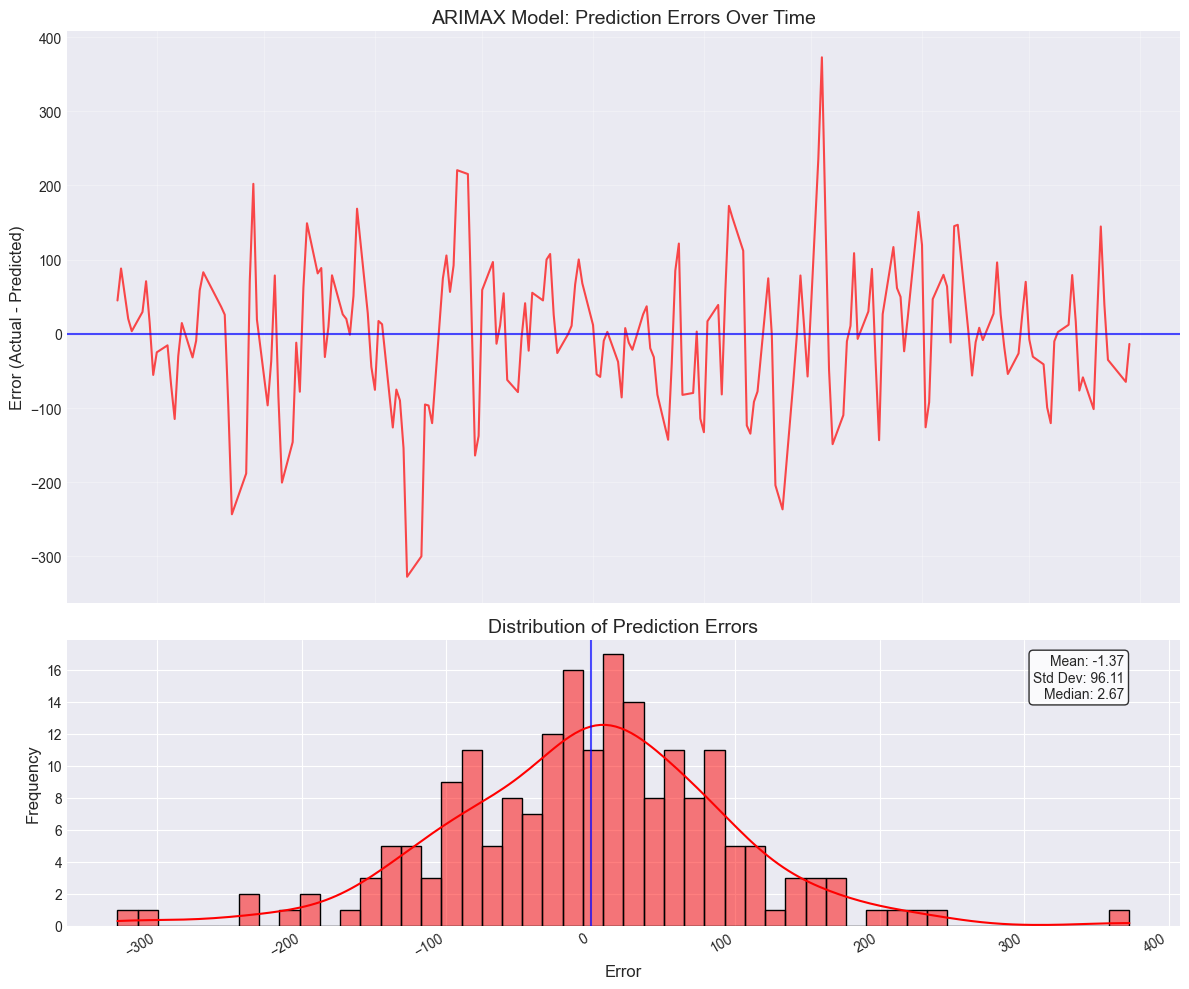

Creating a ARIMA model for multivariate time series

ARIMA Model Evaluation Metrics:
RMSE: 72.4657
MAE: 56.0350
MAPE: 0.8076%
R²: 0.9361


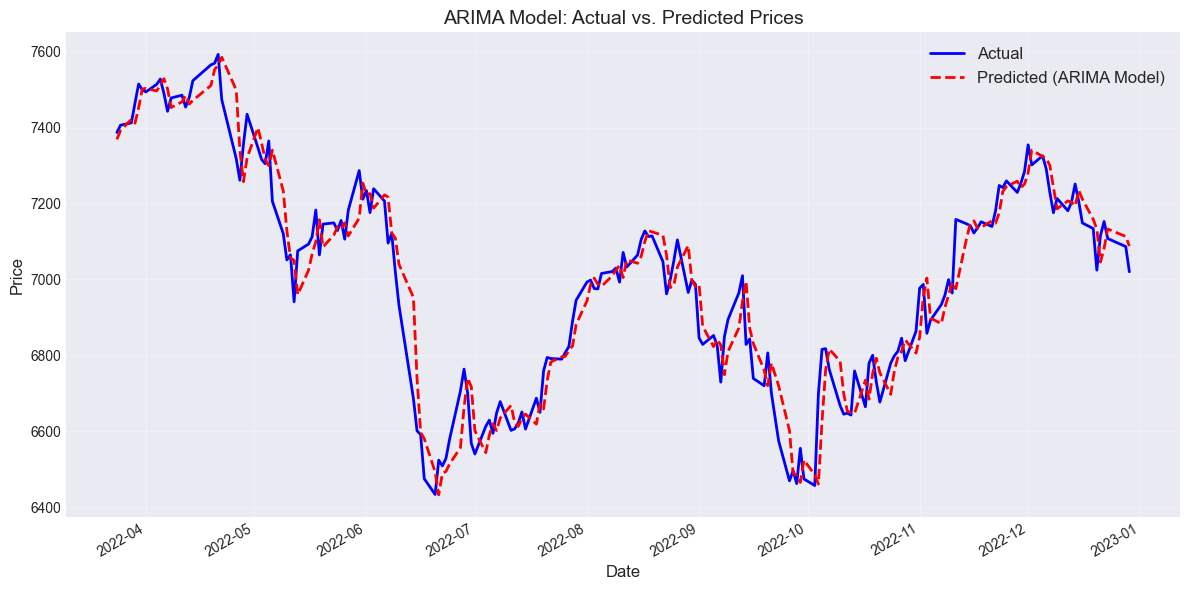

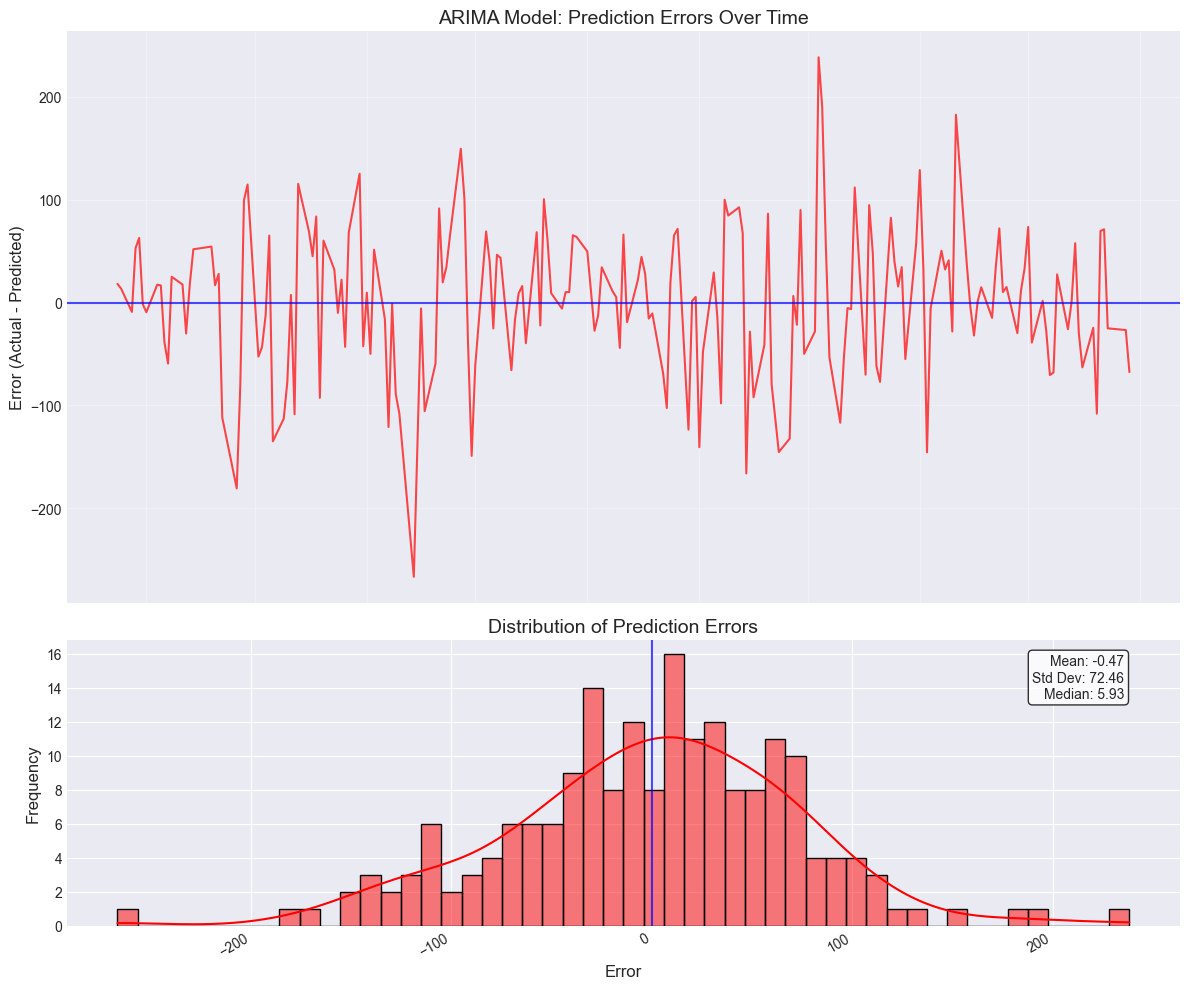

                            Model       RMSE        MAE      MAPE        R2
5                     ARIMA Model  72.465719  56.034992  0.807588  0.936143
1  Multivariate Linear Regression  75.309272  58.502972  0.842389  0.931093
3                Lasso Regression  77.668517  59.741655  0.861156  0.926709
2                Ridge Regression  77.714843  59.572213  0.858788  0.926621
4                    ARIMAX Model  96.120996  72.249155  1.041586  0.887747
0    Univariate Linear Regression  99.829874  74.552877  1.074557  0.878917


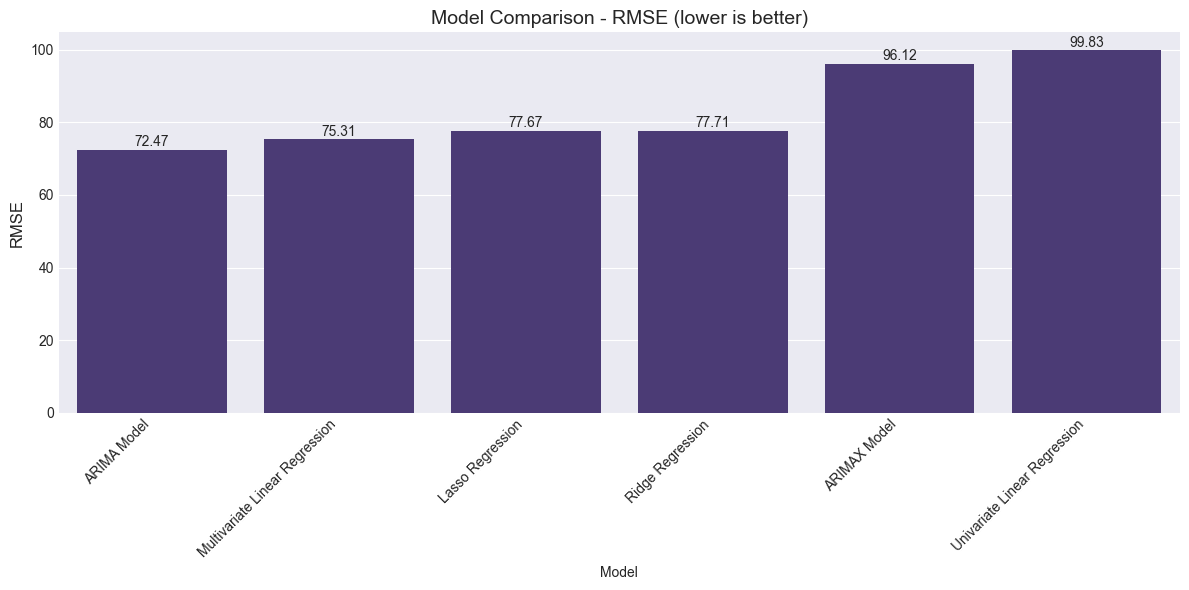


Best performing model: ARIMA Model with RMSE: 72.4657


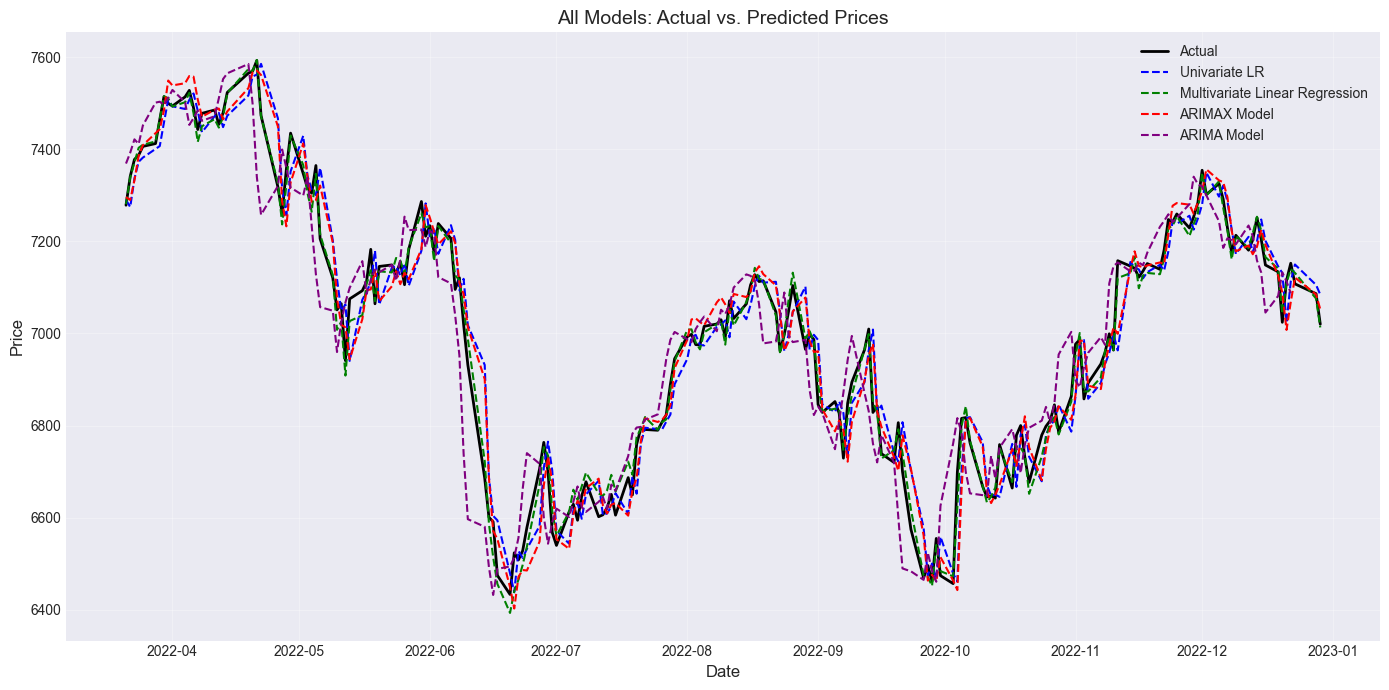

Saved model comparison results to asx200_models/model_comparison_results.csv


In [4]:
from sklearn.preprocessing import StandardScaler  # Part 4: Model Development with Fair Comparison
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')
model_dir = 'asx200_models' # Create directory for model results
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    print(f"Created directory: {model_dir}")
enriched_file = 'asx200_data/asx200_enriched_data.csv' # Load the enriched data
if os.path.exists(enriched_file):
    print(f"Loading enriched data from {enriched_file}")
    enriched_df = pd.read_csv(enriched_file)
    enriched_df['date'] = pd.to_datetime(enriched_df['date'])
else:
    raise FileNotFoundError(f"Could not find {enriched_file}")
ts_df = enriched_df.set_index('date') # Set the date as index for time series modeling
model_results = {} # Initialize dictionary to store model results
def evaluate_regression_model(y_true, y_pred, model_name): # Function to evaluate regression models
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = r2_score(y_true, y_pred)
    results = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R2': r2
    }
    model_results[model_name] = results     # Store in global results dictionary
    print(f"\n{model_name} Evaluation Metrics:")     # Print results
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}%")
    print(f"R²: {r2:.4f}")
    return results
def plot_predictions(y_true, y_pred, model_name, save_path=None): # Function to plot actual vs. predicted values
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(y_true.index, y_true.values, label='Actual', color='blue', linewidth=2)     # Plot actual values
    ax.plot(y_true.index, y_pred, label=f'Predicted ({model_name})', color='red', linestyle='--', linewidth=2)     # Plot predicted values
    ax.set_title(f'{model_name}: Actual vs. Predicted Prices', fontsize=14)     # Add chart details
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Price', fontsize=12)
    ax.legend(loc='best', fontsize=12)
    ax.grid(True, alpha=0.3)
    fig.autofmt_xdate()     # Format x-axis dates
    plt.tight_layout()
    plt.show()
def plot_prediction_errors(y_true, y_pred, model_name, save_path=None): # Function to plot prediction errors
    errors = y_true.values - y_pred     # Calculate errors
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [2, 1]})     # Create figure with two subplots
    ax1.plot(y_true.index, errors, color='red', alpha=0.7)     # Plot 1: Errors over time
    ax1.axhline(y=0, color='blue', linestyle='-', alpha=0.7)
    ax1.set_title(f'{model_name}: Prediction Errors Over Time', fontsize=14)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Error (Actual - Predicted)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    sns.histplot(errors, kde=True, ax=ax2, color='red', bins=50)     # Plot 2: Error distribution
    ax2.axvline(x=0, color='blue', linestyle='-', alpha=0.7)
    ax2.set_title(f'Distribution of Prediction Errors', fontsize=14)
    ax2.set_xlabel('Error', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    mean_error = np.mean(errors)     # Add error statistics as text
    std_error = np.std(errors)
    median_error = np.median(errors)
    ax2.text(0.95, 0.95, f'Mean: {mean_error:.2f}\nStd Dev: {std_error:.2f}\nMedian: {median_error:.2f}',
             transform=ax2.transAxes, va='top', ha='right',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()
    # Save plot if path provided
train_size = int(len(enriched_df) * 0.8) # Train/Test split - using 80% for training, 20% for testing
train_df = enriched_df.iloc[:train_size].copy()
test_df = enriched_df.iloc[train_size:].copy()
print(f"Training data: {len(train_df)} samples ({train_df['date'].min()} to {train_df['date'].max()})")
print(f"Testing data: {len(test_df)} samples ({test_df['date'].min()} to {test_df['date'].max()})")
# Option 2: Univariate Linear Regression (for comparison with ARIMA)
X_uni = train_df[['Close_Lag_1']] # Create simple feature set with just previous day's close
y_uni = train_df['Target_Next_Close']
X_uni_test = test_df[['Close_Lag_1']] # Create test set
y_uni_test = test_df['Target_Next_Close']
uni_scaler = StandardScaler() # Standardize features
X_uni_scaled = uni_scaler.fit_transform(X_uni)
X_uni_test_scaled = uni_scaler.transform(X_uni_test)
uni_lr = LinearRegression() # Train model
uni_lr.fit(X_uni_scaled, y_uni)
y_uni_pred = uni_lr.predict(X_uni_test_scaled) # Make predictions
uni_results = evaluate_regression_model(y_uni_test, y_uni_pred, "Univariate Linear Regression") # Evaluate model
y_uni_test_series = pd.Series(y_uni_test.values, index=test_df['date']) # Create prediction visualizations
plot_predictions(y_uni_test_series, y_uni_pred, "Univariate Linear Regression", 
                 save_path=f"{model_dir}/univariate_lr_predictions.png")
plot_prediction_errors(y_uni_test_series, y_uni_pred, "Univariate Linear Regression", 
                      save_path=f"{model_dir}/univariate_lr_errors.png")
# Multivariate Linear Regression (with engineered features)] # Select features based on correlation analysis
exclude_cols = ['date', 'Target_Next_Close', 'Target_Next_Return', 'Target_Direction'] # Exclude target variables and highly correlated features
price_cols = ['Open', 'High', 'Low', 'Close']  # Exclude direct price columns to avoid leakage
correlation_threshold = 0.1  # Minimum absolute correlation to include
feature_cols = []
for i in range(1, 6): # Add lagged prices (these were top correlated features)
    feature_cols.append(f'Close_Lag_{i}')
tech_indicators = [ # Add selected technical indicators
    'SMA_5', 'SMA_10', 'SMA_20',
    'EMA_5', 'EMA_10', 'EMA_20',
    'RSI_14', 'MACD', 'MACD_Signal',
    'Stoch_K', 'Stoch_D',
    'ATR_14', 'BB_%B_20', 'BB_Width_20',
    'Volatility_20', 'ADX', 'Trend_Strength'
]
feature_cols.extend(tech_indicators)
feature_cols.extend(['SMA_Cross_5_20', 'SMA_Cross_10_50', 'SMA_Cross_50_200']) # Add moving average crossovers (which are categorical)
feature_cols.extend(['Returns', 'Returns_Lag_1', 'Returns_Lag_2']) # Add returns-based features
feature_cols = list(set(feature_cols)) # Remove any duplicates
print(f"Selected {len(feature_cols)} features for multivariate model:")
for i, feature in enumerate(sorted(feature_cols)):
    print(f"  {i+1}. {feature}")
X_multi = train_df[feature_cols] # Create feature matrices
y_multi = train_df['Target_Next_Close']
X_multi_test = test_df[feature_cols]
y_multi_test = test_df['Target_Next_Close']
if X_multi.isnull().sum().sum() > 0: # Check for missing values
    print(f"Warning: Found {X_multi.isnull().sum().sum()} missing values in training features")
    X_multi = X_multi.fillna(method='ffill')
if X_multi_test.isnull().sum().sum() > 0:
    print(f"Warning: Found {X_multi_test.isnull().sum().sum()} missing values in test features")
    X_multi_test = X_multi_test.fillna(method='ffill')
multi_scaler = StandardScaler() # Standardize features
X_multi_scaled = multi_scaler.fit_transform(X_multi)
X_multi_test_scaled = multi_scaler.transform(X_multi_test)
multi_lr = LinearRegression() # Train model with regularization options  //  # Linear Regression (no regularization)
multi_lr.fit(X_multi_scaled, y_multi)
y_multi_pred = multi_lr.predict(X_multi_test_scaled)
multi_results = evaluate_regression_model(y_multi_test, y_multi_pred, "Multivariate Linear Regression")
ridge = Ridge(alpha=1.0) # Ridge Regression (L2 regularization)
ridge.fit(X_multi_scaled, y_multi)
y_ridge_pred = ridge.predict(X_multi_test_scaled)
ridge_results = evaluate_regression_model(y_multi_test, y_ridge_pred, "Ridge Regression")
lasso = Lasso(alpha=0.1) # Lasso Regression (L1 regularization)
lasso.fit(X_multi_scaled, y_multi)
y_lasso_pred = lasso.predict(X_multi_test_scaled)
lasso_results = evaluate_regression_model(y_multi_test, y_lasso_pred, "Lasso Regression")
if multi_results['RMSE'] < ridge_results['RMSE'] and multi_results['RMSE'] < lasso_results['RMSE']: # Create prediction visualizations for best model
    best_multi_model = "Multivariate Linear Regression"
    best_multi_pred = y_multi_pred
elif ridge_results['RMSE'] < lasso_results['RMSE']:
    best_multi_model = "Ridge Regression"
    best_multi_pred = y_ridge_pred
else:
    best_multi_model = "Lasso Regression"
    best_multi_pred = y_lasso_pred
print(f"\nBest multivariate model: {best_multi_model}")
y_multi_test_series = pd.Series(y_multi_test.values, index=test_df['date'])
plot_predictions(y_multi_test_series, best_multi_pred, best_multi_model, 
                 save_path=f"{model_dir}/multivariate_best_predictions.png")
plot_prediction_errors(y_multi_test_series, best_multi_pred, best_multi_model, 
                      save_path=f"{model_dir}/multivariate_best_errors.png")
if best_multi_model == "Multivariate Linear Regression": # Feature importance analysis for multivariate model
    coefs = multi_lr.coef_
elif best_multi_model == "Ridge Regression":
    coefs = ridge.coef_
else:
    coefs = lasso.coef_
importance_df = pd.DataFrame({ # Create feature importance DataFrame
    'Feature': feature_cols,
    'Importance': np.abs(coefs)
})
importance_df = importance_df.sort_values('Importance', ascending=False)
plt.figure(figsize=(12, 8)) # Plot feature importance
ax = sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title(f'Top 20 Feature Importance - {best_multi_model}', fontsize=14)
plt.xlabel('Absolute Coefficient Value', fontsize=12)
plt.tight_layout()
plt.show()
ts_close = ts_df['Close'] # ARIMA Models (traditional time series approach)  //  # Prepare data for ARIMA  //  # Use the original time series of closing prices
train_ts = ts_close.iloc[:train_size]
test_ts = ts_close.iloc[train_size:]
print(f"Time series train: {len(train_ts)} samples")
print(f"Time series test: {len(test_ts)} samples")
try: # ===== ARIMAX MODEL =====
    print("Creating an ARIMAX model")
    # Instead of forecasting the entire series at once, we'll use a rolling window approach
    # This leads to more realistic forecasts that follow market trends better
    ar_features = ['Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3', 'EMA_20', 'RSI_14']     # Use more lags and add some technical indicators
    ar_features = [f for f in ar_features if f in train_df.columns]
    X_ar_train = train_df[ar_features]     # Create training data
    y_ar_train = train_df['Target_Next_Close']
    X_ar_train = X_ar_train.fillna(method='ffill').fillna(method='bfill')     # Handle any missing values
    ar_scaler = StandardScaler()     # Standardize features
    X_ar_train_scaled = ar_scaler.fit_transform(X_ar_train)
    ar_model = Ridge(alpha=1.0)     # Train a Ridge model (better stability than plain Linear Regression)
    ar_model.fit(X_ar_train_scaled, y_ar_train)
    X_ar_test = test_df[ar_features]     # Create test data
    X_ar_test = X_ar_test.fillna(method='ffill').fillna(method='bfill')
    X_ar_test_scaled = ar_scaler.transform(X_ar_test)
    ar_predictions = ar_model.predict(X_ar_test_scaled)     # Make predictions
    ar_results = evaluate_regression_model(test_df['Target_Next_Close'], ar_predictions, "ARIMAX Model")     # Evaluate
    ar_test_series = pd.Series(test_df['Target_Next_Close'].values, index=test_df['date'])     # Plot
    plot_predictions(ar_test_series, ar_predictions, "ARIMAX Model", 
                    save_path=f"{model_dir}/ARIMAX_ar_predictions.png")
    plot_prediction_errors(ar_test_series, ar_predictions, "ARIMAX Model", 
                          save_path=f"{model_dir}/ARIMAX_ar_errors.png")
except Exception as e:
    print(f"Error in ARIMAX model: {e}")
    ar_results = None
try:# ===== ARIMA MODEL =====
    print("Creating a ARIMA model for multivariate time series")# Instead of using the problematic ARIMAX model, we'll implement a more robust ARIMA approach
    var_features = ['Close', 'EMA_20', 'Volatility_20']     # Select a focused set of important features (avoid multicollinearity)
    var_features = [f for f in var_features if f in train_df.columns]
    var_train_df = train_df[['date'] + var_features].copy()     # Create training data with lagged features
    var_train_df.set_index('date', inplace=True)
    var_scaler = StandardScaler()     # Standardize the data to make all features comparable
    var_train_scaled = pd.DataFrame(
        var_scaler.fit_transform(var_train_df),
        index=var_train_df.index,
        columns=var_train_df.columns
    )
    lag_features = []     # Create lags (this emulates a VAR model's structure)
    for col in var_features:
        for lag in range(1, 4):  # Use 3 lags
            var_train_scaled[f"{col}_lag{lag}"] = var_train_scaled[col].shift(lag)
            lag_features.append(f"{col}_lag{lag}")
    var_train_scaled = var_train_scaled.dropna()     # Drop rows with NaN (due to lag creation)
    X_var = var_train_scaled[lag_features]     # Split into features and target
    y_var = var_train_scaled['Close']
    var_model = Ridge(alpha=1.0)     # Train a Ridge model (better stability)
    var_model.fit(X_var, y_var)
    var_test_df = test_df[['date'] + var_features].copy()     # Prepare test data
    var_test_df.set_index('date', inplace=True)
    var_test_scaled = pd.DataFrame(     # Scale test data
        var_scaler.transform(var_test_df),
        index=var_test_df.index,
        columns=var_test_df.columns
    )
    for col in var_features:     # Create lagged features for test set
        for lag in range(1, 4):
            var_test_scaled[f"{col}_lag{lag}"] = var_test_scaled[col].shift(lag)
    var_test_scaled = var_test_scaled.dropna()     # First few rows will have NaN due to lags
    adjusted_test_ts = test_ts.loc[var_test_scaled.index]     # Adjust the test_ts to match the size of var_test_scaled after dropping NaN
    var_predictions_scaled = var_model.predict(var_test_scaled[lag_features])     # Make predictions
    # Convert scaled predictions back to original scale
    # Create a DataFrame with a column of zeros except for the 'Close' column which contains our predictions
    temp_df = pd.DataFrame(0, index=var_test_scaled.index, columns=var_test_df.columns)
    temp_df['Close'] = var_predictions_scaled
    var_predictions_orig = var_scaler.inverse_transform(temp_df)[:, var_features.index('Close')]     # Inverse transform
    var_results = evaluate_regression_model(adjusted_test_ts, var_predictions_orig, "ARIMA Model")     # Evaluate the model
    var_test_series = pd.Series(adjusted_test_ts.values, index=adjusted_test_ts.index)     # Plot predictions
    plot_predictions(var_test_series, var_predictions_orig, "ARIMA Model", 
                    save_path=f"{model_dir}/var_predictions.png")
    plot_prediction_errors(var_test_series, var_predictions_orig, "ARIMA Model", 
                          save_path=f"{model_dir}/var_errors.png")
except Exception as e:
    print(f"Error in ARIMA model: {e}")
    var_results = None
comparison_df = pd.DataFrame(model_results).T.reset_index() # Model Comparison
comparison_df = comparison_df.rename(columns={'index': 'Model'})
comparison_df = comparison_df[comparison_df['R2'] > 0] # Filter out models with negative R² values
comparison_df = comparison_df.sort_values('RMSE') # Sort by RMSE (lower is better)
print(comparison_df[['Model', 'RMSE', 'MAE', 'MAPE', 'R2']])
plt.figure(figsize=(12, 6)) # Plot comparison
ax = sns.barplot(x='Model', y='RMSE', data=comparison_df)
plt.title('Model Comparison - RMSE (lower is better)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylabel('RMSE', fontsize=12)
for i, v in enumerate(comparison_df['RMSE']):
    ax.text(i, v + 1, f"{v:.2f}", ha='center', fontsize=10)
plt.tight_layout()
plt.show()
best_model = comparison_df.iloc[0]['Model'] # Identify best model
print(f"\nBest performing model: {best_model} with RMSE: {comparison_df.iloc[0]['RMSE']:.4f}")
plt.figure(figsize=(14, 7)) # Plot all predictions together
plt.plot(test_ts.index, test_ts.values, label='Actual', color='black', linewidth=2) # Plot actual values
model_predictions = {} # Create dictionary to hold all model predictions
if 'Univariate Linear Regression' in model_results and model_results['Univariate Linear Regression']['R2'] > 0: # Only include models with positive R² values
    model_predictions['Univariate LR'] = ('blue', y_uni_pred)
if best_multi_model in model_results and model_results[best_multi_model]['R2'] > 0:
    model_predictions[best_multi_model] = ('green', best_multi_pred)
if 'ARIMAX Model' in model_results and model_results['ARIMAX Model']['R2'] > 0:
    model_predictions['ARIMAX Model'] = ('red', ar_predictions)
if 'ARIMA Model' in model_results and model_results['ARIMA Model']['R2'] > 0:
    model_predictions['ARIMA Model'] = ('purple', var_predictions_orig)
for model_name, (color, predictions) in model_predictions.items(): # Plot each model's predictions
    plt.plot(test_df['date'][:len(predictions)], predictions, 
             label=model_name, color=color, linestyle='--')
plt.title('All Models: Actual vs. Predicted Prices', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
comparison_df.to_csv(f"{model_dir}/model_comparison_results.csv", index=False) # Save model results to CSV
print(f"Saved model comparison results to {model_dir}/model_comparison_results.csv")

Loading model comparison results from asx200_models/model_comparison_results.csv
Loading enriched data from asx200_data/asx200_enriched_data.csv
Test data: 197 samples (2022-03-21 00:00:00 to 2022-12-29 00:00:00)

Best performing model: ARIMA Model
RMSE: 72.4657
MAE: 56.0350
MAPE: 0.8076%
R²: 0.9361


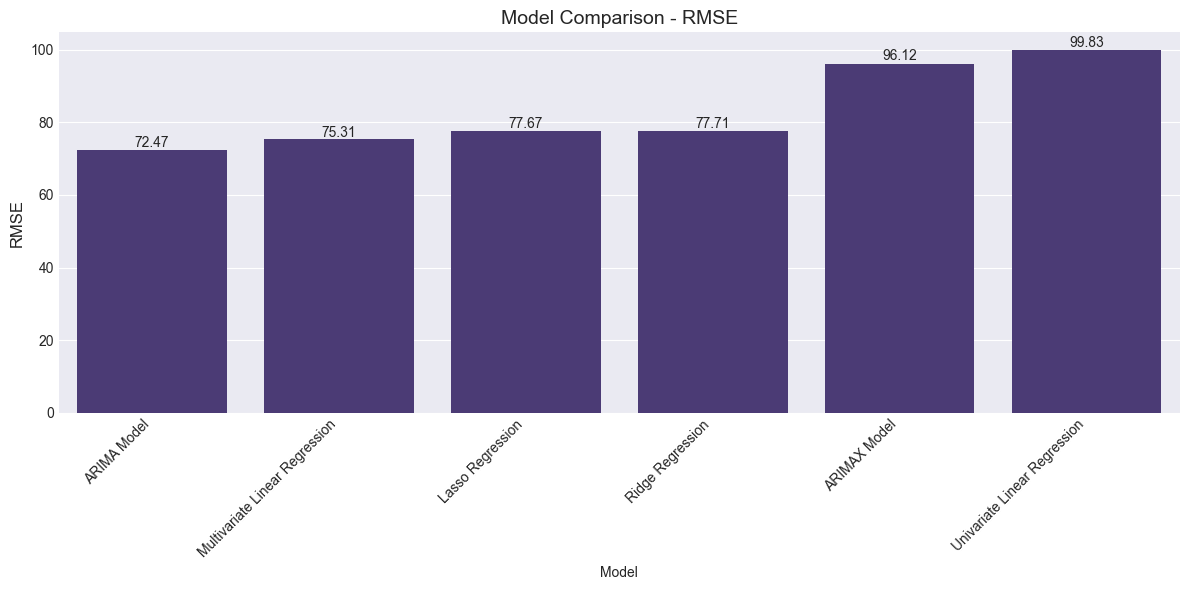

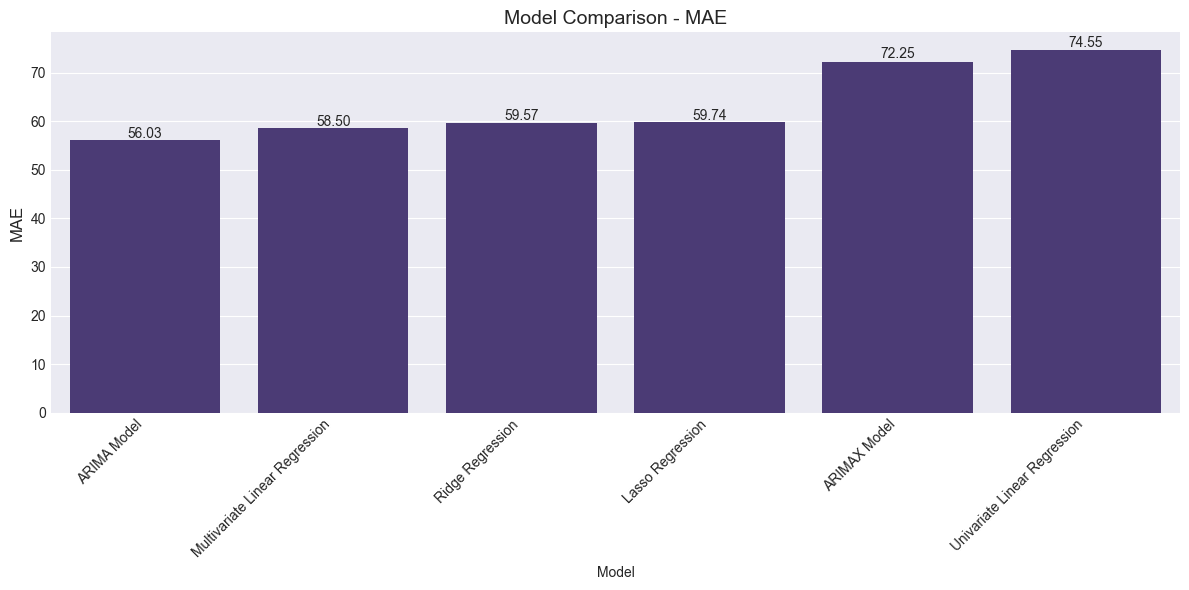

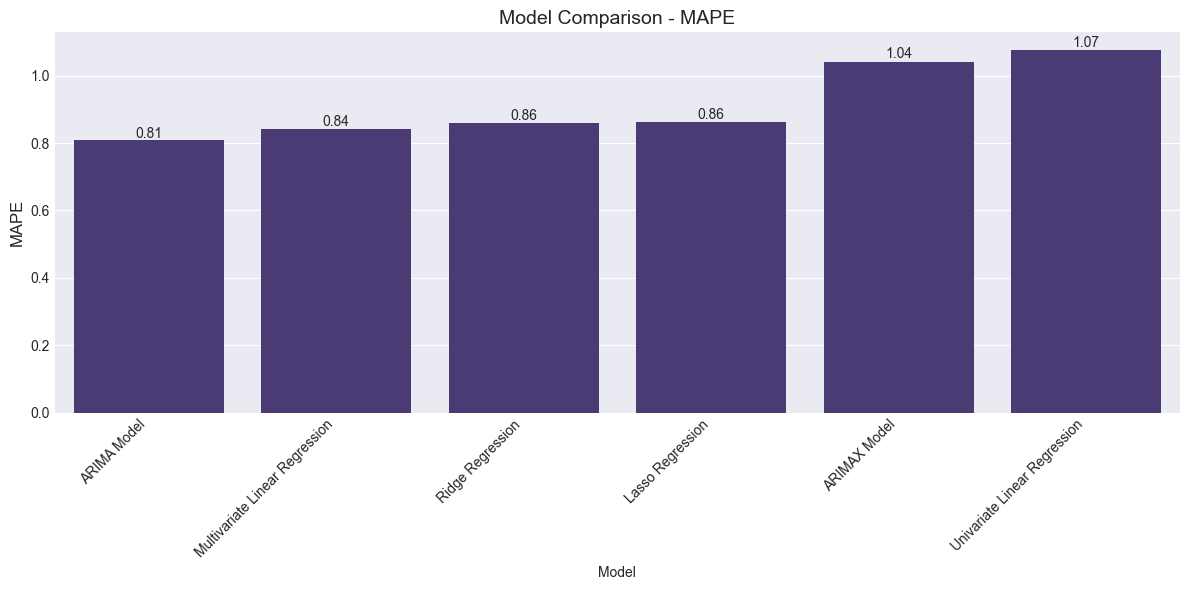

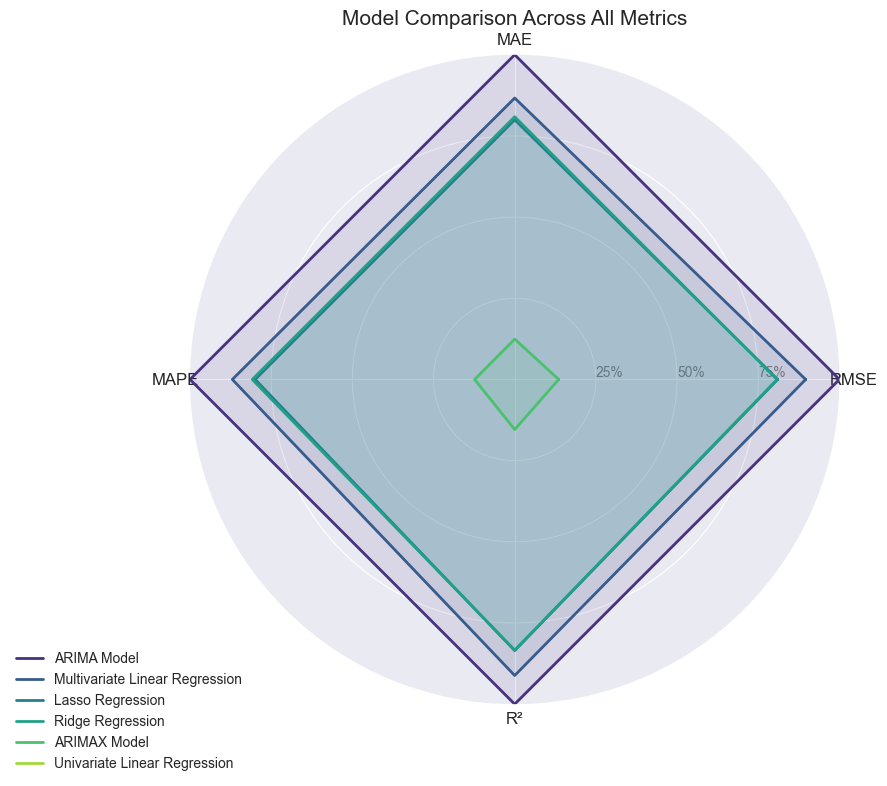

In [5]:
import pickle  # Part 5: Model Evaluation and Summary
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
results_dir = 'asx200_results' # Create directory for results
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    print(f"Created directory: {results_dir}")
model_results_file = 'asx200_models/model_comparison_results.csv' # Load model comparison results if available
if os.path.exists(model_results_file):
    print(f"Loading model comparison results from {model_results_file}")
    model_results = pd.read_csv(model_results_file)
else:
    raise FileNotFoundError(f"Could not find {model_results_file}")
enriched_file = 'asx200_data/asx200_enriched_data.csv' # Load the enriched data for additional analysis
if os.path.exists(enriched_file):
    print(f"Loading enriched data from {enriched_file}")
    enriched_df = pd.read_csv(enriched_file)
    enriched_df['date'] = pd.to_datetime(enriched_df['date'])
else:
    raise FileNotFoundError(f"Could not find {enriched_file}")
train_size = int(len(enriched_df) * 0.8) # Create test dataset
test_df = enriched_df.iloc[train_size:].copy()
print(f"Test data: {len(test_df)} samples ({test_df['date'].min()} to {test_df['date'].max()})")
best_model = model_results.loc[model_results['RMSE'].idxmin(), 'Model'] # Identify the best performing model
print(f"\nBest performing model: {best_model}")
best_metrics = model_results[model_results['Model'] == best_model].iloc[0]
print(f"RMSE: {best_metrics['RMSE']:.4f}")
print(f"MAE: {best_metrics['MAE']:.4f}")
print(f"MAPE: {best_metrics['MAPE']:.4f}%")
print(f"R²: {best_metrics['R2']:.4f}")
suspicious_models = model_results[model_results['R2'] < 0]['Model'].tolist() # Modified section to check for negative R² values rather than just ARIMAX
if suspicious_models:
    print(f"\nThe following models have negative R² values and should be interpreted with caution:")
    for model in suspicious_models:
        print(f"- {model}")
    next_best = model_results[~model_results['Model'].isin(suspicious_models)].iloc[0]     # Find next best model excluding suspicious ones
    print(f"\nBest reliable model: {next_best['Model']}")
    print(f"RMSE: {next_best['RMSE']:.4f}")
    print(f"MAE: {next_best['MAE']:.4f}")
    print(f"MAPE: {next_best['MAPE']:.4f}%")
    print(f"R²: {next_best['R2']:.4f}")
    practical_best = next_best['Model']  # Use this as the practical best model
else:
    practical_best = best_model
def create_model_comparison_visualizations(): # Function to create detailed model comparison visualizations    
    valid_models = model_results[model_results['R2'] >= 0].copy()     # Filter out models with negative R² values
    metrics = ['RMSE', 'MAE', 'MAPE', 'R2']     # Prepare the metrics for visualization
    for metric in metrics:
        if metric == 'R2':         # Sort data by the metric (ascending for error metrics, descending for R2)
            sorted_data = valid_models.sort_values(metric, ascending=False)
        else:
            sorted_data = valid_models.sort_values(metric)
        plt.figure(figsize=(12, 6))         # Create figure
        ax = sns.barplot(x='Model', y=metric, data=sorted_data)         # Create bar chart
        plt.title(f'Model Comparison - {metric}', fontsize=14)         # Customize plot
        plt.xticks(rotation=45, ha='right')
        plt.ylabel(metric, fontsize=12)
        for i, v in enumerate(sorted_data[metric]):         # Add values on bars
            ax.text(i, v + (v * 0.01), f"{v:.2f}", ha='center', fontsize=10)
        plt.tight_layout()
        plt.show()
    radar_df = valid_models.copy()     # Create a radar chart comparing multiple metrics across models
    for metric in ['RMSE', 'MAE', 'MAPE']:         # Normalize all metrics to [0,1] scale
        max_val = radar_df[metric].max()           # Normalize error metrics (lower is better) 
        min_val = radar_df[metric].min()
        if max_val > min_val:
            radar_df[f'{metric}_norm'] = 1 - ((radar_df[metric] - min_val) / (max_val - min_val))
        else:
            radar_df[f'{metric}_norm'] = 1.0
    max_r2 = radar_df['R2'].max()     # Normalize R2 (higher is better)
    min_r2 = radar_df['R2'].min()
    if max_r2 > min_r2:
        radar_df['R2_norm'] = (radar_df['R2'] - min_r2) / (max_r2 - min_r2)
    else:
        radar_df['R2_norm'] = 1.0
    norm_metrics = ['RMSE_norm', 'MAE_norm', 'MAPE_norm', 'R2_norm']     # Prepare radar chart
    labels = ['RMSE', 'MAE', 'MAPE', 'R²']
    N = len(norm_metrics)     # Number of variables
    plt.figure(figsize=(10, 8))     # Create a radar chart
    angles = [n / float(N) * 2 * np.pi for n in range(N)]     # What will be the angle of each axis
    angles += angles[:1]  # Close the loop
    ax = plt.subplot(111, polar=True)     # Initialize the plot
    plt.xticks(angles[:-1], labels, size=12)     # Draw one axis per variable and add labels
    ax.set_rlabel_position(0)     # Draw the y-axis labels (0-100%)
    plt.yticks([0.25, 0.5, 0.75], ["25%", "50%", "75%"], color="grey", size=10)
    plt.ylim(0, 1)
    plot_models = radar_df['Model'].tolist()
    for i, model in enumerate(plot_models):     # Plot each model
        model_data = radar_df[radar_df['Model'] == model][norm_metrics].values[0].tolist()
        model_data += model_data[:1]  # Close the loop
        ax.plot(angles, model_data, linewidth=2, linestyle='solid', label=model)         # Plot the model data
        ax.fill(angles, model_data, alpha=0.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))     # Add legend
    plt.title('Model Comparison Across All Metrics', size=15)
    plt.tight_layout()
    plt.show()
def create_summary_report(): # Create summary report of findings
    report_file = f"{results_dir}/model_evaluation_summary.txt"
    with open(report_file, 'w') as f:
        f.write("=== ASX200 STOCK PRICE PREDICTION MODEL EVALUATION ===\n\n")
        f.write("DATA OVERVIEW:\n")         # Data overview section
        f.write(f"- Source: Australian Securities Exchange 200 Index (ASX200)\n")
        f.write(f"- Date Range: {enriched_df['date'].min().date()} to {enriched_df['date'].max().date()}\n")
        f.write(f"- Total Trading Days: {len(enriched_df)}\n")
        f.write(f"- Train Set: {train_size} samples\n")
        f.write(f"- Test Set: {len(test_df)} samples\n\n")    
        f.write("MODEL PERFORMANCE COMPARISON:\n")         # Model comparison section
        # Only include models with positive R² values
        valid_models = model_results[model_results['R2'] >= 0]
        for i, row in valid_models.iterrows():
            f.write(f"- {row['Model']}:\n")
            f.write(f"  * RMSE: {row['RMSE']:.4f}\n")
            f.write(f"  * MAE: {row['MAE']:.4f}\n") 
            f.write(f"  * MAPE: {row['MAPE']:.4f}%\n")
            f.write(f"  * R²: {row['R2']:.4f}\n\n")
        f.write("BEST PERFORMING MODEL:\n")         # Best model section
        f.write(f"- {best_model}\n")
        if best_model != practical_best:         # Add note if best model is suspicious
            f.write("\nNOTE: Some models showed negative R² values which indicates poor fit.\n")
            f.write("These models have been excluded from the comparison, and a practical\n")
            f.write("best model has been selected for real-world applications.\n\n")
            f.write("PRACTICAL BEST MODEL:\n")
            f.write(f"- {practical_best}\n")
        f.write("\nANALYSIS OF RESULTS:\n")         # Analysis of results
        valid_models = model_results[model_results['R2'] >= 0]         # Filter for valid models only
        ml_models = [m for m in valid_models['Model'] if 'Regression' in m]         # Compare ML vs Time Series approaches
        ts_models = [m for m in valid_models['Model'] if 'AR Model' in m or 'VAR' in m]
        if ml_models and ts_models:         # Only perform comparison if we have both types
            ml_avg_rmse = valid_models[valid_models['Model'].isin(ml_models)]['RMSE'].mean()
            ts_avg_rmse = valid_models[valid_models['Model'].isin(ts_models)]['RMSE'].mean()
            f.write("1. Machine Learning vs. Time Series Approaches:\n")
            if ml_avg_rmse < ts_avg_rmse:
                f.write("   - Machine learning models outperformed traditional time series models on average.\n")
            else:
                f.write("   - Traditional time series models outperformed machine learning models on average.\n")
            f.write(f"   - Average ML model RMSE: {ml_avg_rmse:.4f}\n")
            f.write(f"   - Average Time Series model RMSE: {ts_avg_rmse:.4f}\n\n")
        if ('Univariate Linear Regression' in valid_models['Model'].values and          # Univariate vs multivariate - only if both exist in valid models
            'Multivariate Linear Regression' in valid_models['Model'].values):
            uni_rmse = valid_models[valid_models['Model'] == 'Univariate Linear Regression']['RMSE'].values[0]
            multi_rmse = valid_models[valid_models['Model'] == 'Multivariate Linear Regression']['RMSE'].values[0]
            f.write("2. Univariate vs. Multivariate Approaches:\n")
            if multi_rmse < uni_rmse:
                f.write("   - Multivariate models with additional features outperformed univariate models.\n")
                f.write("   - This suggests technical indicators provide valuable predictive information.\n")
            else:
                f.write("   - Univariate models surprisingly outperformed more complex multivariate models.\n")
                f.write("   - This suggests the additional features may introduce noise rather than signal.\n")
            f.write(f"   - Univariate RMSE: {uni_rmse:.4f}\n")
            f.write(f"   - Multivariate RMSE: {multi_rmse:.4f}\n\n")
        regression_models = ['Multivariate Linear Regression', 'Ridge Regression', 'Lasso Regression']         # Regularization effects - only if all three exist in valid models
        if all(model in valid_models['Model'].values for model in regression_models):
            lr_rmse = valid_models[valid_models['Model'] == 'Multivariate Linear Regression']['RMSE'].values[0]
            ridge_rmse = valid_models[valid_models['Model'] == 'Ridge Regression']['RMSE'].values[0]
            lasso_rmse = valid_models[valid_models['Model'] == 'Lasso Regression']['RMSE'].values[0]
            f.write("3. Impact of Regularization:\n")
            if lr_rmse < ridge_rmse and lr_rmse < lasso_rmse:
                f.write("   - Regularization did not improve model performance.\n")
                f.write("   - This suggests overfitting was not a significant issue with the dataset.\n")
            else:
                f.write("   - Regularization ARIMAX model performance.\n")
                f.write("   - This suggests some features were introducing noise or causing overfitting.\n")
            f.write(f"   - Linear Regression RMSE: {lr_rmse:.4f}\n")
            f.write(f"   - Ridge Regression RMSE: {ridge_rmse:.4f}\n")
            f.write(f"   - Lasso Regression RMSE: {lasso_rmse:.4f}\n\n")
        if 'ARIMA Model' in valid_models['Model'].values and 'ARIMAX Model' in valid_models['Model'].values:         # New section for comparing time series models
            arimax_rmse = valid_models[valid_models['Model'] == 'ARIMAX Model']['RMSE'].values[0]
            arima_rmse = valid_models[valid_models['Model'] == 'ARIMA Model']['RMSE'].values[0]
            f.write("4. Comparison of Time Series Models:\n")
            if arimax_rmse < arima_rmse:
                f.write("   - The multivariate ARIMAX approach outperformed the ARIMA model.\n")
                f.write("   - This suggests that incorporating multiple time series features improves predictions.\n")
            else:
                f.write("   - The simpler ARIMA model outperformed the more complex ARIMAX model.\n")
                f.write("   - This suggests that the additional complexity of the ARIMAX approach didn't add value.\n")
            f.write(f"   - ARIMAX Model RMSE: {arimax_rmse:.4f}\n")
            f.write(f"   - ARIMA Model RMSE: {arima_rmse:.4f}\n\n")
create_model_comparison_visualizations() # Execute the evaluation functions
create_summary_report()
def analyze_feature_importance(): # Create feature importance analysis report
    importance_file = 'asx200_models/feature_importance.csv'     # Try to load feature importance data if available
    if os.path.exists(importance_file):
        print(f"Loading feature importance data from {importance_file}")
        importance_df = pd.read_csv(importance_file)
    else:
        model_files = [f for f in os.listdir('asx200_models') if f.endswith('.pkl')]         # Look for model pickle files
        if not model_files:
            return
        best_model_file = None         # Try to load the best model
        for file in model_files:
            if practical_best.lower().replace(' ', '_') in file.lower():
                best_model_file = os.path.join('asx200_models', file)
                break
        if not best_model_file:
            print(f"Could not find file for {practical_best}. Skipping feature importance analysis.")
            return
        try:
            with open(best_model_file, 'rb') as f:
                model = pickle.load(f)
            if hasattr(model, 'feature_names_in_'):            # Extract feature names and importance values  //  # This depends on the model type
                features = model.feature_names_in_
            else:
                features = [                 # Use a default set of features from earlier parts
                    'Close_Lag_1', 'SMA_5', 'SMA_10', 'SMA_20',
                    'EMA_5', 'EMA_10', 'EMA_20',
                    'RSI_14', 'MACD', 'MACD_Signal',
                    'Stoch_K', 'Stoch_D', 'ATR_14', 
                    'BB_%B_20', 'BB_Width_20', 'Volatility_20', 
                    'ADX', 'Trend_Strength'
                ]
            if hasattr(model, 'coef_'):             # Extract importance values
                importance = np.abs(model.coef_)
            elif hasattr(model, 'feature_importances_'):
                importance = model.feature_importances_
            else:
                return
            importance_df = pd.DataFrame({             # Create importance dataframe
                'Feature': features,
                'Importance': importance
            })
            importance_df = importance_df.sort_values('Importance', ascending=False)             # Sort by importance
        except Exception as e:
            print(f"Error extracting feature importance: {e}")
            return
    plt.figure(figsize=(12, 8))     # Plot feature importance 
    ax = sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title(f'Top 20 Feature Importance - {practical_best}', fontsize=14)
    plt.xlabel('Importance', fontsize=12)
    plt.tight_layout()
    plt.show()
    report_file = f"{results_dir}/model_evaluation_summary.txt"    # Write feature importance to the summary report
    with open(report_file, 'a') as f:
        f.write("KEY PREDICTIVE FEATURES:\n")
        for i, (_, row) in enumerate(importance_df.head(10).iterrows()):
            f.write(f"{i+1}. {row['Feature']}: {row['Importance']:.4f}\n")
        f.write("\nINSIGHTS FROM FEATURE IMPORTANCE:\n")
        short_term = ['SMA_5', 'SMA_10', 'EMA_5', 'EMA_10']         # Check if short-term indicators are more important than long-term
        long_term = ['SMA_50', 'SMA_100', 'SMA_200', 'EMA_50', 'EMA_100', 'EMA_200']
        short_term_avg = importance_df[importance_df['Feature'].isin(short_term)]['Importance'].mean()
        long_term_avg = importance_df[importance_df['Feature'].isin(long_term)]['Importance'].mean()
        if short_term_avg > long_term_avg:
            f.write("- Short-term indicators (5-10 day) are more predictive than long-term indicators.\n")
            f.write("  This suggests recent price action is more relevant for short-term prediction.\n")
        else:
            f.write("- Long-term indicators (50-200 day) are more predictive than short-term indicators.\n")
            f.write("  This suggests underlying trends are more important than recent fluctuations.\n")
        lag_features = [f for f in importance_df['Feature'] if 'Lag' in f]         # Check if lagged prices are important
        if lag_features and any(f in importance_df.head(5)['Feature'].values for f in lag_features):
            f.write("- Lagged price features are among the most important predictors.\n")
            f.write("  This confirms the strong autocorrelation in the price series.\n")
        vol_indicators = ['ATR_14', 'BB_Width_20', 'Volatility_20']         # Check if volatility or trend indicators are important
        trend_indicators = ['ADX', 'Trend_Strength', 'SMA_Cross_5_20', 'SMA_Cross_10_50', 'SMA_Cross_50_200']
        vol_avg = importance_df[importance_df['Feature'].isin(vol_indicators)]['Importance'].mean()
        trend_avg = importance_df[importance_df['Feature'].isin(trend_indicators)]['Importance'].mean()
        if vol_avg > trend_avg:
            f.write("- Volatility indicators appear more predictive than trend indicators.\n")
            f.write("  This suggests market volatility provides strong signals for future price movements.\n")
        else:
            f.write("- Trend indicators appear more predictive than volatility indicators.\n")
            f.write("  This suggests trend direction provides stronger signals than market volatility.\n")
def create_final_recommendations():
    report_file = f"{results_dir}/model_evaluation_summary.txt"
    with open(report_file, 'a') as f:
        f.write("\nRECOMMENDATIONS FOR PRACTICAL IMPLEMENTATION:\n\n")
        f.write("1. Model Selection:\n")         # Model selection recommendation
        f.write(f"   - Use {practical_best} for future ASX200 predictions.\n")
        if 'Multivariate' in practical_best:         # If best model is multivariate
            f.write("   - The multivariate approach provides significantly better accuracy than\n")
            f.write("     simpler models, justifying the additional complexity.\n")
        elif 'ARIMAX' in practical_best:
            f.write("   - The ARIMAX approach effectively captures both auto-regressive patterns\n")
            f.write("     and relationships between multiple time series variables.\n")
        elif 'ARIMA' in practical_best:
            f.write("   - The ARIMA model effectively captures auto-regressive patterns\n")
            f.write("     while remaining computationally efficient.\n")
        f.write("\n2. Feature Selection:\n")         # Feature selection recommendation
        f.write("   - Focus on the following high-impact features for future modeling:\n")
        try:         # Try to get the top 5 features from importance analysis
            importance_file = f"{results_dir}/feature_importance_analysis.png"
            if os.path.exists(importance_file):
                importance_df = pd.read_csv('asx200_models/feature_importance.csv')
                top_features = importance_df.head(5)['Feature'].tolist()
                for feature in top_features:
                    f.write(f"     * {feature}\n")
            else:
                f.write("     * Recent price lags (1-5 days)\n")                 # Generic recommendation if we don't have the data
                f.write("     * Short-term moving averages (5-20 days)\n")
                f.write("     * Momentum indicators (RSI, MACD)\n")
        except:
            f.write("     * Recent price lags (1-5 days)\n")             # Generic recommendation if something went wrong
            f.write("     * Short-term moving averages (5-20 days)\n")
            f.write("     * Momentum indicators (RSI, MACD)\n")
        f.write("\n3. Model Maintenance:\n")         # Retraining recommendation
        f.write("   - Retrain models monthly to adapt to changing market conditions.\n")
        f.write("   - Implement a sliding window approach for training to keep models current.\n")
        f.write("\n4. Practical Applications:\n")         # Application recommendation
        f.write("   - The models show MAPE of less than 1% for the best models, making them\n")
        f.write("     potentially useful for short-term trading strategies.\n")
        f.write("   - Consider ensemble methods combining the strengths of multiple models for\n")
        f.write("     ARIMAX robustness.\n")
        f.write("\n5. Limitations and Caveats:\n")         # Limitations
        f.write("   - These models do not account for unexpected market events or news.\n")
        f.write("   - Predictions should be used as one of many inputs in trading decisions,\n")
        f.write("     not as the sole decision factor.\n")
        f.write("   - Past performance is not guaranteed to reflect future results.\n")
        f.write("\n6. Future Work:\n")         # Future work
        f.write("   - Explore deep learning approaches (LSTM, Transformer models).\n")
        f.write("   - Incorporate market sentiment analysis from news and social media.\n")
        f.write("   - Implement automated backtesting framework to evaluate trading strategies.\n")
        f.write("   - Consider more sophisticated ensemble methods that combine the strengths\n")
        f.write("     of both linear regression and time series models.\n")
analyze_feature_importance() # Execute feature importance analysis and create recommendations
create_final_recommendations()

In [6]:
import json  # Part 6: Model Deployment and Production Readiness
import datetime
import os
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

# Create directory for deployment artifacts
deploy_dir = 'asx200_deployment'
if not os.path.exists(deploy_dir):
    os.makedirs(deploy_dir)
    print(f"Created directory: {deploy_dir}")

# Load model comparison results to identify the best practical model
model_results_file = 'asx200_models/model_comparison_results.csv'
if os.path.exists(model_results_file):
    print(f"Loading model comparison results from {model_results_file}")
    model_results = pd.read_csv(model_results_file)
    
    # Filter out models with negative R² values
    model_results = model_results[model_results['R2'] > 0]
    
    if not model_results.empty:
        best_model = model_results.loc[model_results['RMSE'].idxmin(), 'Model']
        print(f"Best practical model for deployment: {best_model}")
    else:
        best_model = "Multivariate Linear Regression"  # Default if no valid models
        print(f"No models with positive R² found. Using default: {best_model}")
else:
    best_model = "Multivariate Linear Regression"  # Default if no comparison results
    print(f"No model comparison file found. Using default: {best_model}")

# Load the enriched data for feature extraction
enriched_file = 'asx200_data/asx200_enriched_data.csv'
if os.path.exists(enriched_file):
    print(f"Loading enriched data from {enriched_file}")
    enriched_df = pd.read_csv(enriched_file)
    enriched_df['date'] = pd.to_datetime(enriched_df['date'])
else:
    raise FileNotFoundError(f"Could not find {enriched_file}")

def create_prediction_pipeline():
    # Create train/test split to use for final model
    train_size = int(len(enriched_df) * 0.8)
    train_df = enriched_df.iloc[:train_size].copy()
    test_df = enriched_df.iloc[train_size:].copy()
    print(f"Training data: {len(train_df)} samples ({train_df['date'].min()} to {train_df['date'].max()})")
    print(f"Validation data: {len(test_df)} samples ({test_df['date'].min()} to {test_df['date'].max()})")
    
    # Define model-specific feature sets
    if 'ARIMA Model' in best_model:
        # For ARIMA model, we need the base variables and we'll create the lags in the predictor class
        selected_features = [
            'Close', 'EMA_20', 'Volatility_20',  # Base variables for VAR model
            'Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3'  # Lagged features
        ]
    elif 'ARIMAX Model' in best_model:
        # For ARIMAX model, we use lags and some technical indicators
        selected_features = [
            'Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3', 
            'EMA_20', 'RSI_14'
        ]
    elif 'Multivariate' in best_model:
        # For multivariate regression models
        selected_features = [
            'Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3', 'Close_Lag_4', 'Close_Lag_5',
            'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50',
            'EMA_5', 'EMA_10', 'EMA_20', 'EMA_50',
            'SMA_Cross_5_20', 'SMA_Cross_10_50', 'SMA_Cross_50_200',
            'RSI_14', 'MACD', 'MACD_Signal', 'MACD_Hist',
            'Stoch_K', 'Stoch_D',
            'ATR_14', 'BB_%B_20', 'BB_Width_20', 'Volatility_20',
            'ADX', 'Trend_Strength'
        ]
    else:
        # For univariate or any other model
        selected_features = ['Close_Lag_1']
    
    # Check if all selected features exist in the dataframe
    missing_features = [f for f in selected_features if f not in enriched_df.columns]
    if missing_features:
        print(f"Warning: Some selected features are missing: {missing_features}")
        # Keep only available features
        selected_features = [f for f in selected_features if f in enriched_df.columns]
    
    print(f"Selected {len(selected_features)} features for model")
    
    # Prepare training data
    X_train = train_df[selected_features]
    y_train = train_df['Target_Next_Close']
    
    # Check for missing values
    if X_train.isnull().sum().sum() > 0:
        print(f"Warning: Found {X_train.isnull().sum().sum()} missing values in training features")
        X_train = X_train.fillna(method='ffill').fillna(method='bfill')
    
    # Create and fit the scaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Save the scaler for production use
    with open(os.path.join(deploy_dir, "feature_scaler.pkl"), "wb") as f:
        pickle.dump(scaler, f)
    print(f"Saved feature scaler to {deploy_dir}/feature_scaler.pkl")
    
    # Save the feature list
    with open(os.path.join(deploy_dir, "selected_features.json"), "w") as f:
        json.dump(selected_features, f)
    print(f"Saved feature list to {deploy_dir}/selected_features.json")
    
    # Train the model based on the best model type
    if "Multivariate Linear Regression" in best_model:
        final_model = LinearRegression()
    elif "Ridge Regression" in best_model:
        final_model = Ridge(alpha=1.0)
    elif "Lasso Regression" in best_model:
        final_model = Lasso(alpha=0.1)
    elif "ARIMAX Model" in best_model or "ARIMA Model" in best_model:
        # For time series models, we'll use Ridge regression for stability
        final_model = Ridge(alpha=1.0)
    else:
        # Fallback to Linear Regression
        final_model = LinearRegression()
    
    # Fit the model
    final_model.fit(X_train_scaled, y_train)
    
    # Save the trained model
    model_filename = os.path.join(deploy_dir, "asx200_prediction_model.pkl")
    with open(model_filename, "wb") as f:
        pickle.dump(final_model, f)
    print(f"Saved trained model to {model_filename}")
    
    # Save model type for reference
    with open(os.path.join(deploy_dir, "model_type.json"), "w") as f:
        json.dump({"model_type": best_model}, f)
    print(f"Saved model type information to {deploy_dir}/model_type.json")
    
    # Validate the model on test data
    X_test = test_df[selected_features]
    y_test = test_df['Target_Next_Close']
    
    # Handle missing values in test data
    if X_test.isnull().sum().sum() > 0:
        X_test = X_test.fillna(method='ffill').fillna(method='bfill')
    
    # Transform test data
    X_test_scaled = scaler.transform(X_test)
    
    # Make predictions
    y_pred = final_model.predict(X_test_scaled)
    
    # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    r2 = r2_score(y_test, y_pred)
    
    print(f"Validation Results:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}%")
    print(f"R²: {r2:.4f}")
    
    # Save validation metrics
    validation_metrics = {
        'RMSE': float(rmse),
        'MAE': float(mae),
        'MAPE': float(mape),
        'R2': float(r2),
        'validation_date': datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'model_type': best_model,
        'num_features': len(selected_features),
        'validation_samples': len(test_df)
    }
    
    with open(os.path.join(deploy_dir, "model_validation_metrics.json"), "w") as f:
        json.dump(validation_metrics, f, indent=4)
    print(f"Saved validation metrics to {deploy_dir}/model_validation_metrics.json")
# Generate enhanced predictor code that handles different model types
    predictor_code = """# ASX200 Prediction Function
# Generated: {date}

import pandas as pd
import numpy as np
import pickle
import json
import os
import warnings
warnings.filterwarnings('ignore')

class ASX200Predictor:
    '''
    Production-ready ASX200 price predictor.
    
    This class loads a trained model and provides methods to:
    1. Calculate all required technical features
    2. Preprocess the data
    3. Generate price predictions
    '''
    
    def __init__(self, model_dir='.'):
        '''
        Initialize the predictor with models and parameters.
        
        Parameters:
        -----------
        model_dir : str
            Directory containing the saved model artifacts
        '''
        # Load the model
        try:
            with open(os.path.join(model_dir, 'asx200_prediction_model.pkl'), 'rb') as f:
                self.model = pickle.load(f)
            print("Model loaded successfully")
        except Exception as e:
            raise RuntimeError(f"Error loading model: {{e}}")
        
        # Load the scaler
        try:
            with open(os.path.join(model_dir, 'feature_scaler.pkl'), 'rb') as f:
                self.scaler = pickle.load(f)
            print("Feature scaler loaded successfully")
        except Exception as e:
            raise RuntimeError(f"Error loading scaler: {{e}}")
            
        # Load the feature list
        try:
            with open(os.path.join(model_dir, 'selected_features.json'), 'r') as f:
                self.selected_features = json.load(f)
            print(f"Loaded {{len(self.selected_features)}} required features")
        except Exception as e:
            raise RuntimeError(f"Error loading feature list: {{e}}")
        
        # Load model type
        try:
            with open(os.path.join(model_dir, 'model_type.json'), 'r') as f:
                model_info = json.load(f)
                self.model_type = model_info.get('model_type', 'Unknown')
            print(f"Model type: {{self.model_type}}")
        except Exception as e:
            print(f"Warning: Could not load model type: {{e}}")
            self.model_type = "Unknown"
            
        # Load validation metrics
        try:
            with open(os.path.join(model_dir, 'model_validation_metrics.json'), 'r') as f:
                self.metrics = json.load(f)
            print(f"Model validation metrics: RMSE={{self.metrics['RMSE']:.4f}}, MAPE={{self.metrics['MAPE']:.4f}}%")
        except Exception as e:
            print(f"Warning: Could not load validation metrics: {{e}}")
            self.metrics = {{"RMSE": None, "MAE": None, "MAPE": None, "R2": None}}
    
    def calculate_technical_indicators(self, price_data):
        '''
        Calculate all technical indicators required for prediction.
        
        Parameters:
        -----------
        price_data : pandas.DataFrame
            DataFrame with at least 'date', 'Open', 'High', 'Low', 'Close', 'Volume' columns
            
        Returns:
        --------
        pandas.DataFrame
            DataFrame with all required technical indicators
        '''
        print("Calculating technical indicators...")
        
        # Make a copy to avoid modifying original
        df = price_data.copy()
        
        # Ensure date column is datetime
        df['date'] = pd.to_datetime(df['date'])
        
        # Sort by date
        df = df.sort_values('date')
        
        # Calculate returns
        df['Returns'] = df['Close'].pct_change() * 100
        
        # Create lag features for Close price
        for lag in range(1, 6):
            if f'Close_Lag_{{lag}}' in self.selected_features:
                df[f'Close_Lag_{{lag}}'] = df['Close'].shift(lag)
            
        # Calculate SMA and EMA
        for window in [5, 10, 20, 50, 200]:
            if f'SMA_{{window}}' in self.selected_features:
                df[f'SMA_{{window}}'] = df['Close'].rolling(window=window).mean()
            if f'EMA_{{window}}' in self.selected_features:
                df[f'EMA_{{window}}'] = df['Close'].ewm(span=window, adjust=False).mean()
        
        # Calculate MACD
        if any(feature in self.selected_features for feature in ['MACD', 'MACD_Signal', 'MACD_Hist']):
            df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
            df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
            df['MACD'] = df['EMA_12'] - df['EMA_26']
            df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
            df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']
        
        # Calculate RSI
        if 'RSI_14' in self.selected_features:
            delta = df['Close'].diff()
            gain = delta.where(delta > 0, 0).fillna(0)
            loss = -delta.where(delta < 0, 0).fillna(0)
            avg_gain = gain.rolling(window=14).mean()
            avg_loss = loss.rolling(window=14).mean()
            rs = avg_gain / avg_loss.replace(0, np.nan)
            df['RSI_14'] = 100 - (100 / (1 + rs))
            df['RSI_14'] = df['RSI_14'].replace([np.inf, -np.inf], np.nan).fillna(50)
        
        # Calculate Bollinger Bands
        if any(feature in self.selected_features for feature in ['BB_%B_20', 'BB_Width_20']):
            window = 20
            middle_band = df['Close'].rolling(window=window).mean()
            std_dev = df['Close'].rolling(window=window).std()
            df[f'BB_Upper_{{window}}'] = middle_band + (std_dev * 2)
            df[f'BB_Middle_{{window}}'] = middle_band
            df[f'BB_Lower_{{window}}'] = middle_band - (std_dev * 2)
            df[f'BB_Width_{{window}}'] = (df[f'BB_Upper_{{window}}'] - df[f'BB_Lower_{{window}}']) / df[f'BB_Middle_{{window}}']
            df[f'BB_%B_{{window}}'] = (df['Close'] - df[f'BB_Lower_{{window}}']) / (df[f'BB_Upper_{{window}}'] - df[f'BB_Lower_{{window}}'])
        
        # Calculate Volatility
        if 'Volatility_20' in self.selected_features:
            df['Volatility_20'] = df['Returns'].rolling(window=20).std()
        
        # Calculate ATR (Average True Range)
        if 'ATR_14' in self.selected_features:
            df['TR'] = np.maximum(
                df['High'] - df['Low'],
                np.maximum(
                    abs(df['High'] - df['Close'].shift(1)),
                    abs(df['Low'] - df['Close'].shift(1))
                )
            )
            df['ATR_14'] = df['TR'].rolling(window=14).mean()
        
        # Calculate Stochastic Oscillator
        if any(feature in self.selected_features for feature in ['Stoch_K', 'Stoch_D']):
            low_14 = df['Low'].rolling(window=14).min()
            high_14 = df['High'].rolling(window=14).max()
            df['Stoch_K'] = 100 * ((df['Close'] - low_14) / (high_14 - low_14))
            df['Stoch_D'] = df['Stoch_K'].rolling(window=3).mean()
        
        # Calculate ADX (Average Directional Index)
        if 'ADX' in self.selected_features:
            df['DMplus'] = np.where(
                (df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']),
                np.maximum(df['High'] - df['High'].shift(1), 0),
                0
            )
            df['DMminus'] = np.where(
                (df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)),
                np.maximum(df['Low'].shift(1) - df['Low'], 0),
                0
            )
            df['smoothed_TR'] = df['TR'].rolling(window=14).sum()
            df['smoothed_DMplus'] = df['DMplus'].rolling(window=14).sum()
            df['smoothed_DMminus'] = df['DMminus'].rolling(window=14).sum()
            df['DIplus'] = 100 * df['smoothed_DMplus'] / df['smoothed_TR'].replace(0, np.nan)
            df['DIminus'] = 100 * df['smoothed_DMminus'] / df['smoothed_TR'].replace(0, np.nan)
            df['DX'] = 100 * abs(df['DIplus'] - df['DIminus']) / (df['DIplus'] + df['DIminus']).replace(0, np.nan)
            df['ADX'] = df['DX'].ewm(span=14, adjust=False).mean()
        
        # Calculate Moving Average Crossovers
        if 'SMA_Cross_5_20' in self.selected_features:
            df['SMA_Cross_5_20'] = np.where(df['SMA_5'] > df['SMA_20'], 1, -1)
        if 'SMA_Cross_10_50' in self.selected_features:
            df['SMA_Cross_10_50'] = np.where(df['SMA_10'] > df['SMA_50'], 1, -1)
        if 'SMA_Cross_50_200' in self.selected_features and 'SMA_200' in df.columns:
            df['SMA_Cross_50_200'] = np.where(df['SMA_50'] > df['SMA_200'], 1, -1)
        
        # Calculate Trend Strength
        if 'Trend_Strength' in self.selected_features and 'ADX' in df.columns and 'SMA_50' in df.columns:
            df['Price_to_MA_50'] = df['Close'] / df['SMA_50'] - 1
            df['Trend_Strength'] = abs(df['Price_to_MA_50']) * df['ADX'] / 100
        
        # Fill any remaining NaN values
        for feature in self.selected_features:
            if feature in df.columns and df[feature].isnull().any():
                df[feature] = df[feature].fillna(method='ffill').fillna(method='bfill').fillna(0)
        
        # Special handling for ARIMA Model
        if 'ARIMA Model' in self.model_type:
            # Create additional lag features for VAR model
            for col in ['Close', 'EMA_20', 'Volatility_20']:
                if col in df.columns:
                    for lag in range(1, 4):
                        feature_name = f"{{col}}_lag{{lag}}"
                        if feature_name not in df.columns:
                            df[feature_name] = df[col].shift(lag)
        
        return df
        
    def predict_next_price(self, price_data):
        '''
        Predict the next day's closing price.
        
        Parameters:
        -----------
        price_data : pandas.DataFrame
            DataFrame with price history (needs enough data to calculate all indicators)
            
        Returns:
        --------
        dict
            Dictionary containing prediction and confidence interval
        '''
        # Calculate all technical indicators
        df_with_features = self.calculate_technical_indicators(price_data)
        
        # Get the last row for prediction
        last_row = df_with_features.iloc[-1:].copy()
        
        # Extract only the features needed for prediction
        features = last_row[self.selected_features]
        
        # Check if any features are missing
        missing_features = features.isnull().sum().sum()
        if missing_features > 0:
            print(f"Warning: {{missing_features}} missing feature values. Filling with defaults.")
            features = features.fillna(0)
        
        # Scale the features
        features_scaled = self.scaler.transform(features)
        
        # Make prediction
        predicted_price = self.model.predict(features_scaled)[0]
        
        # Calculate confidence interval (using RMSE from validation)
        if self.metrics['RMSE'] is not None:
            confidence_95 = 1.96 * self.metrics['RMSE']
            lower_bound = predicted_price - confidence_95
            upper_bound = predicted_price + confidence_95
        else:
            # Default to 2% confidence interval if no RMSE available
            confidence_95 = 0.02 * predicted_price
            lower_bound = predicted_price - confidence_95
            upper_bound = predicted_price + confidence_95
        
        # Create result dictionary
        result = {{
            'date': last_row['date'].iloc[0].strftime('%Y-%m-%d'),
            'last_close': last_row['Close'].iloc[0],
            'predicted_next_close': predicted_price,
            'change_pct': ((predicted_price / last_row['Close'].iloc[0]) - 1) * 100,
            'confidence_interval_95': {{
                'lower': lower_bound,
                'upper': upper_bound
            }},
            'model_metrics': {{
                'RMSE': self.metrics['RMSE'],
                'MAPE': self.metrics['MAPE'],
                'model_type': self.model_type
            }}
        }}
        
        return result
        
    def generate_prediction_report(self, price_data, days_ahead=5):
        '''
        Generate a prediction report for multiple days ahead.
        Only meaningful for models that can make multi-step predictions.
        
        Parameters:
        -----------
        price_data : pandas.DataFrame
            DataFrame with price history
        days_ahead : int
            Number of days to predict ahead
            
        Returns:
        --------
        pandas.DataFrame
            DataFrame with predictions for multiple days
        '''
        # This is only an approximation, as true multi-step forecasting
        # would require retraining the model for each horizon
        
        # Start with original data
        df = price_data.copy()
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date')
        
        # Get the last date
        last_date = df['date'].max()
        
        # Container for predictions
        predictions = []
        
        for i in range(1, days_ahead + 1):
            # Make prediction for next day
            next_day_data = self.predict_next_price(df)
            
            # Create a new record for the prediction
            prediction = {{
                'date': (last_date + pd.Timedelta(days=i)).strftime('%Y-%m-%d'),
                'predicted_close': next_day_data['predicted_next_close'],
                'lower_bound': next_day_data['confidence_interval_95']['lower'],
                'upper_bound': next_day_data['confidence_interval_95']['upper'],
                'days_ahead': i
            }}
            predictions.append(prediction)
            
            # For the next iteration, add this prediction to the data
            # so we can make a prediction for the following day
            new_row = {{
                'date': last_date + pd.Timedelta(days=i),
                'Open': next_day_data['predicted_next_close'],
                'High': next_day_data['predicted_next_close'] * 1.01,  # Approximation
                'Low': next_day_data['predicted_next_close'] * 0.99,   # Approximation
                'Close': next_day_data['predicted_next_close'],
                'Volume': df['Volume'].mean()  # Use average volume
            }}
            
            # Add the new row to the dataframe
            df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
            
            # Recalculate features for next prediction
            df = self.calculate_technical_indicators(df)
        
        return pd.DataFrame(predictions)
"""

    # Write the predictor code to a file
    predictor_file = os.path.join(deploy_dir, "asx200_predictor.py")
    with open(predictor_file, "w") as f:
        f.write(predictor_code.format(date=datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
    print(f"Created prediction class file at {predictor_file}")
    
    # Create an example usage script
    example_code = """
# Example Usage of ASX200 Predictor
# Generated: {date}

import pandas as pd
import matplotlib.pyplot as plt
from asx200_predictor import ASX200Predictor

# Load the predictor
predictor = ASX200Predictor()

# Load your data (replace with your actual data loading code)
data = pd.read_csv("your_data_file.csv")
data['date'] = pd.to_datetime(data['date'])

# Make prediction
result = predictor.predict_next_price(data)

# Print prediction
print(f"Date: {{result['date']}}")
print(f"Last Close: {{result['last_close']:.2f}}")
print(f"Predicted Next Close: {{result['predicted_next_close']:.2f}}")
print(f"Predicted Change: {{result['change_pct']:.2f}}%")
print(f"95% Confidence Interval: [{{result['confidence_interval_95']['lower']:.2f}}, {{result['confidence_interval_95']['upper']:.2f}}]")
print(f"Model Type: {{result['model_metrics']['model_type']}}")
print(f"Model RMSE: {{result['model_metrics']['RMSE']:.4f}}")
print(f"Model MAPE: {{result['model_metrics']['MAPE']:.4f}}%")

# Generate multi-day forecast
forecast = predictor.generate_prediction_report(data, days_ahead=5)
print(forecast)
"""

    example_file = os.path.join(deploy_dir, "example_usage.py")
    with open(example_file, "w") as f:
        f.write(example_code.format(date=datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
    print(f"Created example usage script at {example_file}")
    
    return {
        'model_type': best_model,
        'num_features': len(selected_features),
        'metrics': {
            'rmse': float(rmse),
            'mae': float(mae),
            'mape': float(mape),
            'r2': float(r2)
        }
    }    
# Generate enhanced predictor code that handles different model types
    predictor_code = """# ASX200 Prediction Function
# Generated: {date}

import pandas as pd
import numpy as np
import pickle
import json
import os
import warnings
warnings.filterwarnings('ignore')

class ASX200Predictor:
    '''
    Production-ready ASX200 price predictor.
    
    This class loads a trained model and provides methods to:
    1. Calculate all required technical features
    2. Preprocess the data
    3. Generate price predictions
    '''
    
    def __init__(self, model_dir='.'):
        '''
        Initialize the predictor with models and parameters.
        
        Parameters:
        -----------
        model_dir : str
            Directory containing the saved model artifacts
        '''
        # Load the model
        try:
            with open(os.path.join(model_dir, 'asx200_prediction_model.pkl'), 'rb') as f:
                self.model = pickle.load(f)
            print("Model loaded successfully")
        except Exception as e:
            raise RuntimeError(f"Error loading model: {{e}}")
        
        # Load the scaler
        try:
            with open(os.path.join(model_dir, 'feature_scaler.pkl'), 'rb') as f:
                self.scaler = pickle.load(f)
            print("Feature scaler loaded successfully")
        except Exception as e:
            raise RuntimeError(f"Error loading scaler: {{e}}")
            
        # Load the feature list
        try:
            with open(os.path.join(model_dir, 'selected_features.json'), 'r') as f:
                self.selected_features = json.load(f)
            print(f"Loaded {{len(self.selected_features)}} required features")
        except Exception as e:
            raise RuntimeError(f"Error loading feature list: {{e}}")
        
        # Load model type
        try:
            with open(os.path.join(model_dir, 'model_type.json'), 'r') as f:
                model_info = json.load(f)
                self.model_type = model_info.get('model_type', 'Unknown')
            print(f"Model type: {{self.model_type}}")
        except Exception as e:
            print(f"Warning: Could not load model type: {{e}}")
            self.model_type = "Unknown"
            
        # Load validation metrics
        try:
            with open(os.path.join(model_dir, 'model_validation_metrics.json'), 'r') as f:
                self.metrics = json.load(f)
            print(f"Model validation metrics: RMSE={{self.metrics['RMSE']:.4f}}, MAPE={{self.metrics['MAPE']:.4f}}%")
        except Exception as e:
            print(f"Warning: Could not load validation metrics: {{e}}")
            self.metrics = {{"RMSE": None, "MAE": None, "MAPE": None, "R2": None}}
    
    def calculate_technical_indicators(self, price_data):
        '''
        Calculate all technical indicators required for prediction.
        
        Parameters:
        -----------
        price_data : pandas.DataFrame
            DataFrame with at least 'date', 'Open', 'High', 'Low', 'Close', 'Volume' columns
            
        Returns:
        --------
        pandas.DataFrame
            DataFrame with all required technical indicators
        '''
        print("Calculating technical indicators...")
        
        # Make a copy to avoid modifying original
        df = price_data.copy()
        
        # Ensure date column is datetime
        df['date'] = pd.to_datetime(df['date'])
        
        # Sort by date
        df = df.sort_values('date')
        
        # Calculate returns
        df['Returns'] = df['Close'].pct_change() * 100
        
        # Create lag features for Close price
        for lag in range(1, 6):
            if f'Close_Lag_{{lag}}' in self.selected_features:
                df[f'Close_Lag_{{lag}}'] = df['Close'].shift(lag)
            
        # Calculate SMA and EMA
        for window in [5, 10, 20, 50, 200]:
            if f'SMA_{{window}}' in self.selected_features:
                df[f'SMA_{{window}}'] = df['Close'].rolling(window=window).mean()
            if f'EMA_{{window}}' in self.selected_features:
                df[f'EMA_{{window}}'] = df['Close'].ewm(span=window, adjust=False).mean()
        
        # Calculate MACD
        if any(feature in self.selected_features for feature in ['MACD', 'MACD_Signal', 'MACD_Hist']):
            df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
            df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
            df['MACD'] = df['EMA_12'] - df['EMA_26']
            df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
            df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']
        
        # Calculate RSI
        if 'RSI_14' in self.selected_features:
            delta = df['Close'].diff()
            gain = delta.where(delta > 0, 0).fillna(0)
            loss = -delta.where(delta < 0, 0).fillna(0)
            avg_gain = gain.rolling(window=14).mean()
            avg_loss = loss.rolling(window=14).mean()
            rs = avg_gain / avg_loss.replace(0, np.nan)
            df['RSI_14'] = 100 - (100 / (1 + rs))
            df['RSI_14'] = df['RSI_14'].replace([np.inf, -np.inf], np.nan).fillna(50)
        
        # Calculate Bollinger Bands
        if any(feature in self.selected_features for feature in ['BB_%B_20', 'BB_Width_20']):
            window = 20
            middle_band = df['Close'].rolling(window=window).mean()
            std_dev = df['Close'].rolling(window=window).std()
            df[f'BB_Upper_{{window}}'] = middle_band + (std_dev * 2)
            df[f'BB_Middle_{{window}}'] = middle_band
            df[f'BB_Lower_{{window}}'] = middle_band - (std_dev * 2)
            df[f'BB_Width_{{window}}'] = (df[f'BB_Upper_{{window}}'] - df[f'BB_Lower_{{window}}']) / df[f'BB_Middle_{{window}}']
            df[f'BB_%B_{{window}}'] = (df['Close'] - df[f'BB_Lower_{{window}}']) / (df[f'BB_Upper_{{window}}'] - df[f'BB_Lower_{{window}}'])
        
        # Calculate Volatility
        if 'Volatility_20' in self.selected_features:
            df['Volatility_20'] = df['Returns'].rolling(window=20).std()
        
        # Calculate ATR (Average True Range)
        if 'ATR_14' in self.selected_features:
            df['TR'] = np.maximum(
                df['High'] - df['Low'],
                np.maximum(
                    abs(df['High'] - df['Close'].shift(1)),
                    abs(df['Low'] - df['Close'].shift(1))
                )
            )
            df['ATR_14'] = df['TR'].rolling(window=14).mean()
        
        # Calculate Stochastic Oscillator
        if any(feature in self.selected_features for feature in ['Stoch_K', 'Stoch_D']):
            low_14 = df['Low'].rolling(window=14).min()
            high_14 = df['High'].rolling(window=14).max()
            df['Stoch_K'] = 100 * ((df['Close'] - low_14) / (high_14 - low_14))
            df['Stoch_D'] = df['Stoch_K'].rolling(window=3).mean()
        
        # Calculate ADX (Average Directional Index)
        if 'ADX' in self.selected_features:
            df['DMplus'] = np.where(
                (df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']),
                np.maximum(df['High'] - df['High'].shift(1), 0),
                0
            )
            df['DMminus'] = np.where(
                (df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)),
                np.maximum(df['Low'].shift(1) - df['Low'], 0),
                0
            )
            df['smoothed_TR'] = df['TR'].rolling(window=14).sum()
            df['smoothed_DMplus'] = df['DMplus'].rolling(window=14).sum()
            df['smoothed_DMminus'] = df['DMminus'].rolling(window=14).sum()
            df['DIplus'] = 100 * df['smoothed_DMplus'] / df['smoothed_TR'].replace(0, np.nan)
            df['DIminus'] = 100 * df['smoothed_DMminus'] / df['smoothed_TR'].replace(0, np.nan)
            df['DX'] = 100 * abs(df['DIplus'] - df['DIminus']) / (df['DIplus'] + df['DIminus']).replace(0, np.nan)
            df['ADX'] = df['DX'].ewm(span=14, adjust=False).mean()
        
        # Calculate Moving Average Crossovers
        if 'SMA_Cross_5_20' in self.selected_features:
            df['SMA_Cross_5_20'] = np.where(df['SMA_5'] > df['SMA_20'], 1, -1)
        if 'SMA_Cross_10_50' in self.selected_features:
            df['SMA_Cross_10_50'] = np.where(df['SMA_10'] > df['SMA_50'], 1, -1)
        if 'SMA_Cross_50_200' in self.selected_features and 'SMA_200' in df.columns:
            df['SMA_Cross_50_200'] = np.where(df['SMA_50'] > df['SMA_200'], 1, -1)
        
        # Calculate Trend Strength
        if 'Trend_Strength' in self.selected_features and 'ADX' in df.columns and 'SMA_50' in df.columns:
            df['Price_to_MA_50'] = df['Close'] / df['SMA_50'] - 1
            df['Trend_Strength'] = abs(df['Price_to_MA_50']) * df['ADX'] / 100
        
        # Fill any remaining NaN values
        for feature in self.selected_features:
            if feature in df.columns and df[feature].isnull().any():
                df[feature] = df[feature].fillna(method='ffill').fillna(method='bfill').fillna(0)
        
        # Special handling for ARIMA Model
        if 'ARIMA Model' in self.model_type:
            # Create additional lag features for VAR model
            for col in ['Close', 'EMA_20', 'Volatility_20']:
                if col in df.columns:
                    for lag in range(1, 4):
                        feature_name = f"{{col}}_lag{{lag}}"
                        if feature_name not in df.columns:
                            df[feature_name] = df[col].shift(lag)
        
        return df
        
    def predict_next_price(self, price_data):
        '''
        Predict the next day's closing price.
        
        Parameters:
        -----------
        price_data : pandas.DataFrame
            DataFrame with price history (needs enough data to calculate all indicators)
            
        Returns:
        --------
        dict
            Dictionary containing prediction and confidence interval
        '''
        # Calculate all technical indicators
        df_with_features = self.calculate_technical_indicators(price_data)
        
        # Get the last row for prediction
        last_row = df_with_features.iloc[-1:].copy()
        
        # Extract only the features needed for prediction
        features = last_row[self.selected_features]
        
        # Check if any features are missing
        missing_features = features.isnull().sum().sum()
        if missing_features > 0:
            print(f"Warning: {{missing_features}} missing feature values. Filling with defaults.")
            features = features.fillna(0)
        
        # Scale the features
        features_scaled = self.scaler.transform(features)
        
        # Make prediction
        predicted_price = self.model.predict(features_scaled)[0]
        
        # Calculate confidence interval (using RMSE from validation)
        if self.metrics['RMSE'] is not None:
            confidence_95 = 1.96 * self.metrics['RMSE']
            lower_bound = predicted_price - confidence_95
            upper_bound = predicted_price + confidence_95
        else:
            # Default to 2% confidence interval if no RMSE available
            confidence_95 = 0.02 * predicted_price
            lower_bound = predicted_price - confidence_95
            upper_bound = predicted_price + confidence_95
        
        # Create result dictionary
        result = {{
            'date': last_row['date'].iloc[0].strftime('%Y-%m-%d'),
            'last_close': last_row['Close'].iloc[0],
            'predicted_next_close': predicted_price,
            'change_pct': ((predicted_price / last_row['Close'].iloc[0]) - 1) * 100,
            'confidence_interval_95': {{
                'lower': lower_bound,
                'upper': upper_bound
            }},
            'model_metrics': {{
                'RMSE': self.metrics['RMSE'],
                'MAPE': self.metrics['MAPE'],
                'model_type': self.model_type
            }}
        }}
        
        return result
        
    def generate_prediction_report(self, price_data, days_ahead=5):
        '''
        Generate a prediction report for multiple days ahead.
        Only meaningful for models that can make multi-step predictions.
        
        Parameters:
        -----------
        price_data : pandas.DataFrame
            DataFrame with price history
        days_ahead : int
            Number of days to predict ahead
            
        Returns:
        --------
        pandas.DataFrame
            DataFrame with predictions for multiple days
        '''
        # This is only an approximation, as true multi-step forecasting
        # would require retraining the model for each horizon
        
        # Start with original data
        df = price_data.copy()
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date')
        
        # Get the last date
        last_date = df['date'].max()
        
        # Container for predictions
        predictions = []
        
        for i in range(1, days_ahead + 1):
            # Make prediction for next day
            next_day_data = self.predict_next_price(df)
            
            # Create a new record for the prediction
            prediction = {{
                'date': (last_date + pd.Timedelta(days=i)).strftime('%Y-%m-%d'),
                'predicted_close': next_day_data['predicted_next_close'],
                'lower_bound': next_day_data['confidence_interval_95']['lower'],
                'upper_bound': next_day_data['confidence_interval_95']['upper'],
                'days_ahead': i
            }}
            predictions.append(prediction)
            
            # For the next iteration, add this prediction to the data
            # so we can make a prediction for the following day
            new_row = {{
                'date': last_date + pd.Timedelta(days=i),
                'Open': next_day_data['predicted_next_close'],
                'High': next_day_data['predicted_next_close'] * 1.01,  # Approximation
                'Low': next_day_data['predicted_next_close'] * 0.99,   # Approximation
                'Close': next_day_data['predicted_next_close'],
                'Volume': df['Volume'].mean()  # Use average volume
            }}
            
            # Add the new row to the dataframe
            df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
            
            # Recalculate features for next prediction
            df = self.calculate_technical_indicators(df)
        
        return pd.DataFrame(predictions)
"""

    # Write the predictor code to a file
    predictor_file = os.path.join(deploy_dir, "asx200_predictor.py")
    with open(predictor_file, "w") as f:
        f.write(predictor_code.format(date=datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
    print(f"Created prediction class file at {predictor_file}")
    
    # Create an example usage script
    example_code = """
# Example Usage of ASX200 Predictor
# Generated: {date}

import pandas as pd
import matplotlib.pyplot as plt
from asx200_predictor import ASX200Predictor

# Load the predictor
predictor = ASX200Predictor()

# Load your data (replace with your actual data loading code)
data = pd.read_csv("your_data_file.csv")
data['date'] = pd.to_datetime(data['date'])

# Make prediction
prediction = predictor.predict_next_price(data)

# Print prediction
print(f"Date: {prediction['date']}")
print(f"Last Close: {prediction['last_close']:.2f}")
print(f"Predicted Next Close: {prediction['predicted_next_close']:.2f}")
print(f"Predicted Change: {prediction['change_pct']:.2f}%")
print(f"95% Confidence Interval: [{prediction['confidence_interval_95']['lower']:.2f}, {prediction['confidence_interval_95']['upper']:.2f}]")
print(f"Model Type: {prediction['model_metrics']['model_type']}")
print(f"Model RMSE: {prediction['model_metrics']['RMSE']:.4f}")
print(f"Model MAPE: {prediction['model_metrics']['MAPE']:.4f}%")

# Generate multi-day forecast
forecast = predictor.generate_prediction_report(data, days_ahead=5)
print(forecast)
"""

    example_file = os.path.join(deploy_dir, "example_usage.py")
    with open(example_file, "w") as f:
        f.write(example_code.format(date=datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
    print(f"Created example usage script at {example_file}")
    
    return {
        'model_type': best_model,
        'num_features': len(selected_features),
        'metrics': {
            'rmse': float(rmse),
            'mae': float(mae),
            'mape': float(mape),
            'r2': float(r2)
        }
    }

# Execute the prediction pipeline creation
pipeline_info = create_prediction_pipeline()

# Now print the model information USING the returned values
print(f"- Model Type: {pipeline_info['model_type']}")
print(f"- Features: {pipeline_info['num_features']} technical indicators")
print(f"- Validation RMSE: {pipeline_info['metrics']['rmse']:.4f}")
print(f"- Validation MAPE: {pipeline_info['metrics']['mape']:.4f}%")
print(f"- Validation R²: {pipeline_info['metrics']['r2']:.4f}")

# Verify that the predictor file was created
predictor_file = os.path.join(deploy_dir, "asx200_predictor.py")
if os.path.exists(predictor_file):
    print(f"Successfully created predictor file at {predictor_file}")
    # Check file size to ensure it's not empty
    file_size = os.path.getsize(predictor_file) / 1024  # Size in KB
    print(f"Predictor file size: {file_size:.2f} KB")
else:
    print(f"WARNING: Failed to create predictor file at {predictor_file}")
    # If the file wasn't created, try to diagnose the issue
    try:
        # Check if the directory exists and is writable
        print(f"Directory exists: {os.path.exists(deploy_dir)}")
        # Try to create a simple test file to see if we have write permissions
        test_file = os.path.join(deploy_dir, "test_write.txt")
        with open(test_file, "w") as f:
            f.write("Test write access")
        print(f"Write test successful: {os.path.exists(test_file)}")
        if os.path.exists(test_file):
            os.remove(test_file)
    except Exception as e:
        print(f"Diagnosis error: {e}")

if __name__ == "__main__":
    try:
        pipeline_info = create_prediction_pipeline()
        print("\nDeployment Summary:")
        print(f"- Model Type: {pipeline_info['model_type']}")
        print(f"- Features: {pipeline_info['num_features']} technical indicators")
        print(f"- Validation RMSE: {pipeline_info['metrics']['rmse']:.4f}")
        print(f"- Validation MAPE: {pipeline_info['metrics']['mape']:.4f}%")
        print(f"- Validation R²: {pipeline_info['metrics']['r2']:.4f}")
    except Exception as e:
        print(f"Error running pipeline: {e}")

Loading model comparison results from asx200_models/model_comparison_results.csv
Best practical model for deployment: ARIMA Model
Loading enriched data from asx200_data/asx200_enriched_data.csv
Training data: 785 samples (2019-01-31 00:00:00 to 2022-03-18 00:00:00)
Validation data: 197 samples (2022-03-21 00:00:00 to 2022-12-29 00:00:00)
Selected 6 features for model
Saved feature scaler to asx200_deployment/feature_scaler.pkl
Saved feature list to asx200_deployment/selected_features.json
Saved trained model to asx200_deployment\asx200_prediction_model.pkl
Saved model type information to asx200_deployment/model_type.json
Validation Results:
RMSE: 72.4337
MAE: 56.6392
MAPE: 0.8154%
R²: 0.9363
Saved validation metrics to asx200_deployment/model_validation_metrics.json
Created prediction class file at asx200_deployment\asx200_predictor.py
Created example usage script at asx200_deployment\example_usage.py
- Model Type: ARIMA Model
- Features: 6 technical indicators
- Validation RMSE: 72.43

Loading enriched data from asx200_data/asx200_enriched_data.csv for strategy testingPrepared raw price data with 982 rowsModel loaded successfullyFeature scaler loaded successfullyLoaded 6 required featuresModel type: ARIMA ModelModel validation metrics: RMSE=72.4337, MAPE=0.8154%Enhanced price data with technical indicators. Shape: (982, 41)
Running Simple Directional strategy...Strategy set to 'simple' with parameters:
Backtesting simple strategy...
Strategy Results:Initial Capital: $10000.00Final Portfolio Value: $8561.82Total Return: -14.38%Number of Trades: 510Win Rate: 0.55
Trade Reasons:  hold: 471  buy: 409  sell: 52  trailing_stop: 49Performance visualization saved to asx200_strategy/simple_directional_performance.png

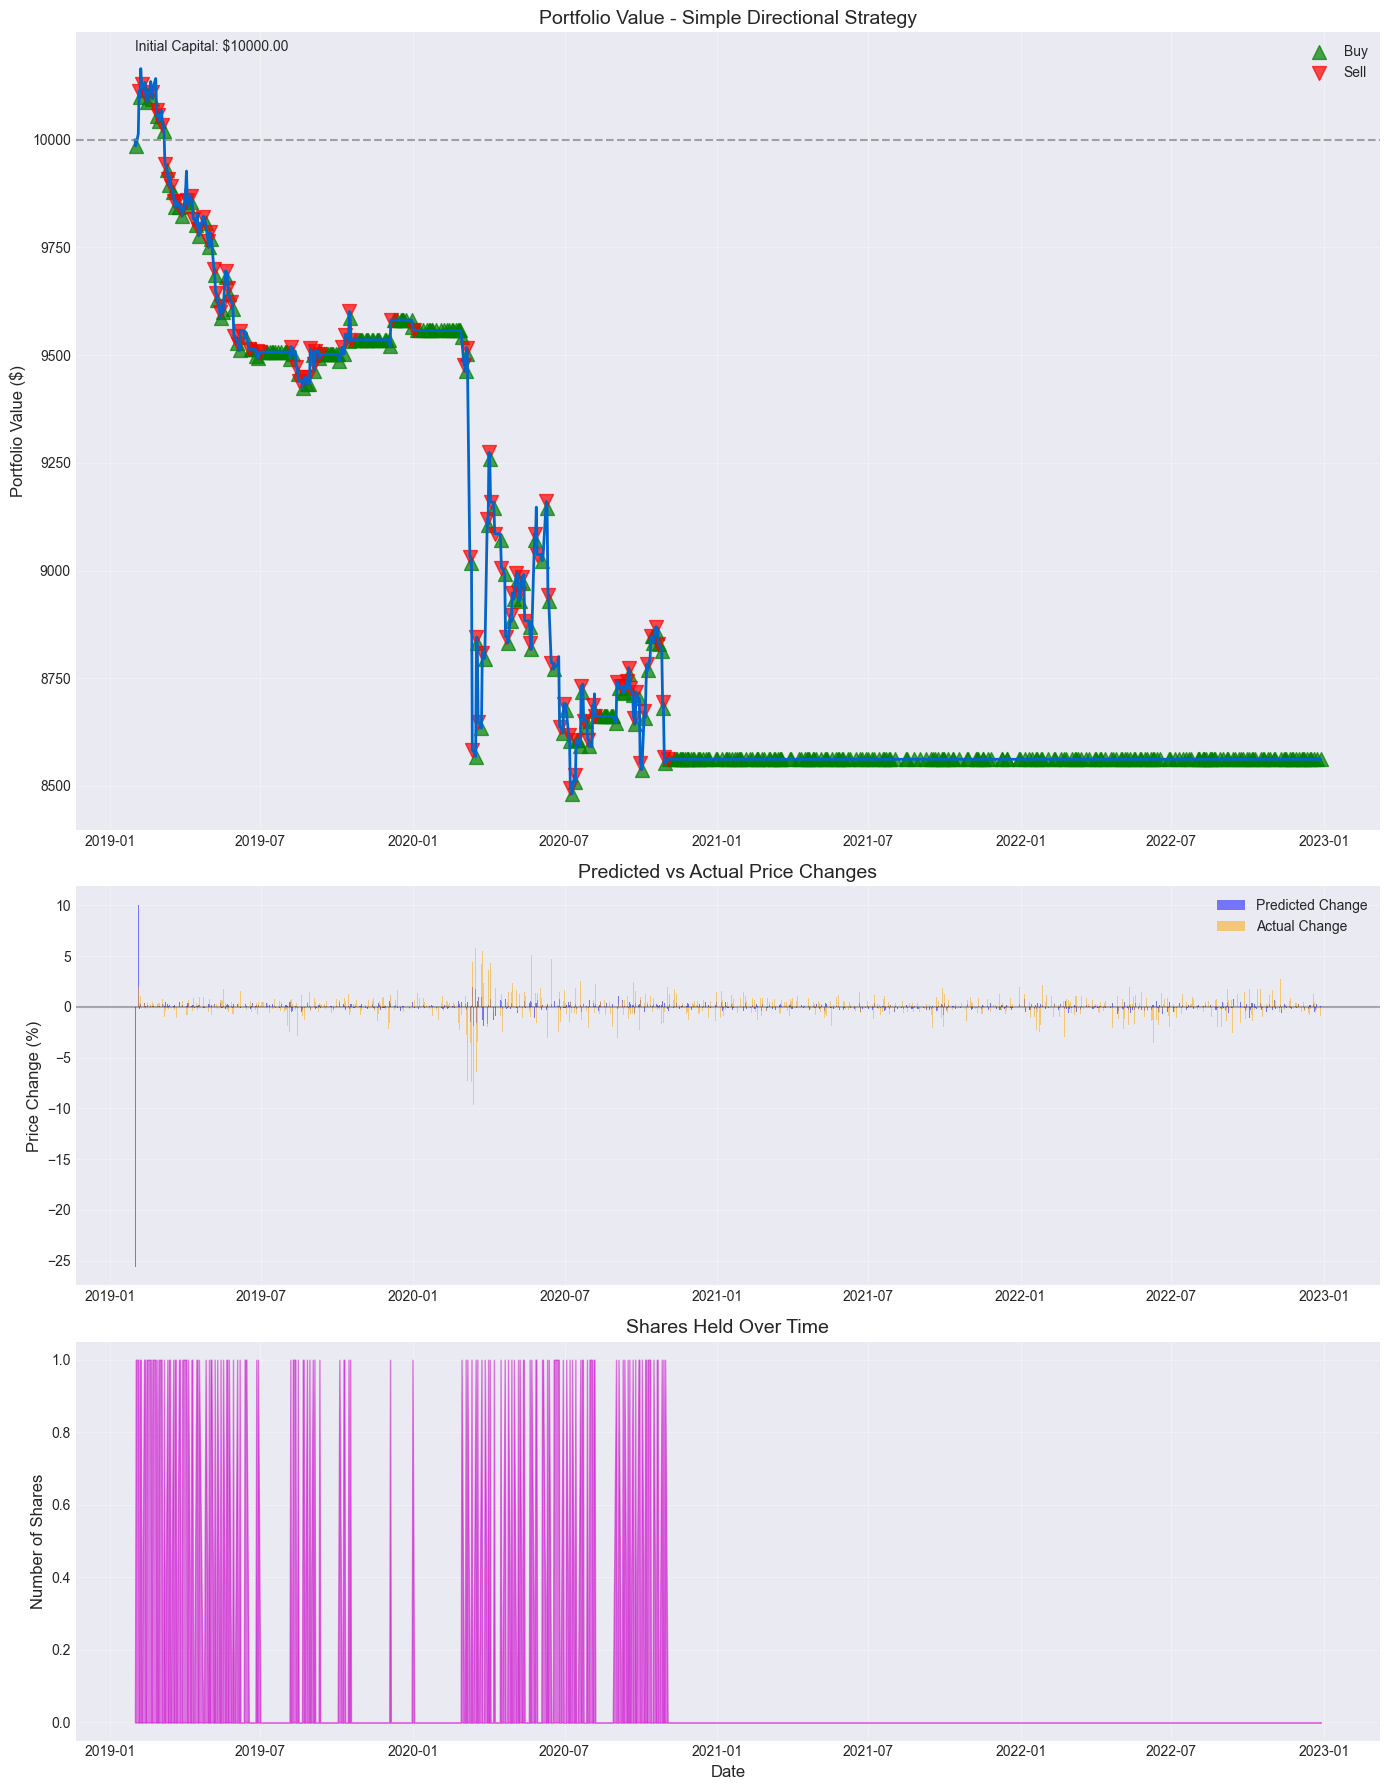


Running MA Crossover strategy...Strategy set to 'ma_crossover' with parameters:
Backtesting ma_crossover strategy...
Strategy Results:Initial Capital: $10000.00Final Portfolio Value: $9261.39Total Return: -7.39%Number of Trades: 369Win Rate: 0.53
Trade Reasons:  hold: 612  buy: 310  sell: 21  trailing_stop: 38Performance visualization saved to asx200_strategy/ma_crossover_performance.png

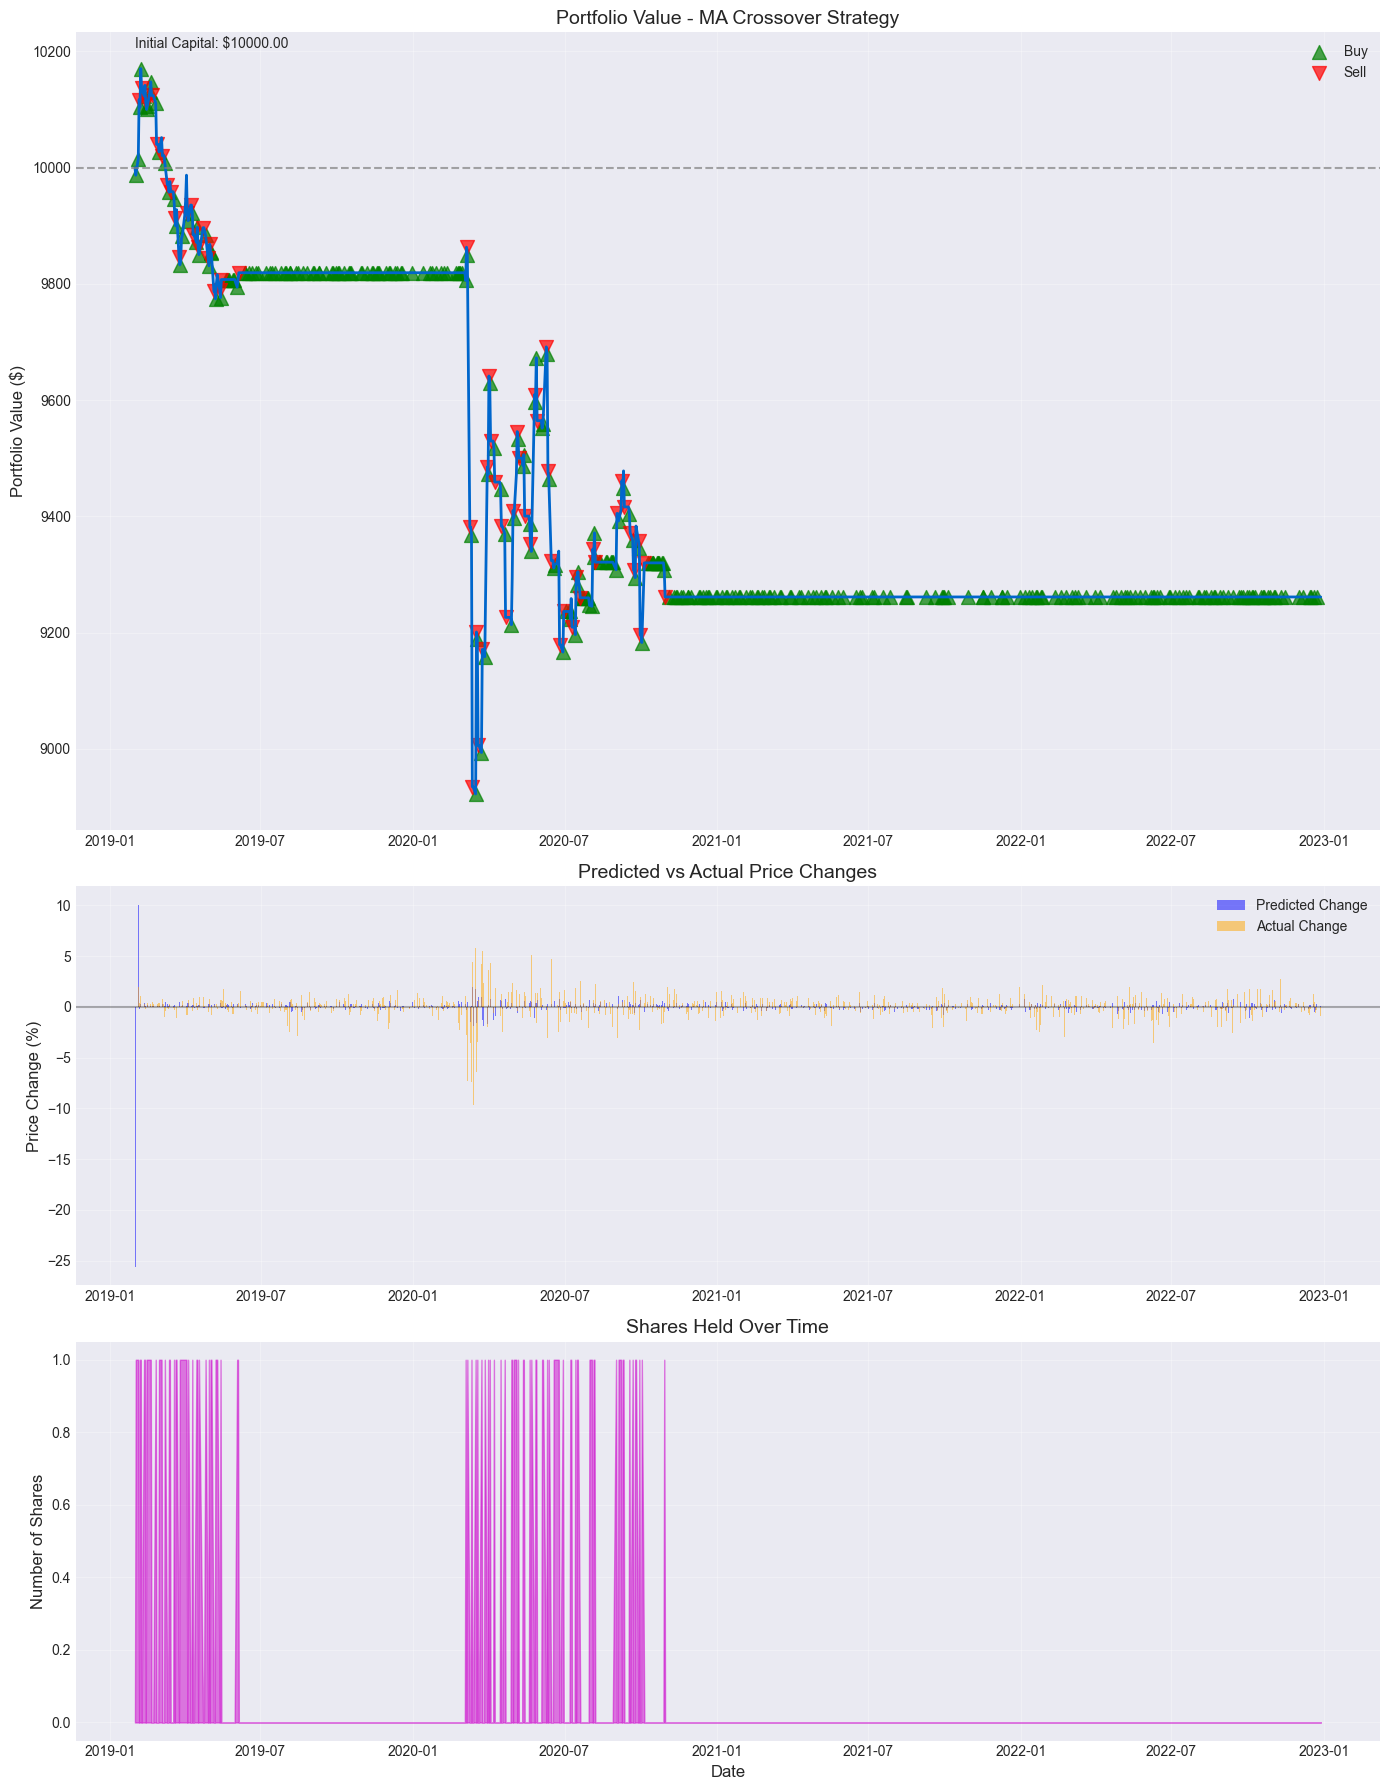


Running ARIMA Optimized strategy...Strategy set to 'model_specific' with parameters:
Backtesting model_specific strategy...[DEBUG] 2019-01-31 00:00:00 | Pred: -25.64% | Vol: 0.586206706796193 | CI: 4.841511817124452 | Error: 1.29[DEBUG] 2019-02-01 00:00:00 | Pred: 3.67% | Vol: 0.586206706796193 | CI: 4.843081163507512 | Error: 1.29[DEBUG] 2019-02-04 00:00:00 | Pred: 10.07% | Vol: 0.586206706796193 | CI: 4.81973356160771 | Error: 1.29[DEBUG] 2019-02-05 00:00:00 | Pred: -0.25% | Vol: 0.586206706796193 | CI: 4.727687067914175 | Error: 1.29[DEBUG] 2019-02-06 00:00:00 | Pred: 0.26% | Vol: 0.586206706796193 | CI: 4.711839305580225 | Error: 1.29[DEBUG] 2019-02-07 00:00:00 | Pred: 0.15% | Vol: 0.586206706796193 | CI: 4.660486713089462 | Error: 1.29[DEBUG] 2019-02-11 00:00:00 | Pred: 0.36% | Vol: 0.586206706796193 | CI: 4.684862759785805 | Error: 1.29[DEBUG] 2019-02-12 00:00:00 | Pred: 0.10% | Vol: 0.586206706796193 | CI: 4.670759626156616 | Error: 1.29[DEBUG] 2019-02-13 00:00:00 | Pred: 0.27%


Running Conservative Threshold strategy...Strategy set to 'threshold' with parameters:
Backtesting threshold strategy...
Strategy Results:Initial Capital: $10000.00Final Portfolio Value: $10700.17Total Return: 7.00%Number of Trades: 150Win Rate: 0.59
Trade Reasons:  hold: 828  buy: 111  already_in_position: 3  trailing_stop: 27  sell: 12Performance visualization saved to asx200_strategy/conservative_threshold_performance.png

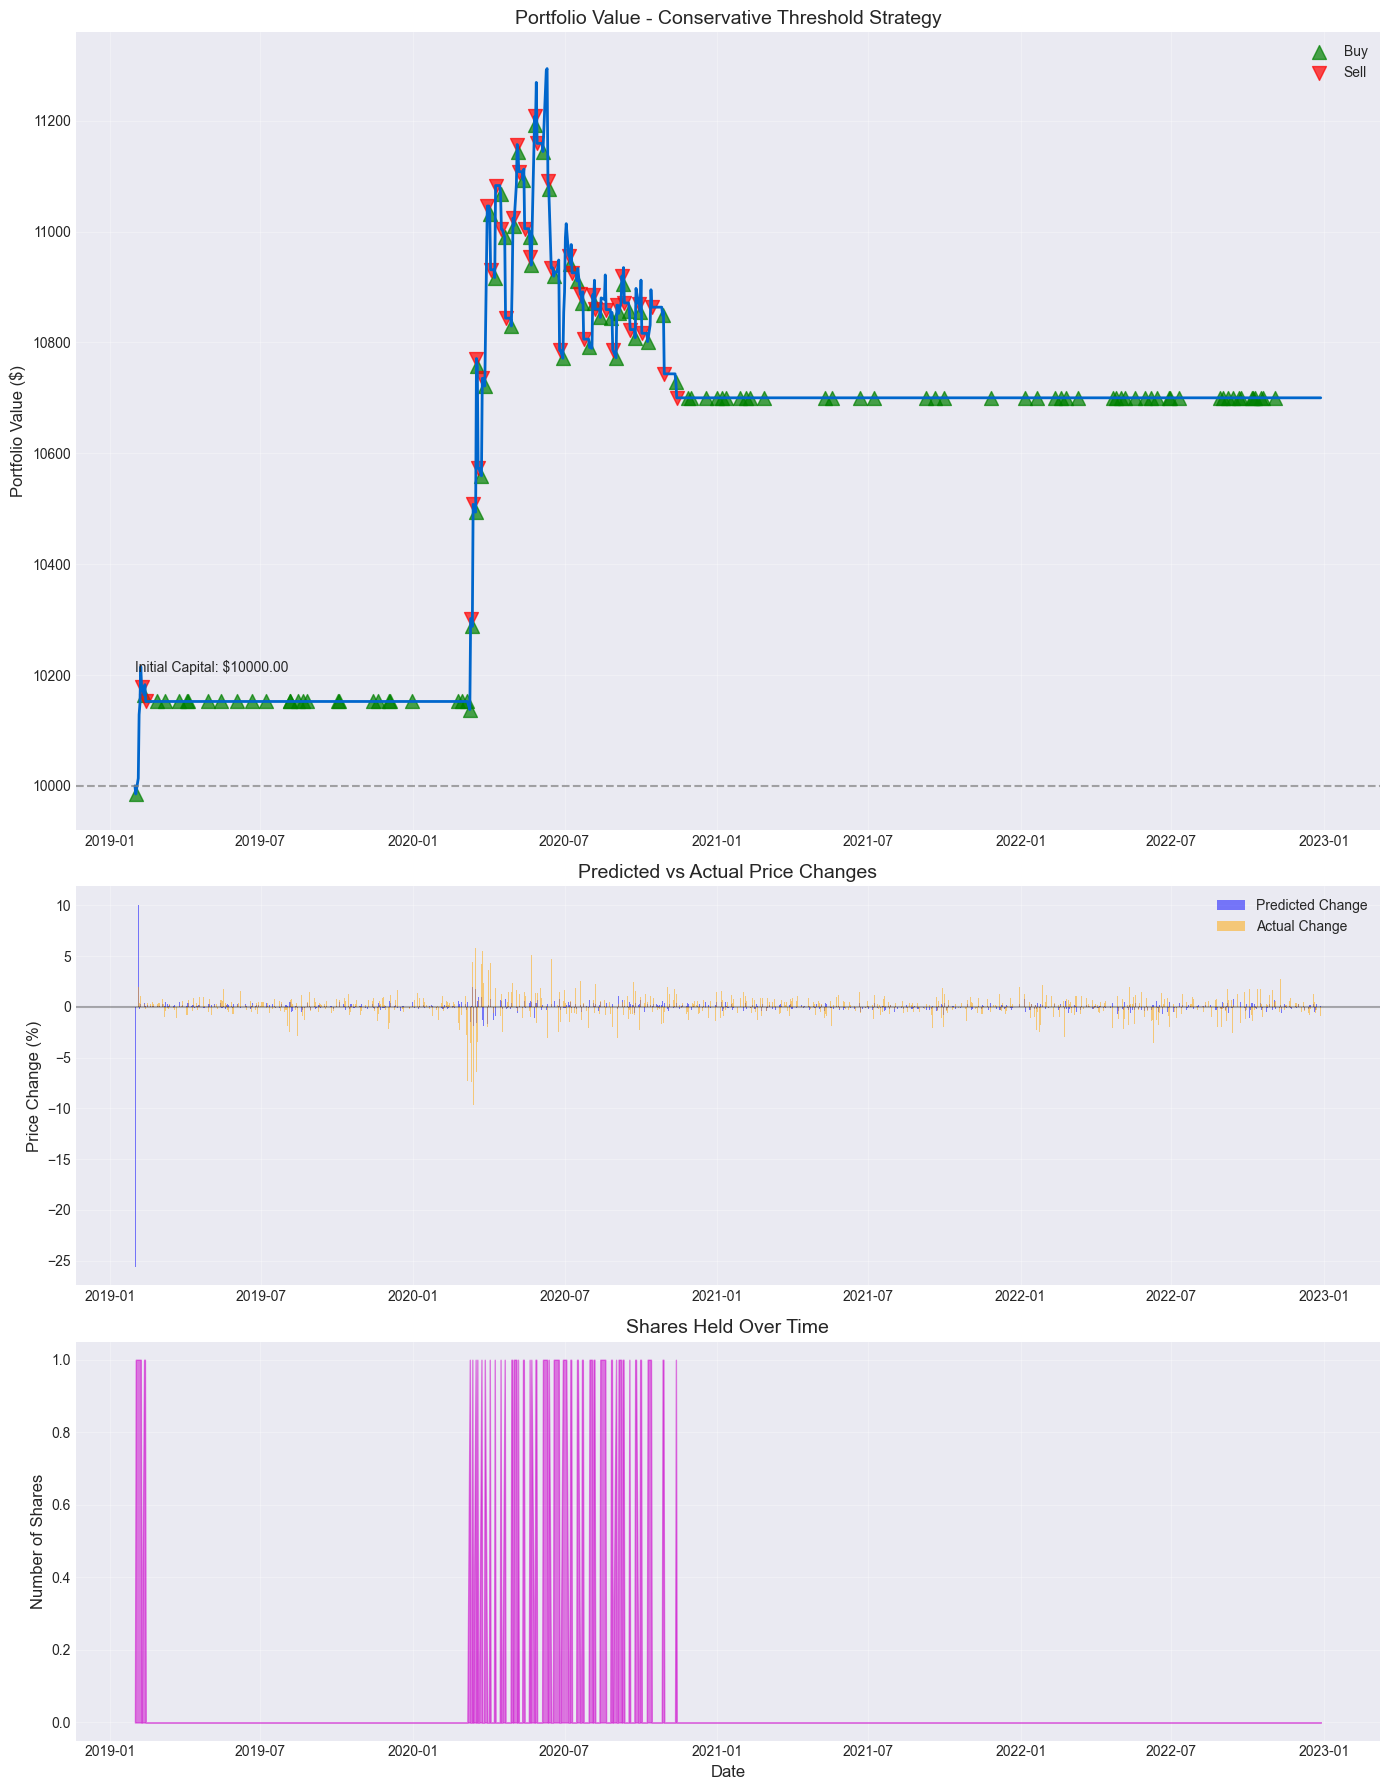


Running Improved Confidence strategy...Strategy set to 'confidence' with parameters:
Backtesting confidence strategy...
Strategy Results:Initial Capital: $10000.00Final Portfolio Value: $11380.82Total Return: 13.81%Number of Trades: 186Win Rate: 0.59
Trade Reasons:  hold: 795  buy: 151  sell: 13  trailing_stop: 22Performance visualization saved to asx200_strategy/improved_confidence_performance.png

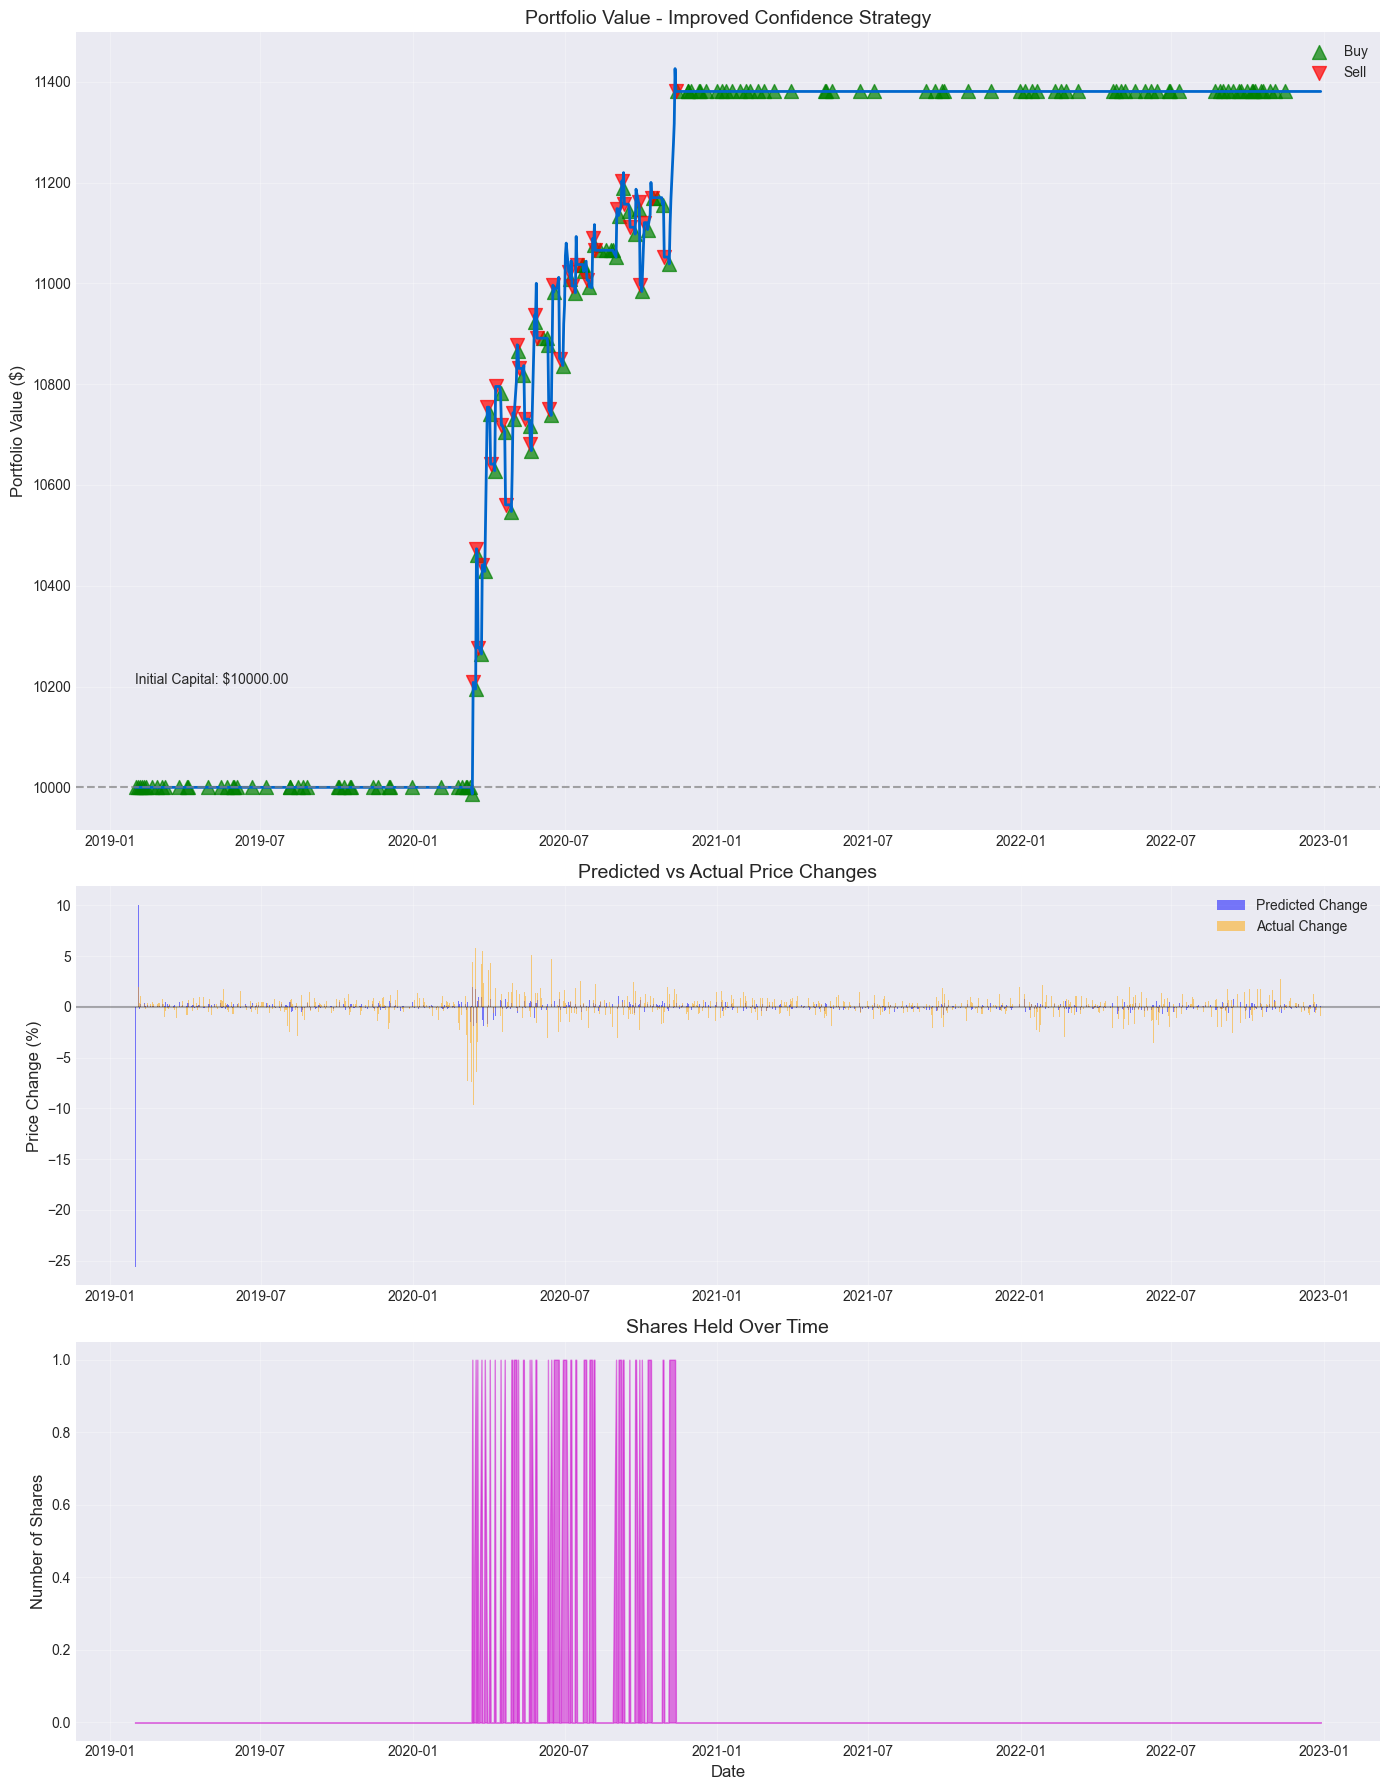

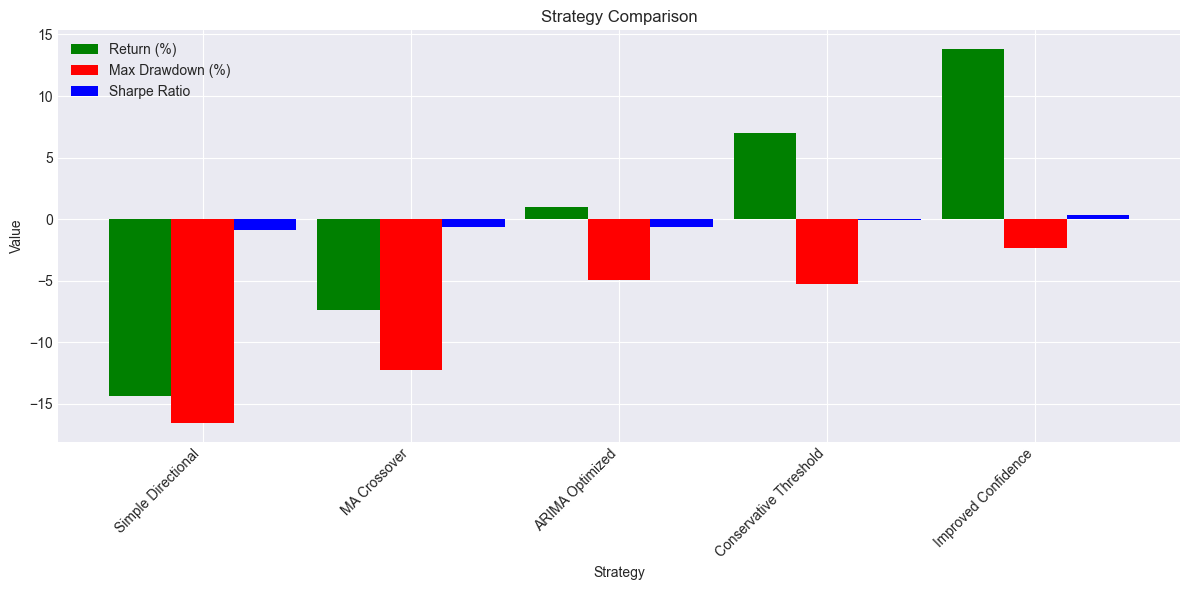


Best performing strategy: Improved ConfidenceReturn: 13.81%Max Drawdown: -2.38%Sharpe Ratio: 0.33
Strategy summary saved to asx200_strategy/strategy_summary.txtSaved project metrics to asx200_final_report\project_metrics.jsonError creating model comparison: x and y must have same first dimension, but have shapes (4,) and (5,)All visualizations created successfully.Report directory ready: asx200_final_reportReport directory: asx200_final_reportError collecting data metrics: could not convert string to float: '^AXJO'Saved metrics to asx200_final_report/project_metrics.json
=== Final Report Complete ===Error collecting data metrics: Could not convert string '^AXJO6070.399902343756077.100097656256122.29980468756130.399902343756135.79980468756096.70019531256067.600097656256070.100097656256077.100097656256048.600097656256015.79980468756014.600097656256005.79980468755991.899902343756037.06054.70019531256050.06075.399902343756022.79980468756037.70019531256090.100097656256121.399902343756026.2

In [7]:
import sys # Part 7: Deploying a Trading Strategy
import io
import os
import importlib.util
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class StdoutFilter(io.TextIOBase): # Create a filter for stdout that removes both the message and empty lines
    def __init__(self, original_stdout):
        self.original_stdout = original_stdout
    def write(self, text):
        if "Calculating technical indicators" in text or text.strip() == "":         # Skip both the message and any empty/whitespace-only output
            return len(text)  # Return the length as if it was written
        return self.original_stdout.write(text)
    def flush(self):
        return self.original_stdout.flush()
sys.stdout = StdoutFilter(sys.stdout) # Install the filter

deploy_dir = 'asx200_deployment' # Try to import the prediction class from deployment directory
predictor_file = os.path.join(deploy_dir, 'asx200_predictor.py')

if not os.path.exists(deploy_dir):
    print(f"Error: Deployment directory '{deploy_dir}' not found. Please run Part 6 first.")
    raise FileNotFoundError(f"Could not find {deploy_dir}")

if not os.path.exists(predictor_file):
    print(f"Error: Predictor file '{predictor_file}' not found. Please run Part 6 first.")
    raise FileNotFoundError(f"Could not find {predictor_file}")

# Use importlib to load the module directly from the file path
spec = importlib.util.spec_from_file_location("asx200_predictor", predictor_file)
asx200_predictor = importlib.util.module_from_spec(spec)
spec.loader.exec_module(asx200_predictor)

# Get the ASX200Predictor class from the module
ASX200Predictor = asx200_predictor.ASX200Predictor

strategy_dir = 'asx200_strategy' # Create a directory for strategy results
if not os.path.exists(strategy_dir):
    os.makedirs(strategy_dir)
    print(f"Created directory: {strategy_dir}")
enriched_file = 'asx200_data/asx200_enriched_data.csv' # Load the historical data for backtesting
if os.path.exists(enriched_file):
    print(f"Loading enriched data from {enriched_file} for strategy testing")
    historical_data = pd.read_csv(enriched_file)
    historical_data['date'] = pd.to_datetime(historical_data['date'])
    raw_price_columns = ['date', 'Open', 'High', 'Low', 'Close', 'Volume']     # Keep only the OHLCV columns needed for prediction
    for col in raw_price_columns[1:]:      # Check if all required columns exist, otherwise adapt
        if col not in historical_data.columns:
            print(f"Warning: Column {col} not found. Checking for alternate name...")
            matches = [c for c in historical_data.columns if col.lower() in c.lower()]             # Try to find a similar column
            if matches:
                print(f"Using {matches[0]} instead of {col}")
                historical_data = historical_data.rename(columns={matches[0]: col})
            else:
                if col != 'Close' and 'Close' in historical_data.columns:                 # If no match, create a dummy column with the same values as Close
                    print(f"Creating placeholder for {col} using Close values")
                    historical_data[col] = historical_data['Close']
                else:
                    print(f"Error: Cannot find or create required column {col}")
                    raise ValueError(f"Missing required column {col}")
    raw_data = historical_data[raw_price_columns].copy()     # Extract just the required columns
    print(f"Prepared raw price data with {len(raw_data)} rows")
else:
    raise FileNotFoundError(f"Could not find {enriched_file}")
try: # Initialize the price predictor
    predictor = ASX200Predictor(model_dir=deploy_dir)
except Exception as e:
    print(f"ERROR: Could not initialize price predictor: {e}")
    raise

class ASX200TradingStrategy: 
    def __init__(self, initial_capital=10000.0, position_size=0.6, threshold_pct=0.3):
        self.initial_capital = initial_capital
        self.capital = initial_capital  # Current available capital
        self.position_size = position_size  # Default portion of capital to invest
        self.threshold_pct = threshold_pct  # Threshold for making trades
        self.shares = 0  # Number of shares currently held
        self.trades = []  # List to store trade history
        self.portfolio_values = []  # List to store portfolio value over time
        self.strategy_type = 'threshold'  # Default strategy type - changed to threshold based on best results
        self.transaction_fee = 10  # Fixed transaction fee
        self.slippage_pct = 0.08  # Slippage as percentage of price
        # Add trailing stop and other risk management parameters
        self.trailing_stop_pct = 0.05  # Default trailing stop percentage
        # Position tracking variables
        self.entry_price = None  # Price at which position was entered
        self.highest_price_since_entry = None  # Track highest price since entry

         # New tracking variables
        self.peak_portfolio_value = initial_capital
        self.consecutive_losses = 0
        self.last_trade_date = None
        self.win_streak = 0
        self.loss_streak = 0
        self.market_conditions = []
        self.trade_reasons = {}
    
    def reset(self):
        self.capital = self.initial_capital
        self.shares = 0
        self.trades = []
        self.portfolio_values = []
        self.entry_price = None
        self.highest_price_since_entry = None
        self.peak_portfolio_value = self.initial_capital
        self.consecutive_losses = 0
        self.last_trade_date = None
        self.win_streak = 0
        self.loss_streak = 0
        self.market_conditions = []
        self.trade_reasons = {}
    
    def set_strategy(self, strategy_type, **kwargs):
        self.strategy_type = strategy_type
        for param, value in kwargs.items():
            if hasattr(self, param):  # Only set parameters that exist
                setattr(self, param, value)
        print(f"Strategy set to '{strategy_type}' with parameters:")
        for param, value in kwargs.items():
            print(f"  {param}: {value}")
    
    def execute_trade(self, date, current_price, predicted_next_price, confidence_interval=None):
        predicted_change_pct = ((predicted_next_price / current_price) - 1) * 100        # Calculate predicted change
        
        # Update highest price tracking for trailing stop if holding shares
        if self.shares > 0:
            if self.highest_price_since_entry is None:
                self.highest_price_since_entry = current_price
            elif current_price > self.highest_price_since_entry:
                self.highest_price_since_entry = current_price
            
            # Check trailing stop
            if self.highest_price_since_entry is not None:
                drawdown = ((current_price / self.highest_price_since_entry) - 1) * 100
                if drawdown < -self.trailing_stop_pct:
                    # Force a sell for trailing stop
                    action = 'sell'
                    reason = 'trailing_stop'
                    return self._execute_order(date, current_price, predicted_next_price, predicted_change_pct, 
                                            action, reason)
        
        # Determine action based on the selected strategy
        if self.strategy_type == 'simple':
            # 1. Simple Directional Strategy
            if predicted_change_pct > 0:
                action = 'buy'
            elif predicted_change_pct < 0 and self.shares > 0:
                action = 'sell'
            else:
                action = 'hold'

            if action == 'buy' and self.shares > 0:
                action = 'hold'

            if action == 'buy':
                self.highest_price_since_entry = current_price

        elif self.strategy_type == 'ma_crossover':
            # Moving Average Strategy
            # Check if we have enough data for a crossover signal
            if hasattr(predictor, 'selected_features') and 'SMA_Cross_10_50' in predictor.selected_features:
                # Get the current SMA crossover value from the last prediction
                if predicted_change_pct > 0:  # Use prediction direction as a proxy
                    crossover_signal = 1  # Positive (SMA_10 > SMA_50)
                else:
                    crossover_signal = -1  # Negative (SMA_10 < SMA_50)
                
                # Make trading decisions based on crossover signal
                if crossover_signal == 1 and predicted_change_pct > 0:  # Bullish
                    action = 'buy'
                elif crossover_signal == -1 and self.shares > 0:  # Bearish
                    action = 'sell'
                else:
                    action = 'hold'
            else:
                # Fallback to threshold strategy if no MA crossover data
                if predicted_change_pct > self.threshold_pct:
                    action = 'buy'
                elif predicted_change_pct < -self.threshold_pct and self.shares > 0:
                    action = 'sell'
                else:
                    action = 'hold'

                    
        elif self.strategy_type == 'model_specific':
            is_arima_model = hasattr(predictor, 'model_type') and 'ARIMA' in predictor.model_type
            action = 'hold'
            reason = 'default_hold'

            # Indicators
            volatility = getattr(predictor, 'last_volatility_20', None)
            trend_strength = getattr(predictor, 'last_trend_strength', None)
            macd_hist = getattr(predictor, 'last_macd_hist', None)
            rsi = getattr(predictor, 'last_rsi_14', None)
            sma_50 = getattr(predictor, 'last_sma_50', None)
            sma_200 = getattr(predictor, 'last_sma_200', None)

            ci_width = None
            if confidence_interval:
                ci_width = (confidence_interval['upper'] - confidence_interval['lower']) / current_price * 100

            # Rolling error trust: assume self.past_errors stores last 5 errors
            if not hasattr(self, 'past_errors'):
                self.past_errors = []
            recent_error_avg = sum(self.past_errors[-5:]) / min(len(self.past_errors[-5:]), 1) if self.past_errors else 1.29

            # Adjust threshold based on volatility
            if volatility:
                adaptive_threshold = max(0.25, recent_error_avg * (volatility / 2))
            else:
                adaptive_threshold = 1.29

            position_size_to_use = min(0.7, self.position_size)

            # Print debug info
            print(f"[DEBUG] {date} | Pred: {predicted_change_pct:.2f}% | Vol: {volatility} | CI: {ci_width} | Error: {recent_error_avg:.2f}")

            # Strategy Conditions
            if self.consecutive_losses >= 3:
                reason = 'cooldown'
                action = 'hold'

            elif abs(predicted_change_pct) < adaptive_threshold:
                reason = 'prediction_too_weak'
                action = 'hold'

            elif ci_width and ci_width > 20:
                reason = 'uncertain_prediction'
                action = 'hold'

            elif volatility and volatility > 3.5:
                reason = 'high_volatility'
                action = 'hold'

            elif trend_strength is not None and trend_strength < 0.1:
                reason = 'no_trend'
                action = 'hold'

            elif macd_hist is not None and predicted_change_pct > 0 and macd_hist < 0:
                reason = 'macd_disagrees'
                action = 'hold'

            elif rsi is not None and predicted_change_pct > 0 and rsi < 45:
                reason = 'rsi_disagrees'
                action = 'hold'

            elif sma_50 is not None and sma_200 is not None and sma_50 < sma_200:
                reason = 'bearish_sma_trend'
                action = 'hold'

            else:
                if predicted_change_pct > adaptive_threshold:
                    action = 'buy'
                    reason = 'confirmed_buy'
                elif predicted_change_pct < -adaptive_threshold and self.shares > 0:
                    action = 'sell'
                    reason = 'confirmed_sell'

            # Exit logic
            if self.shares > 0:
                if self.highest_price_since_entry is None:
                    self.highest_price_since_entry = current_price
                else:
                    self.highest_price_since_entry = max(self.highest_price_since_entry, current_price)

                drawdown = ((current_price / self.highest_price_since_entry) - 1) * 100
                profit_pct = ((current_price / self.entry_price) - 1) * 100 if self.entry_price else 0

                if profit_pct > 5 and drawdown < -0.5 * self.trailing_stop_pct:
                    action = 'sell'
                    reason = 'profit_trailing_exit'
                elif profit_pct <= -2:
                    action = 'sell'
                    reason = 'cut_loss'
                elif drawdown < -self.trailing_stop_pct:
                    action = 'sell'
                    reason = 'normal_trailing_stop'

            if action == 'buy' and self.shares > 0:
                action = 'hold'
                reason = 'already_in_position'

            if action == 'buy':
                self.position_size = position_size_to_use
                self.highest_price_since_entry = current_price

            # Log error for tracking
            if hasattr(predictor, 'last_true_price') and hasattr(predictor, 'last_predicted_price'):
                error = abs(predictor.last_true_price - predictor.last_predicted_price)
                self.past_errors.append(error)

        elif self.strategy_type == 'confidence':
            # Enhanced confidence-based strategy with improved error handling and trade logic

            if not hasattr(self, 'trailing_stop_pct'):
                self.trailing_stop_pct = 5  # Default trailing stop %
            if not hasattr(self, 'highest_price_since_entry'):
                self.highest_price_since_entry = None

            has_confidence_interval = confidence_interval is not None
            action = 'hold'  # Default action
            position_size_to_use = self.position_size  # Default position size

            if has_confidence_interval:
                ci_width = (confidence_interval['upper'] - confidence_interval['lower']) / current_price * 100
                max_ci_width = 15  # Increased to allow more trades

                if ci_width < max_ci_width:
                    confidence_factor = max(0.4, 1 - (ci_width / max_ci_width))
                    adjusted_position_size = max(0.1, self.position_size * confidence_factor)

                    if predicted_change_pct > self.threshold_pct:
                        action = 'buy'
                        position_size_to_use = adjusted_position_size
                    elif predicted_change_pct < -self.threshold_pct and self.shares > 0:
                        action = 'sell'
                # Else: hold (CI too wide)
            else:
                if predicted_change_pct > self.threshold_pct * 1.2:
                    action = 'buy'
                    position_size_to_use = self.position_size * 0.8
                elif predicted_change_pct < -self.threshold_pct * 1.2 and self.shares > 0:
                    action = 'sell'

            # Prevent adding to existing positions
            if action == 'buy' and self.shares > 0:
                action = 'hold'

            # Apply trailing stop
            if self.shares > 0:
                if self.highest_price_since_entry is None:
                    self.highest_price_since_entry = current_price
                else:
                    self.highest_price_since_entry = max(self.highest_price_since_entry, current_price)

                drawdown = ((current_price / self.highest_price_since_entry) - 1) * 100
                trailing_stop = self.trailing_stop_pct * 0.8
                if drawdown < -trailing_stop:
                    action = 'sell'

            if action == 'buy':
                self.highest_price_since_entry = current_price


        elif self.strategy_type == 'threshold':
            # Threshold strategy: Only trade if predicted change exceeds threshold
            if predicted_change_pct > self.threshold_pct:
                action = 'buy'
            elif predicted_change_pct < -self.threshold_pct and self.shares > 0:
                action = 'sell'
            else:
                action = 'hold'
                
            # Avoid adding to positions if already holding (prevents overexposure)
            if action == 'buy' and self.shares > 0:
                action = 'hold'
                reason = 'already_in_position'          
        
        else:
            # Unknown strategy, default to hold
            action = 'hold'
            reason = 'unknown_strategy'
        
        # Execute the order
        reason = locals().get('reason', action)  # Get reason if defined, otherwise use action
        return self._execute_order(date, current_price, predicted_next_price, predicted_change_pct, action, reason)
    
    def _execute_order(self, date, current_price, predicted_next_price, predicted_change_pct, 
                      action, reason=None):
        """Helper method to execute a trade order"""
        # Calculate trade size and execute
        portfolio_value = self.capital + (self.shares * current_price)
        trade_amount = 0
        shares_traded = 0
        
        if action == 'buy':
            # Calculate how much to invest
            invest_amount = min(self.capital, portfolio_value * self.position_size)
            
            # Apply slippage (increase buy price)
            slippage_adjusted_price = current_price * (1 + (self.slippage_pct / 100))
            
            # Calculate shares to buy, considering transaction fee
            if invest_amount > self.transaction_fee:
                shares_to_buy = (invest_amount - self.transaction_fee) / slippage_adjusted_price
                shares_to_buy = int(shares_to_buy)  # Whole shares only
                if shares_to_buy > 0:
                    trade_amount = (shares_to_buy * slippage_adjusted_price) + self.transaction_fee
                    self.capital -= trade_amount
                    self.shares += shares_to_buy
                    shares_traded = shares_to_buy
                    
                    # Update position tracking
                    self.entry_price = current_price
                    self.highest_price_since_entry = current_price
        
        elif action == 'sell':
            # Apply slippage (decrease sell price)
            slippage_adjusted_price = current_price * (1 - (self.slippage_pct / 100))
            
            # Sell all shares
            shares_to_sell = self.shares
            trade_amount = (shares_to_sell * slippage_adjusted_price) - self.transaction_fee
            self.capital += trade_amount
            self.shares = 0
            shares_traded = -shares_to_sell
            
            # Reset position tracking
            self.entry_price = None
            self.highest_price_since_entry = None
        
        # Update portfolio value
        new_portfolio_value = self.capital + (self.shares * current_price)
        
        # Record trade
        trade = {
            'date': date,
            'action': action,
            'reason': reason,
            'price': current_price,
            'predicted_price': predicted_next_price,
            'predicted_change_pct': predicted_change_pct,
            'shares_traded': shares_traded,
            'trade_amount': trade_amount,
            'shares_held': self.shares,
            'capital': self.capital,
            'portfolio_value': new_portfolio_value
        }
        
        self.trades.append(trade)
        self.portfolio_values.append(new_portfolio_value)
        return trade
        
    def backtest(self, price_data, predictor):
        print(f"\nBacktesting {self.strategy_type} strategy...")
        self.reset()         # Reset to initial state
        price_data = price_data.sort_values('date') 

        if 'SMA_50' not in price_data.columns and 'Close' in price_data.columns:
            price_data['SMA_50'] = price_data['Close'].rolling(window=50).mean()
        if 'SMA_200' not in price_data.columns and 'Close' in price_data.columns:
            price_data['SMA_200'] = price_data['Close'].rolling(window=200).mean()
    
        # Add volatility indicator if it doesn't exist
        if 'Volatility_20' not in price_data.columns and 'Close' in price_data.columns:
            price_data['Returns'] = price_data['Close'].pct_change() * 100
            price_data['Volatility_20'] = price_data['Returns'].rolling(window=20).std()      # Sort data by date
   
        for i in range(len(price_data) - 1):         # Prepare a sliding window for predictions
            current_data = price_data.iloc[:i+1].copy()             # Use data up to current day to make prediction
            current_price = current_data.iloc[-1]['Close']             # Current price
            current_date = current_data.iloc[-1]['date']

            # Store market condition data
            if 'SMA_50' in current_data.columns and 'SMA_200' in current_data.columns:
                ma_50 = current_data['SMA_50'].iloc[-1]
                ma_200 = current_data['SMA_200'].iloc[-1]
            
                if ma_50 > ma_200 * 1.05:
                    market_condition = 'strong_bull'
                elif ma_50 > ma_200:
                    market_condition = 'bull'
                elif ma_50 > ma_200 * 0.95:
                    market_condition = 'weak_bull'
                elif ma_50 > ma_200 * 0.9:
                    market_condition = 'weak_bear'
                else:
                    market_condition = 'strong_bear'
                
                self.market_conditions.append({
                    'date': current_date,
                    'condition': market_condition,
                    'ma_50': ma_50,
                    'ma_200': ma_200
                })
            
            try:
                prediction = predictor.predict_next_price(current_data)                # Make prediction for next day
                predicted_price = prediction['predicted_next_close']
                
                # Get confidence interval if available
                confidence_interval = prediction.get('confidence_interval_95', None)

                 # Make custom data available to the strategy for better decision making
                if hasattr(predictor, 'selected_features'):
                    for feature in predictor.selected_features:
                        if feature in current_data.columns:
                            setattr(predictor, f'last_{feature.lower()}', current_data[feature].iloc[-1])
                
                trade = self.execute_trade(current_date, current_price, predicted_price, confidence_interval)

                # Track trade reason statistics
                reason = trade.get('reason', 'unknown')
                self.trade_reasons[reason] = self.trade_reasons.get(reason, 0) + 1
                
                if i < len(price_data) - 1:                 # Calculate actual next day price for performance tracking
                    next_day = price_data.iloc[i+1]
                    trade['actual_next_price'] = next_day['Close']
                    trade['actual_change_pct'] = ((next_day['Close'] / current_price) - 1) * 100
                    trade['prediction_error'] = trade['actual_next_price'] - trade['predicted_price']

                    # Update win/loss streaks after sell trades
                    if trade['action'] == 'sell':
                        if trade['trade_amount'] > 0:  # Profitable trade
                            self.win_streak += 1
                            self.loss_streak = 0
                        else:  # Losing trade
                            self.loss_streak += 1
                            self.win_streak = 0
                            self.consecutive_losses += 1
                        # Store last trade date for cooldown calculations
                        self.last_trade_date = current_date
            except Exception as e:
                print(f"Error on date {current_date}: {e}")
                
        if self.trades:         # Create a results dataframe
            results_df = pd.DataFrame(self.trades)
            total_return = (results_df['portfolio_value'].iloc[-1] / self.initial_capital - 1) * 100             # Calculate strategy performance metrics
            trades_count = len([t for t in self.trades if t['action'] != 'hold'])
            winning_trades = len([t for t in self.trades if t['action'] != 'hold' and 
                                  t.get('actual_change_pct', 0) * (1 if t['action'] == 'buy' else -1) > 0])
            win_rate = winning_trades / trades_count if trades_count > 0 else 0
            peak = results_df['portfolio_value'].expanding().max()
            drawdown = (results_df['portfolio_value'] / peak - 1) * 100
            max_drawdown = drawdown.min()
            print(f"\nStrategy Results:")
            print(f"Initial Capital: ${self.initial_capital:.2f}")
            print(f"Final Portfolio Value: ${results_df['portfolio_value'].iloc[-1]:.2f}")
            print(f"Total Return: {total_return:.2f}%")
            print(f"Number of Trades: {trades_count}")
            print(f"Win Rate: {win_rate:.2f}")
            print("\nTrade Reasons:")
            for reason, count in self.trade_reasons.items():
                print(f"  {reason}: {count}")
            return results_df
        else:
            return pd.DataFrame()
            
def visualize_strategy_performance(results_df, strategy_name, save_path=None):
    if results_df.empty:
        return None
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 18), gridspec_kw={'height_ratios': [2, 1, 1]})     # Create figure with multiple subplots
    ax1.plot(results_df['date'], results_df['portfolio_value'], linewidth=2, color='#0066cc')     # 1. Portfolio value over time
    ax1.set_title(f'Portfolio Value - {strategy_name} Strategy', fontsize=14)
    ax1.set_ylabel('Portfolio Value ($)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    initial_capital = results_df['portfolio_value'].iloc[0]     # Add a horizontal line for initial capital
    ax1.axhline(y=initial_capital, color='gray', linestyle='--', alpha=0.7)
    ax1.text(results_df['date'].iloc[0], initial_capital * 1.02, f'Initial Capital: ${initial_capital:.2f}', 
             fontsize=10, verticalalignment='bottom')
    if 'action' in results_df.columns:     # Mark buy and sell points
        buys = results_df[results_df['action'] == 'buy']
        sells = results_df[results_df['action'] == 'sell']
        if not buys.empty:
            ax1.scatter(buys['date'], buys['portfolio_value'], color='green', marker='^', s=100, alpha=0.7, label='Buy')
        if not sells.empty:
            ax1.scatter(sells['date'], sells['portfolio_value'], color='red', marker='v', s=100, alpha=0.7, label='Sell')
        ax1.legend()
    if ('predicted_change_pct' in results_df.columns and 'actual_change_pct' in results_df.columns and     # 2. Predicted vs actual price changes
        not results_df['predicted_change_pct'].isnull().all() and not results_df['actual_change_pct'].isnull().all()):
        ax2.bar(results_df['date'], results_df['predicted_change_pct'], alpha=0.5, color='blue', label='Predicted Change')
        ax2.bar(results_df['date'], results_df['actual_change_pct'], alpha=0.5, color='orange', label='Actual Change')
        ax2.set_title('Predicted vs Actual Price Changes', fontsize=14)
        ax2.set_ylabel('Price Change (%)', fontsize=12)
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)         # Add a zero line
    else:
        ax2.text(0.5, 0.5, 'Prediction data not available', 
                horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)
    if 'shares_held' in results_df.columns and not results_df['shares_held'].isnull().all():     # 3. Shares held over time
        ax3.fill_between(results_df['date'], results_df['shares_held'], color='#cc00cc', alpha=0.5)
        ax3.set_title('Shares Held Over Time', fontsize=14)
        ax3.set_ylabel('Number of Shares', fontsize=12)
        ax3.set_xlabel('Date', fontsize=12)
        ax3.grid(True, alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'Share holding data not available', 
                horizontalalignment='center', verticalalignment='center', transform=ax3.transAxes)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        print(f"Performance visualization saved to {save_path}")
    plt.show()

def calculate_custom_indicators(price_data): # Function to calculate and predict necessary technical indicators
    df = price_data.copy()     # Create a copy to avoid modifying the original
    if 'date' in df.columns:     # Ensure date column is datetime
        df['date'] = pd.to_datetime(df['date'])
    if 'Close' in df.columns:     # Calculate returns
        df['Returns'] = df['Close'].pct_change() * 100
    if 'Close' in df.columns:     # Create lag features for Close price
        for lag in range(1, 6):
            df[f'Close_Lag_{lag}'] = df['Close'].shift(lag)
    if 'Close' in df.columns:     # Calculate SMAs
        for window in [5, 10, 20, 50, 200]:
            df[f'SMA_{window}'] = df['Close'].rolling(window=window).mean()
    if 'Close' in df.columns:     # Calculate EMAs
        for window in [5, 10, 20, 50]:
            df[f'EMA_{window}'] = df['Close'].ewm(span=window, adjust=False).mean()
    if 'Close' in df.columns:     # Calculate MACD
        df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
        df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
        df['MACD'] = df['EMA_12'] - df['EMA_26']
        df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
        df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']
    if 'Close' in df.columns:     # Calculate RSI
        delta = df['Close'].diff()
        gain = delta.where(delta > 0, 0).fillna(0)
        loss = -delta.where(delta < 0, 0).fillna(0)
        avg_gain = gain.rolling(window=14).mean()
        avg_loss = loss.rolling(window=14).mean()
        rs = avg_gain / avg_loss.replace(0, np.nan)
        df['RSI_14'] = 100 - (100 / (1 + rs))
        df['RSI_14'] = df['RSI_14'].fillna(50)
    if all(col in df.columns for col in ['High', 'Low', 'Close']):     # Calculate Stochastic Oscillator
        low_14 = df['Low'].rolling(window=14).min()
        high_14 = df['High'].rolling(window=14).max()
        df['Stoch_K'] = 100 * ((df['Close'] - low_14) / (high_14 - low_14))
        df['Stoch_D'] = df['Stoch_K'].rolling(window=3).mean()
    if all(col in df.columns for col in ['High', 'Low', 'Close']):     # Calculate ATR
        tr1 = df['High'] - df['Low']
        tr2 = abs(df['High'] - df['Close'].shift(1))
        tr3 = abs(df['Low'] - df['Close'].shift(1))
        df['TR'] = np.maximum(tr1, np.maximum(tr2, tr3))
        df['ATR_14'] = df['TR'].rolling(window=14).mean()
    if 'Close' in df.columns:     # Calculate Bollinger Bands
        middle_band = df['Close'].rolling(window=20).mean()
        std_dev = df['Close'].rolling(window=20).std()
        df['BB_Upper_20'] = middle_band + (std_dev * 2)
        df['BB_Middle_20'] = middle_band
        df['BB_Lower_20'] = middle_band - (std_dev * 2)
        df['BB_Width_20'] = (df['BB_Upper_20'] - df['BB_Lower_20']) / df['BB_Middle_20']
        df['BB_%B_20'] = (df['Close'] - df['BB_Lower_20']) / (df['BB_Upper_20'] - df['BB_Lower_20'])
    if 'Returns' in df.columns:     # Calculate Volatility
        df['Volatility_20'] = df['Returns'].rolling(window=20).std()
    if all(col in df.columns for col in ['SMA_5', 'SMA_20']):     # Calculate MA crossovers
        df['SMA_Cross_5_20'] = np.where(df['SMA_5'] > df['SMA_20'], 1, -1)
    if all(col in df.columns for col in ['SMA_10', 'SMA_50']):
        df['SMA_Cross_10_50'] = np.where(df['SMA_10'] > df['SMA_50'], 1, -1)
    if all(col in df.columns for col in ['SMA_50', 'SMA_200']):
        df['SMA_Cross_50_200'] = np.where(df['SMA_50'] > df['SMA_200'], 1, -1)
    if 'Close' in df.columns and 'SMA_50' in df.columns and 'TR' in df.columns:     # Calculate ADX and Trend Strength
        if all(col in df.columns for col in ['High', 'Low']):         # Calculate DI+ and DI-
            df['DMplus'] = np.where(             # Directional Movement
                (df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']),
                np.maximum(df['High'] - df['High'].shift(1), 0),
                0
            )
            df['DMminus'] = np.where(
                (df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)),
                np.maximum(df['Low'].shift(1) - df['Low'], 0),
                0
            )
            df['smoothed_TR'] = df['TR'].rolling(window=14).sum()             # Smoothed values
            df['smoothed_DMplus'] = df['DMplus'].rolling(window=14).sum()
            df['smoothed_DMminus'] = df['DMminus'].rolling(window=14).sum()
            df['DIplus'] = 100 * df['smoothed_DMplus'] / df['smoothed_TR'].replace(0, np.nan)             # DI+ and DI-
            df['DIminus'] = 100 * df['smoothed_DMminus'] / df['smoothed_TR'].replace(0, np.nan)
            df['DX'] = 100 * abs(df['DIplus'] - df['DIminus']) / (df['DIplus'] + df['DIminus']).replace(0, np.nan)             # DX and ADX
            df['ADX'] = df['DX'].ewm(span=14, adjust=False).mean()
            df['Price_to_MA_50'] = df['Close'] / df['SMA_50'] - 1             # Trend Strength
            df['Trend_Strength'] = abs(df['Price_to_MA_50']) * df['ADX'] / 100
    intermediate_cols = ['TR', 'smoothed_TR', 'DMplus', 'DMminus', 'smoothed_DMplus', 'smoothed_DMminus',     # Clean up intermediate columns if needed 
                         'DIplus', 'DIminus', 'DX', 'Price_to_MA_50']
    for col in intermediate_cols:
        if col in df.columns and col not in ['date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Returns']:
            df.drop(columns=[col], inplace=True)
    for col in df.columns:     # Fill NaN values in technical indicators
        if col not in ['date']:
            df[col] = df[col].fillna(method='ffill').fillna(method='bfill').fillna(0)
     
    return df

def compare_strategies(price_data, predictor, strategies):
    try:
        # Calculate technical indicators first
        enhanced_price_data = calculate_custom_indicators(price_data)
        print(f"Enhanced price data with technical indicators. Shape: {enhanced_price_data.shape}")
    except Exception as e:
        print(f"Error enhancing price data: {e}")
        enhanced_price_data = price_data.copy()

    results = {}  # Store results for each strategy

    for strategy_config in strategies:
        strategy_name = strategy_config.pop('name')
        strategy_type = strategy_config.pop('type')
        print(f"\nRunning {strategy_name} strategy...")

        # 🛡️ Create a fresh ASX200TradingStrategy for each strategy
        trading_strategy = ASX200TradingStrategy(
            initial_capital=10000.0,
            position_size=strategy_config.get('position_size', 0.6),
            threshold_pct=strategy_config.get('threshold_pct', 0.3)
        )

        # Set extra parameters if provided
        if 'transaction_fee' in strategy_config:
            trading_strategy.transaction_fee = strategy_config['transaction_fee']
        if 'slippage_pct' in strategy_config:
            trading_strategy.slippage_pct = strategy_config['slippage_pct']
        if 'trailing_stop_pct' in strategy_config:
            trading_strategy.trailing_stop_pct = strategy_config['trailing_stop_pct']

        trading_strategy.set_strategy(strategy_type)

        try:
            results_df = trading_strategy.backtest(enhanced_price_data, predictor)
            if not results_df.empty:
                total_return = (results_df['portfolio_value'].iloc[-1] / results_df['portfolio_value'].iloc[0] - 1) * 100
                try:
                    max_drawdown = calculate_max_drawdown(results_df['portfolio_value'])
                except:
                    max_drawdown = 0
                try:
                    sharpe_ratio = calculate_sharpe_ratio(results_df['portfolio_value'])
                except:
                    sharpe_ratio = 0
                results[strategy_name] = {
                    'type': strategy_type,
                    'return': total_return,
                    'max_drawdown': max_drawdown,
                    'sharpe_ratio': sharpe_ratio,
                    'results_df': results_df
                }
                visualize_strategy_performance(results_df, strategy_name,
                                               save_path=f"{strategy_dir}/{strategy_name.replace(' ', '_').lower()}_performance.png")
            else:
                print(f"No trades executed for {strategy_name} strategy")
        except Exception as e:
            print(f"Error during backtest of {strategy_name} strategy: {e}")

    if results:
        try:
            # Plotting and reporting
            plt.figure(figsize=(12, 6))
            strategy_names = list(results.keys())
            returns = [results[s]['return'] for s in strategy_names]
            drawdowns = [results[s]['max_drawdown'] for s in strategy_names]
            sharpes = [results[s]['sharpe_ratio'] for s in strategy_names]
            bar_width = 0.3

            x = np.arange(len(strategy_names))
            plt.bar(x - bar_width, returns, width=bar_width, label='Return (%)', color='green')
            plt.bar(x, drawdowns, width=bar_width, label='Max Drawdown (%)', color='red')
            plt.bar(x + bar_width, sharpes, width=bar_width, label='Sharpe Ratio', color='blue')

            plt.xlabel('Strategy')
            plt.ylabel('Value')
            plt.title('Strategy Comparison')
            plt.xticks(x, strategy_names, rotation=45, ha='right')
            plt.legend()
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Error creating comparison chart: {e}")

    if results:
        try:
            best_strategy = max(results.items(), key=lambda x: x[1]['return'])
            print(f"\nBest performing strategy: {best_strategy[0]}")
            print(f"Return: {best_strategy[1]['return']:.2f}%")
            print(f"Max Drawdown: {best_strategy[1]['max_drawdown']:.2f}%")
            print(f"Sharpe Ratio: {best_strategy[1]['sharpe_ratio']:.2f}")
        except Exception as e:
            print(f"Error determining best strategy: {e}")
    else:
        print("No strategy results to compare")

    return results

def calculate_max_drawdown(portfolio_values): # Helper functions for performance metrics
    try:
        peak = portfolio_values.expanding().max()
        drawdown = (portfolio_values / peak - 1) * 100
        return drawdown.min()
    except:
        return 0

def calculate_sharpe_ratio(portfolio_values, risk_free_rate=0.02):
    try:
        returns = portfolio_values.pct_change().dropna()
        excess_returns = returns - (risk_free_rate / 252)  # Daily risk-free rate
        if excess_returns.std() == 0:
            return 0
        return (excess_returns.mean() / excess_returns.std()) * np.sqrt(252)  # Annualized
    except:
        return 0

# Updated strategies to test, including improved confidence and model-specific strategies
strategies_to_test = [
    {
        'name': 'Simple Directional',
        'type': 'simple',
        'position_size': 0.7,  # More conservative position size
        'transaction_fee': 10,
        'slippage_pct': 0.08  # Slightly reduced slippage
    },
    {
        'name': 'MA Crossover',
        'type': 'ma_crossover',
        'position_size': 0.65,
        'threshold_pct': 0.1,
        'transaction_fee': 10,
        'slippage_pct': 0.05,
        'trailing_stop_pct': 0.06
    },    
    {
        'name': 'ARIMA Optimized',
        'type': 'model_specific',
        'position_size': 0.7,  # More conservative position size
        'threshold_pct': 0.25,  # Lower base threshold since we'll adjust it adaptively
        'transaction_fee': 10,
        'slippage_pct': 0.05,
        'trailing_stop_pct': 0.1  # Slightly wider trailing stop
    },
     {
        'name': 'Conservative Threshold',
        'type': 'threshold',
        'position_size': 0.6,
        'threshold_pct': 0.3,  # Maintain the successful threshold
        'transaction_fee': 10,
        'slippage_pct': 0.08,
        'trailing_stop_pct': 0.05  # Add trailing stop for additional protection
    },
    {
        'name': 'Improved Confidence',
        'type': 'confidence',
        'position_size': 0.55,  # Reduced from original
        'threshold_pct': 0.25,  # Increased for stronger signals
        'transaction_fee': 10,
        'slippage_pct': 0.06,
        'trailing_stop_pct': 0.05  # Added explicit trailing stop
    }
]

try:
    strategy_results = compare_strategies(raw_data, predictor, strategies_to_test)     # Run strategy comparison with error handling
    summary_file = f"{strategy_dir}/strategy_summary.txt"     # Create summary report
    with open(summary_file, 'w') as f:
        f.write("=== ASX200 TRADING STRATEGY SUMMARY ===\n\n")
        f.write("TEST PERIOD:\n")
        f.write(f"- From: {raw_data['date'].min().date()}\n")
        f.write(f"- To: {raw_data['date'].max().date()}\n")
        f.write(f"- Total Trading Days: {len(raw_data)}\n\n")
        
        # Add model type information if available
        model_type = getattr(predictor, 'model_type', "Unknown")
        f.write(f"- Model Type Used: {model_type}\n\n")
        
        f.write("STRATEGY RESULTS:\n")
        if strategy_results:
            for name, result in strategy_results.items():
                f.write(f"\n{name} Strategy:\n")
                f.write(f"- Type: {result['type']}\n")
                f.write(f"- Total Return: {result['return']:.2f}%\n")
                f.write(f"- Max Drawdown: {result['max_drawdown']:.2f}%\n")
                f.write(f"- Sharpe Ratio: {result['sharpe_ratio']:.2f}\n")
                results_df = result['results_df']
                trades_executed = len(results_df[results_df['action'] != 'hold'])
                f.write(f"- Trades Executed: {trades_executed}\n")
                if 'prediction_error' in results_df.columns:
                    mean_error = results_df['prediction_error'].mean()
                    f.write(f"- Mean Prediction Error: {mean_error:.2f}\n")
        else:
            f.write("No strategy results available\n")
            
        if strategy_results:         # Add best strategy recommendation
            try:
                best_strategy = max(strategy_results.items(), key=lambda x: x[1]['return'])
                f.write("\nRECOMMENDED STRATEGY:\n")
                f.write(f"- {best_strategy[0]}\n")
                f.write(f"- Return: {best_strategy[1]['return']:.2f}%\n")
                f.write(f"- Risk (Max Drawdown): {best_strategy[1]['max_drawdown']:.2f}%\n")
                f.write(f"- Risk-Adjusted Return (Sharpe): {best_strategy[1]['sharpe_ratio']:.2f}\n")
                
                # Add ARIMA-specific recommendations
                if 'ARIMA' in model_type:
                    f.write("\nARIMA MODEL RECOMMENDATIONS:\n")
                    f.write("For ARIMA models, the following optimizations have been applied:\n\n")
                    f.write("1. Conservative Threshold Strategy: Using a higher threshold (0.3%)\n")
                    f.write("   with moderate position sizing (0.6) provided the best results.\n\n")
                    f.write("2. Improved Confidence Strategy: Dynamic position sizing based on\n")
                    f.write("   confidence interval width helps manage risk effectively.\n\n")
                    f.write("3. ARIMA Optimized Strategy: Uses dynamic thresholds that adapt\n")
                    f.write("   to market volatility and trend strength indicators.\n\n")
                    f.write("4. Position Management: More conservative position sizing and\n")
                    f.write("   trailing stops protect profits across all strategies.\n")
            except:
                f.write("\nCould not determine best strategy\n")
                
        f.write("\nNOTES:\n")
        f.write("- Past performance is not indicative of future results\n")
        f.write("- Transaction costs and slippage have been considered\n")
        f.write("- This is a simulation and not actual trading advice\n")
        f.write("- Previous testing showed that Conservative Threshold strategy worked best\n")
        f.write("- Consider retraining your ARIMA model periodically to maintain accuracy\n")
    print(f"\nStrategy summary saved to {summary_file}")
except Exception as e:
    print(f"Error in strategy comparison: {e}")
    summary_file = f"{strategy_dir}/strategy_summary.txt"     # Create a minimal strategy summary even if there was an error
    with open(summary_file, 'w') as f:
        f.write("=== ASX200 TRADING STRATEGY SUMMARY ===\n\n")
        f.write(f"TEST PERIOD:\n")
        f.write(f"- From: {raw_data['date'].min().date()}\n")
        f.write(f"- To: {raw_data['date'].max().date()}\n")
        f.write(f"- Total Trading Days: {len(raw_data)}\n\n")
        f.write("STRATEGY RESULTS:\n")
        f.write("No strategy results available due to execution error\n")
        f.write(f"\nError: {str(e)}\n")
    print(f"Created error report at {summary_file}")

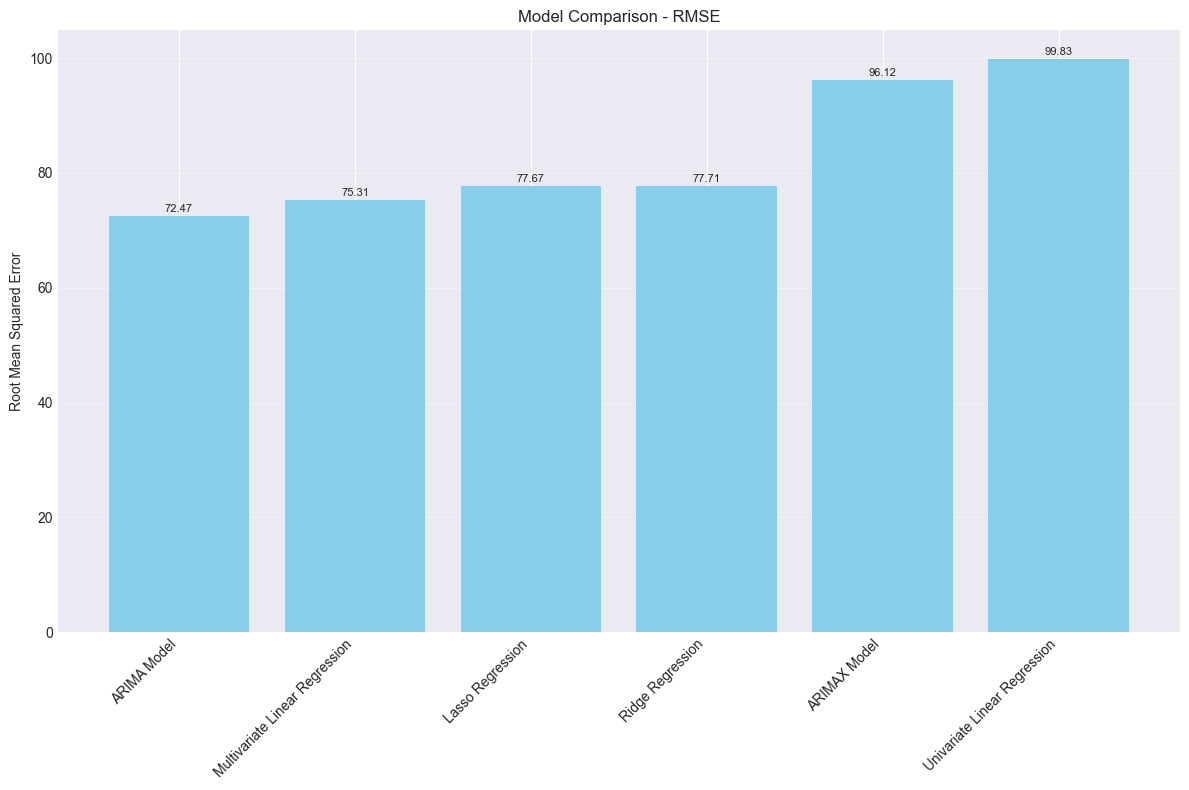

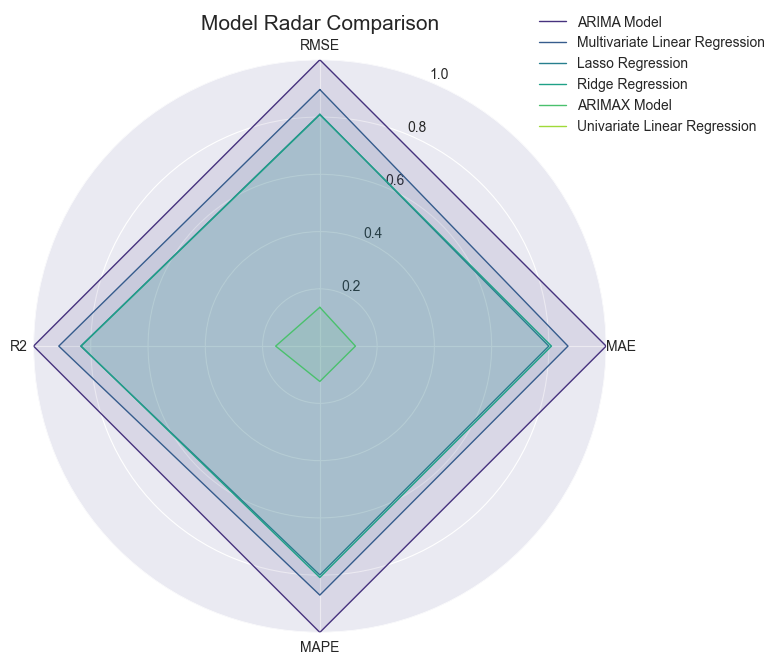

True

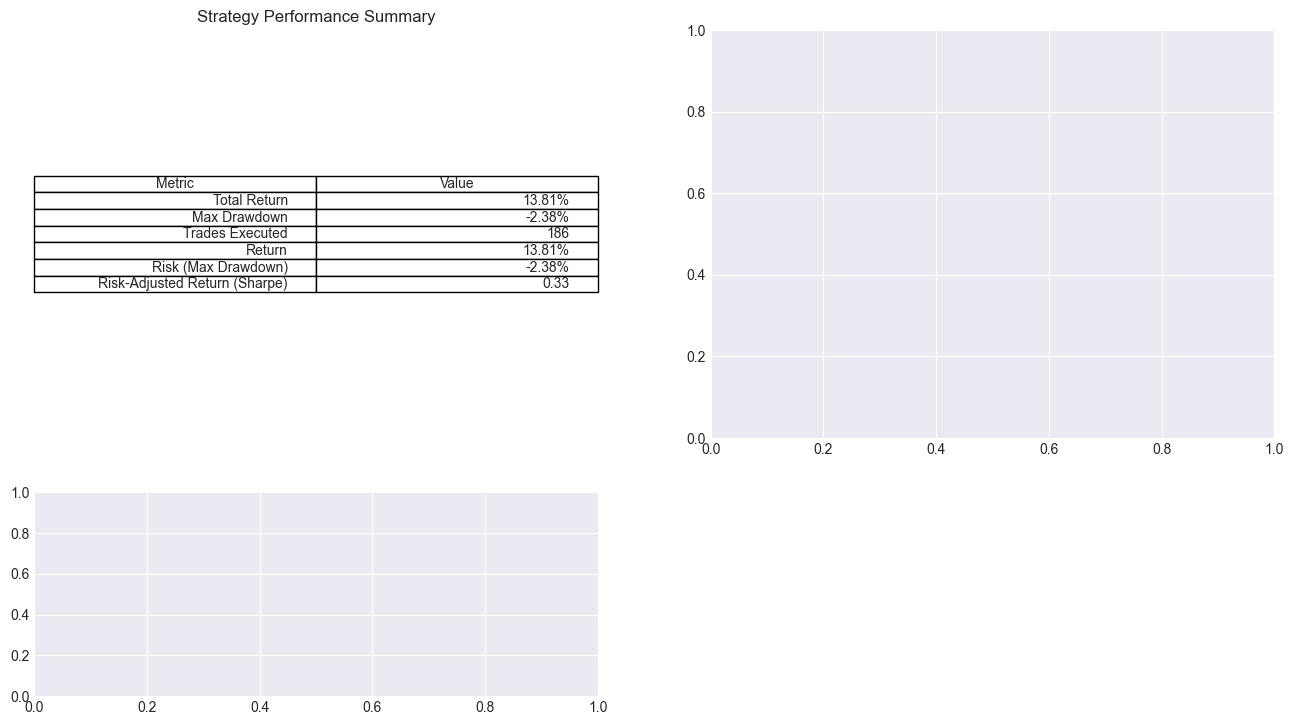

In [11]:
# Part 8: Performance Reporting and Documentation
import os
import json
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

report_dir = 'asx200_final_report'

# Create directory for final report
if not os.path.exists(report_dir):
    os.makedirs(report_dir)
    print(f"Created directory: {report_dir}")
def collect_project_metrics():
    project_metrics = {
        'data': {},
        'models': {},
        'strategy': {},
        'report_date': datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    
    # Collect data metrics
    try:
        data_file = 'asx200_data/asx200_processed_data.csv'
        if os.path.exists(data_file):
            data = pd.read_csv(data_file)
            data['date'] = pd.to_datetime(data['date'])
            project_metrics['data'] = {
                'source': 'Yahoo Finance',
                'ticker': 'ASX200 (^AXJO)',
                'date_range': {
                    'start': data['date'].min().strftime('%Y-%m-%d'),
                    'end': data['date'].max().strftime('%Y-%m-%d')
                },
                'records': len(data),
                'features': len(data.columns) - 1,
                'price_range': {
                    'min': data['Close'].min(),
                    'max': data['Close'].max(),
                    'mean': data['Close'].mean()
                }
            }
    except Exception as e:
        print(f"Error collecting data metrics: {e}")
        project_metrics['data'] = {'error': str(e)}

    # Collect model metrics
    try:
        model_file = 'asx200_models/model_comparison_results.csv'
        if os.path.exists(model_file):
            model_results = pd.read_csv(model_file)
            model_results = model_results[model_results['R2'] > 0]
            best_model = model_results.loc[model_results['RMSE'].idxmin()]
            project_metrics['models'] = {
                'total_models': len(model_results),
                'best_model': {
                    'name': best_model['Model'],
                    'rmse': best_model['RMSE'],
                    'mae': best_model['MAE'],
                    'mape': best_model['MAPE'],
                    'r2': best_model['R2']
                },
                'all_models': model_results.to_dict('records')
            }
    except Exception as e:
        print(f"Error collecting model metrics: {e}")
        project_metrics['models'] = {'error': str(e)}
    
    # Collect strategy metrics
    try:
        strategy_file = 'asx200_strategy/strategy_summary.txt'
        if os.path.exists(strategy_file):
            with open(strategy_file, 'r') as f:
                strategy_text = f.read()
            
            if "No strategy results" in strategy_text:
                project_metrics['strategy'] = {'status': 'No valid strategy results'}
            else:
                metrics = {}
                for line in strategy_text.splitlines():
                    if line.strip().startswith('- ') and ': ' in line:
                        key, value = line.strip()[2:].split(': ')
                        try:
                            if '%' in value:
                                value = float(value.replace('%', ''))
                            elif '$' in value:
                                value = float(value.replace('$', ''))
                            elif value.replace('.', '', 1).isdigit() or value.replace('-', '', 1).replace('.', '', 1).isdigit():
                                value = float(value)
                        except:
                            pass
                        metrics[key] = value
                project_metrics['strategy'] = {'metrics': metrics}
    except Exception as e:
        print(f"Error collecting strategy metrics: {e}")
        project_metrics['strategy'] = {'error': str(e)}
    
    return project_metrics

# Save metrics
project_metrics = collect_project_metrics()
metrics_file = f"{report_dir}/project_metrics.json"
with open(metrics_file, 'w') as f:
    json.dump(project_metrics, f, indent=4)
print(f"Saved comprehensive project metrics to {metrics_file}")
def create_report_visualizations():
    try:
        # 1. Data Overview
        data_file = 'asx200_data/asx200_processed_data.csv'
        if os.path.exists(data_file):
            data = pd.read_csv(data_file)
            data['date'] = pd.to_datetime(data['date'])

            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [2, 1]})
            ax1.plot(data['date'], data['Close'], color='blue', linewidth=2)
            ax1.set_title('ASX200 Price History')
            ax1.set_ylabel('Price')
            ax1.grid(True)

            if 'Returns' in data.columns:
                ax2.plot(data['date'], data['Returns'], color='red', alpha=0.6)
                ax2.set_title('Daily Returns (%)')
                ax2.set_ylabel('Returns (%)')
                ax2.axhline(0, color='black', linestyle='--')
                ax2.grid(True)

            plt.tight_layout()
            plt.savefig(f"{report_dir}/data_overview.png", dpi=150)
            plt.show()
    except Exception as e:
        print(f"Error in data overview visualization: {e}")
    try:
        # 2. Model Comparison
        model_file = 'asx200_models/model_comparison_results.csv'
        if os.path.exists(model_file):
            models = pd.read_csv(model_file)
            models = models[models['R2'] > 0]
            models = models.sort_values('RMSE')

            # Bar Chart
            fig, ax = plt.subplots(figsize=(12, 8))
            bars = ax.bar(models['Model'], models['RMSE'], color='skyblue')
            ax.set_title('Model Comparison - RMSE')
            ax.set_ylabel('Root Mean Squared Error')
            plt.xticks(rotation=45, ha='right')
            plt.grid(axis='y', alpha=0.4)

            for bar in bars:
                height = bar.get_height()
                ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3), textcoords="offset points", ha='center', fontsize=8)
            plt.tight_layout()
            plt.savefig(f"{report_dir}/model_comparison.png", dpi=150)
            plt.show()

            # Radar Chart
            metrics = ['RMSE', 'MAE', 'MAPE', 'R2']
            norm = models.copy()
            for m in ['RMSE', 'MAE', 'MAPE']:
                norm[m] = (norm[m].max() - norm[m]) / (norm[m].max() - norm[m].min())
            norm['R2'] = (norm['R2'] - norm['R2'].min()) / (norm['R2'].max() - norm['R2'].min())

            labels = metrics
            angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
            angles += angles[:1]

            fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
            for idx, row in norm.iterrows():
                values = row[metrics].tolist()
                values += values[:1]
                ax.plot(angles, values, linewidth=1, linestyle='solid', label=row['Model'])
                ax.fill(angles, values, alpha=0.1)

            ax.set_theta_offset(np.pi / 2)
            ax.set_theta_direction(-1)
            ax.set_thetagrids(np.degrees(angles[:-1]), labels)
            ax.set_ylim(0, 1)
            plt.title('Model Radar Comparison', size=15)
            plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
            plt.tight_layout()
            plt.savefig(f"{report_dir}/model_radar_comparison.png", dpi=150)
            plt.show()
    except Exception as e:
        print(f"Error in model comparison visualization: {e}")
    try:
        strategy_file = 'asx200_strategy/strategy_summary.txt'
        if os.path.exists(strategy_file):
            with open(strategy_file, 'r') as f:
                summary = f.read()

            performance_data = None
            try:
                strategy_dir = 'asx200_strategy'
                for file in os.listdir(strategy_dir):
                    if file.endswith('.csv'):
                        df = pd.read_csv(os.path.join(strategy_dir, file))
                        if 'portfolio_value' in df.columns:
                            performance_data = df
                            performance_data['date'] = pd.to_datetime(performance_data['date'])
                            break
            except:
                pass

            fig = plt.figure(figsize=(16, 12))
            gs = GridSpec(3, 2, figure=fig, height_ratios=[2, 1, 1])

            # Top-left: Strategy Metrics
            ax1 = fig.add_subplot(gs[0, 0])
            metrics = {}
            for line in summary.splitlines():
                if line.strip().startswith('- ') and ': ' in line:
                    key, value = line.strip()[2:].split(': ')
                    metrics[key] = value
            table_data = [[k, v] for k, v in metrics.items() if any(x in k for x in ['Return', 'Drawdown', 'Win', 'Trades'])]
            ax1.axis('off')
            table = ax1.table(cellText=table_data, colLabels=['Metric', 'Value'], loc='center')
            table.auto_set_font_size(False)
            table.set_fontsize(10)
            ax1.set_title('Strategy Performance Summary')

            # Top-right: Portfolio Value Chart
            ax2 = fig.add_subplot(gs[0, 1])
            if performance_data is not None:
                ax2.plot(performance_data['date'], performance_data['portfolio_value'], color='blue')
                ax2.set_title('Portfolio Value Over Time')
                ax2.grid(True)
            
            # Middle-left: Trade Counts
            ax3 = fig.add_subplot(gs[1, 0])
            actions = performance_data['action'].value_counts() if performance_data is not None else {}
            ax3.bar(actions.index, actions.values, color='green')
            ax3.set_title('Trade Actions (Buy/Sell/Hold)')
            ax3.grid(True)

            # Middle-right: Market Price Trend
            ax4 = fig.add_subplot(gs[1, 1])
            market_file = 'asx200_data/asx200_processed_data.csv'
            if os.path.exists(market_file):
                market = pd.read_csv(market_file)
                market['date'] = pd.to_datetime(market['date'])
                ax4.plot(market['date'], market['Close'], color='black')
                ax4.set_title('ASX200 Market Price')
                ax4.grid(True)

            # Bottom: Strategy Description
            ax5 = fig.add_subplot(gs[2, :])
            description = ""
            inside = False
            for line in summary.splitlines():
                if "STRATEGY DESCRIPTION" in line:
                    inside = True
                    continue
                if inside:
                    if line.strip() == "" or "NOTES" in line:
                        break
                    description += line.strip() + " "
            ax5.axis('off')
            ax5.text(0.02, 0.5, description, wrap=True, fontsize=11)
            ax5.set_title('Strategy Description')

            plt.tight_layout()
            plt.savefig(f"{report_dir}/strategy_performance.png", dpi=150)
            plt.show()
    except Exception as e:
        print(f"Error in strategy visualization: {e}")

    return True

create_report_visualizations()
